# PRÉPAREZ DES DONNÉES POUR UN ORGANISME DE SANTÉ PUBLIQUE

![](Logo-Sante-Publique-France-.png)

# Table des matières

* [Introduction](#Intro)
* [Partie 1 - Imports & Proposition d'application](#P1)
    * [P1.1. Imports des librairies & du dataset](#P11)
    * [P1.2. Import du dataset](#P12)
    * [P1.3. Proposition d'application](#P13)
    * [P1.4. Réduction du champ d'étude : France](#P14)
    * [P1.5. Quelques fonctions que nous utiliserons par la suite](#P15)
        * [P1.5.1. Fonctions générales](#P151)
        * [P1.5.2. Fonction de génération d'un dataframe de test, pour les imputations](#P152)
        * [P1.5.3. Fonctions sur l'imputation de features catégorielles](#P153)
        * [P1.5.4. Fonctions sur l'imputation de features numériques](#P154)
        * [P1.5.5. Fonctions de représentation de la distribution empirique](#P155)
        * [P1.5.6. Fonctions sur l'ANOVA](#P156)
        * [P1.5.7. Fonctions sur l'ACP](#P157)
    * [P1.6. Sélection des variables](#P16)
* [Partie 2 - Nettoyage](#P2)
    * [P2.1. Nommage des colonnes](#P21)
    * [P2.2. Éliminer les doublons](#P22)
        * [P2.2.1. Des produits en double ? "code"](#P221)
        * [P2.2.2. Des produits en double ? "product_name"](#P222)
        * [P2.2.3. Des produits en double ? "product_name" ET "brands"](#P223)
    * [P2.3. Traiter "pnns_groups_1" et "pnns_groups_2"](#P23)
        * [P2.3.1. Uniformiser le Format](#P231)
        * [P2.3.2. Traiter simplement quelques valeurs manquantes ?](#P232)
    * [P2.4. Traiter les outliers](#P24)
        * [P2.4.1. Masse de sucre négative](#P241)
        * [P2.4.2. Masse de constituant pour 100g supérieure à 100g](#P242)
        * [P2.4.3. Énergie pour 100g supérieure à 3700 kJ](#P243)
        * [P2.4.4. Sommes des masses des constituants PRINCIPAUX VS 100g](#P244)
        * [P2.4.5. Masse d'un sous-composant > macro-composant](#P245)
        * [P2.4.6. Traitement des outliers, impact sur la moyenne et l'écart-type](#P246)
    * [P2.5. Traiter les valeurs manquantes](#P25)
        * [P2.5.1. Nettoyage des valeurs manquantes : produits trop mal renseignés](#P251)
        * [P2.5.2. Imputations - Préambule](#P252)
        * [P2.5.3. Création d'un dataframe de test pour les imputations](#P253)
        * [P2.5.4. Imputation des features catégorielles](#P254)
        * [P2.5.5. Imputer les variables numériques. Tests sur la totalité du dataframe](#P255)
            * [P2.5.5.1. Global 5NN](#P2551)
            * [P2.5.5.2. Global BestNN](#P2552)
            * [P2.5.5.3. Global Iterative Imputer](#P2553)
        * [P2.5.6. Améliorer nos imputations](#P256)
            * [P2.5.6.1. Matrice des corrélations](#P2561)
            * [P2.5.6.2. Groupes d'imputation - impact de "pnns_1" ?](#P2562)
            * [P2.5.6.3. Imputation des valeurs manquantes par groupe de features correlées](#P2563)
        * [P2.5.7. Imputation finale des variables numériques](#P257)
        * [P2.5.8. Dernière étape de nettoyage - valeurs imputées aberrantes](#P258)
* [Partie 3 - Exploration](#P3)
    * [P3.1. - Analyses univariées](#P31)
    * [P3.2. - Analyse bivariée - ANOVA sur *`'nutrition_score_fr_100g ~ pnns_groups_1'`*](#P32)
        * [P3.2.1. - Question & Hypothèses](#P321)
        * [P3.2.2. - ANOVA - premier essai](#P322)
        * [P3.2.3. - ANOVA - second essai](#P323)
        * [P3.2.4. - ANOVA - interprétation](#P324)
        * [P3.2.5. - ANOVA - test avec des échantillons plus petits](#P325)
    * [P3.3. - ACP](#P33)
        * [P3.3.1. - ACP - Éboulis des valeurs propres](#P331)
        * [P3.3.2. - ACP - Matrice des correlations variables / loadings](#P332)
        * [P3.3.3. - ACP - Cercle des correlations](#P333)



# Introduction<a class="anchor" id="Intro"></a>

L'agence "Santé publique France" a lancé un **appel à projets pour rendre les données de santé plus accessibles**. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.

Le jeu de données à analyser est issu de la plateforme **Open Food Facts**, qui est une association donnant accès à une base données de produits alimentaires :
- ouverte à tous
- où tout le monde peut contribuer

Dans le cadre de cet appel à projets, nous :
- proposerons une idée d'application
- mènerons à bien le nettoyage nécessaire à l'exploration des données
- explorerons les données traitées

# Partie 1 - Imports & Proposition d'application<a class="anchor" id="P1"></a>

## P1.1. Imports des librairies & du dataset<a class="anchor" id="P11"></a>

Commençons par importer les principales librairies dont nous aurons besoin :

In [1]:
import pandas as pd # to manipulate the dataset with dataframes
import numpy as np # for statistics and calculations

import matplotlib.pyplot as plt # for data visualisation
%matplotlib inline
import matplotlib.ticker as mtick # for format axis in percent %
import seaborn as sns # for data visualisation, with different proporties
import missingno as ms # for visualisation of missing data

from sklearn.preprocessing import MinMaxScaler, StandardScaler # for scaling

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer # imputers

from sklearn.metrics import mean_squared_error, r2_score # measures for imputation quality

from sklearn.decomposition import PCA # PCA decomposition

import statsmodels.api as sm
from statsmodels.formula.api import ols # for ANOVA
import scipy.stats as stats

## P1.2. Import du dataset<a class="anchor" id="P12"></a>

In [2]:
foodRaw=pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t',low_memory=False)

Nous pouvons regarder les dimensions du tableau généré :

In [3]:
print("Le tableau mis à disposition comporte ", foodRaw.shape[1], "variables et ", foodRaw.shape[0], "lignes / produits")

Le tableau mis à disposition comporte  162 variables et  320772 lignes / produits


Nous pouvons affihcer les premières lignes :

In [4]:
display(foodRaw.head())

code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                    14.0                    14.0   
2                   NaN                     0.0                     0.0   
3                   NaN                    12.0                    12.0   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 162 columns]

Nous avons à disposition 4 types de variables :
- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : 
    - quantité en grammes d’un nutriment pour 100 grammes du produit.
    - des scores nutritionnels (comme le nutriscore)

## P1.3. Proposition d'application<a class="anchor" id="P13"></a>

Afin d'aider à améliorer la santé de nos concitoyens, nous pourrions utiliser les données mises à notre disposition pour aider les malades et les médecins.

En effet, un des principaux maux du 21$^{ème}$ est la multiplications de maladies chroniques dans nos sociétés industrialisées. Mes maladies cardiovasculaires représentent **la dépense la plus importante** pour l'Assurance Maladie.

**Hypertension, Diabètes, Cholestérol, Obésites, etc.** : Toutes ses pathologies sont, à des degrès différents, liées au régime alimentaire des malades.

En plus des médicaments, les médecins prescrivent également un **régime alimentaire adapté** aux pathologies chroniques des patients affectés.

Mais devant le nombre de produits disponibles en grandes surfaces, chacun avec une étiquette nutritionnelle qui lui est propre, le patient peut se retrouver démuni au moment de faire ses choix.

**MyHealthScore** : Une application **proposée par le médecin** à son patient pour l'aider à adapter son régime alimentaire à sa (ou ses) pathologie(s).

L'idée :
- le médecin configure le **profil** de son patient :
    - données biométriques : sexe, age, poids, taille, etc.
    - pathologie(s) : hypertension, diabètes, cholestérol, obésité, autre
    
    
- le profil permet de créé un score nutritionnel **adapté au patient** : *MyHealthScore*
    - ce score est basé sur les **mêmes données** nutritionnelles que le Nutri-Score :
        - La valeur énergétique (KJ)
        - Les lipides (g)
        - Les acides gras saturés (g)
        - Les sucres (g)
        - Les protéines (g)
        - Le sodium (mg)
        - Les fibres (g)
        - Fruits, légumes, etc. (%)
        
   mais **personnalisé** pour le profil du patient.


- l'**application** pourrait fonctionner ainsi :
    - le patient **scanne / rentre une référence** d'un produit
    - l'application **lui délivre ensuite son MyHeathScore personnalisé** selon les informations renseignées par son médecin.

- chaque système ayant ses propres spécificités, l'application serait dans un premier temps destinée au système de santé **français**.


## P1.4. Réduction du champ d'étude : France<a class="anchor" id="P14"></a>

Comme expliqué plus haut, nous allons nous concentrer sur le France dans le cadre cette étude.



Le dataset comporte plusieurs colonnes contenant des informations sur le pays :

In [5]:
# create a list with "coutries" columns
countriesColNames = [col for col in foodRaw.columns if "countri" in col]
countriesColNames

['countries', 'countries_tags', 'countries_fr']

Avant d'en sélectionner une pour notre filtrage, regardons à quoi elles ressemblent :

In [6]:
foodRaw[countriesColNames].sample(10)

countries    countries_tags countries_fr
75983         US  en:united-states   États-Unis
202714    France         en:france       France
225722    France         en:france       France
151319        US  en:united-states   États-Unis
267437    Россия         en:russia       Russie
198190     en:FR         en:france       France
189074     en:FR         en:france       France
277153    France         en:france       France
244492    France         en:france       France
222885    France         en:france       France

Nous pouvons nous concentrer sur la colonne "countries_fr".

Regardons le nombre de valeurs manquantes pour ces trois colonnes :

In [7]:
foodRaw[countriesColNames].isna().sum()

countries         280
countries_tags    280
countries_fr      280
dtype: int64

Elles n'en contiennent. Si elle ne sont pas positionnées aux mêmes endroits, nous pouvons regarder si "countries" et "countries_tags" peuvent nous aider à imputer "countries_fr" :

In [8]:
# create a mask for rows where "countries_fr" is NaN and one of the others is not
maskCountries = (foodRaw.countries_fr.isna())&((foodRaw.countries_tags.notna())|(foodRaw.countries.notna()))

foodRaw[countriesColNames].loc[maskCountries]

Empty DataFrame
Columns: [countries, countries_tags, countries_fr]
Index: []

Les autres colonnes ne peuvent donc pas nous aider à combler les 280 valeurs manquantes. Nous ne considérerons pas ces produits.

Regardons maintenant les différents pays contributeurs de la base de données :

In [9]:
# list of unique values in "countries_fr" and number of occurrences
foodRaw.countries_fr.value_counts(ascending=False)

États-Unis                                      172998
France                                           94392
Suisse                                           14953
Allemagne                                         7870
Espagne                                           5009
                                                 ...  
Danemark,Suisse,en:Deutschland,en:Frankreich         1
France,Luxembourg,Suisse                             1
Autriche,République tchèque,Allemagne                1
Allemagne,Hongrie                                    1
Chine,Hong Kong                                      1
Name: countries_fr, Length: 722, dtype: int64

Les valeurs de cette variable contiennent, en chaîne de caractères, la liste des pays où le produit est commercialisé.

Afin de nous concentrer sur la france, nous allons donc rechercher dans ces chaînes de caractères :

In [10]:
# create masks for french products 
maskFrance = foodRaw.countries_fr.str.find("France")!=-1
maskfrance = foodRaw.countries_fr.str.find("france")!=-1
maskFr = foodRaw.countries_fr.str.find("Fr")!=-1
maskFR = foodRaw.countries_fr.str.find("FR")!=-1
maskfr = foodRaw.countries_fr.str.find("fr")!=-1

Testons ces différents filtres.

In [11]:
foodRaw.loc[maskFrance,"countries_fr"].value_counts()

France                                                   94392
France,Suisse                                             1224
France,Royaume-Uni                                         514
Belgique,France                                            512
France,Allemagne                                           240
                                                         ...  
Belgique,France,Allemagne,Roumanie                           1
Australie,République tchèque,France,Allemagne,Hongrie        1
Danemark,France,Allemagne,Russie,Espagne,Royaume-Uni         1
République tchèque,Danemark,France,Allemagne                 1
France,Hong Kong                                             1
Name: countries_fr, Length: 305, dtype: int64

On obtient 305 valeurs uniques en recherchant avec "France". Continuons :

In [12]:
foodRaw.loc[maskfrance,"countries_fr"].value_counts()

Series([], Name: countries_fr, dtype: int64)

Cette orthographe n'est pas utilisée. Continuons :

In [13]:
foodRaw.loc[maskFr&~maskFrance,"countries_fr"].value_counts()

Suisse,Deutschland,Frankreich                                                                                                9
Suisse,Frankrijk,Nederland                                                                                                   2
Danemark,Suisse,es:Franciaorszag,es:Magyarorszag,es:Nagy-britannia,es:Portugalia,es:Spanyolorszag                            1
Belgique,Danemark,Suisse,es:Franciaorszag,es:Magyarorszag,es:Nagy-britannia,es:Nemetorszag,es:Portugalia,es:Spanyolorszag    1
Suisse,Deutschland,Frankreich,Spanien                                                                                        1
Suisse,Frankrijk                                                                                                             1
Suisse,Belgien,Deutschland,Frankreich                                                                                        1
Danemark,Suisse,en:Deutschland,en:Frankreich                                                                   

France est orthographié différemment.

In [14]:
foodRaw.loc[maskfr&~maskFrance,"countries_fr"].value_counts()

Polynésie française               52
Afrique du Sud                    36
en:fruit-yogurts                   8
Polynésie française,États-Unis     3
Polynésie française,Suisse         1
République centrafricaine          1
Name: countries_fr, dtype: int64

In [15]:
# create a mask for "Polynésie française"
maskPolyFr = foodRaw.countries_fr.str.find("Polynésie française")!=-1

In [16]:
foodRaw.loc[maskFR,"countries_fr"].value_counts()

Series([], Name: countries_fr, dtype: int64)

Ce dernier mask n'a rien donné. Nous pouvons donc filtrer notre dataframe pour ne conserver que les produits commercialisés en France : 

In [17]:
foodRawFr = foodRaw.copy()
#apply selected masks
foodRawFr = foodRawFr.loc[maskFrance|maskFr|maskPolyFr]

Voici les nouvelles dimensions du dataframe :

In [18]:
foodRawFr.shape

(98800, 162)

## P1.5. Quelques fonctions que nous utiliserons par la suite<a class="anchor" id="P15"></a>

### P1.5.1. Fonctions générales<a class="anchor" id="P151"></a>

Une fonction pour filtrer les colonnes vides. Intègre également un seuil, correspondant un taux de valeurs manquantes choisi.

In [19]:
def dropEmptyCols(df,emptinessThreshold=1) :
    
    """return an input pandas.DataFrame without its empty columns
    
    inputs
    ------
    df : pandas.DataFrame object
    
    optional inputs 
    ---------------
    emptinessThreshold : float, default : = 1. Gives the limit threshold of emptiness. 
    if >=threshold, column is dropped. 
    
    returns
    -------
    dfWithoutEmptyCols : pandas.DataFrame object, the same one without its empty columns
    
    """
    #select columns with percentage of null values > threshold
    emptyColsNames=df.isna().mean().loc[df.isna().mean()>=emptinessThreshold].index 
    
    #drop selected columns
    dfWithoutEmptyCols=df.copy()
    dfWithoutEmptyCols = dfWithoutEmptyCols.drop(columns=emptyColsNames)
    
    return dfWithoutEmptyCols

Une fonction qui crée un dictionnaire avec l'ensemble combinaisons de noms des colonnes d'un dataframe :

In [20]:
def getCombiOfCol(listOfCols) :
    from itertools import combinations
    dictOfCombis = {}
    for n in range(len(listOfCols)) :
        listOfCombis=[]
        for combi in list(combinations(listOfCols,len(listOfCols)-n)) :
            listOfCombis.append(list(combi))
        dictOfCombis[len(listOfCols)-n]=listOfCombis
    return dictOfCombis

Une fonction utilisant ipywidgets pour choisir le type de tableau issu de la méthode describe() sur un dataframe donné :

In [21]:
def myDescribe(df) :
    
    import ipywidgets as widgets # import library
  
    widDescribe=widgets.RadioButtons(options=["quantitative","qualitative","all"], 
                                     value="quantitative",
                                     description="Which features :",
                                     disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    def describeFunct(df, whichTypes) :
        if whichTypes=="qualitative" :
            include=["O","category"]
            exclude=["float64","int64"]
        elif whichTypes=="quantitative" :
            include=None
            exclude=None
        elif whichTypes=="all" :
            include="all"
            exclude=None
        display(df.describe(include=include, exclude=exclude))
    
    out = widgets.interactive_output(describeFunct, {"df" : widgets.fixed(df),
                                                "whichTypes" : widDescribe ,
                                                               }
                                    )
    display(widDescribe,out)

### P1.5.2. Fonction de génération d'un dataframe de test, pour les imputations<a class="anchor" id="P152"></a>

Une fonction pour générer artificiellement des valeurs manquantes dans un dataframe. Pour tester des imputeurs.

In [22]:
def generateDfsToTestImput (df) :
    '''       
    Generate two dataframes to test missing values imputation techniques : 
    - one dataframe with all complete rows of the input dataframe
    - the same dataframe, but with artificial missing values    
    
    if imputaters are distance based, better to use an already scaled dataframe
    
    parameters
    ----------
    df : dataframe
        
    '''
    
    # create a dataframe with the non null rows of df

    dfComplete = df.copy() # create a copy
    dfComplete = dfComplete.loc[dfComplete.notna().all(axis=1)] # keep non null rows only 

    # create a second dataframe with null values
    
    # use a function to compute the combinations of the df's columns 
    combis=getCombiOfCol(df.columns.tolist())
    
    # create copys
    dfCompTransit = dfComplete.copy()
    dfTransit = df.copy()
    
    # list to store parts of futur incomplet dataframe
    dfIncompleteList =[]
    
    # first step - create a part with complet rows
    maskFull = df.notna().all(axis=1) # mask for complete rows of df
    fracFull = maskFull.mean() # % of complete rows in df
    
    dfTransit = dfTransit.loc[~maskFull] # exculde these complete rows from dfTransit
    
    filterFull = dfCompTransit.sample(frac=fracFull,random_state=0) # create a sample of dfCompTransit with the same proportion
    dfIncompleteList.append(filterFull) # add this complete part to the list
    
    idxFull = filterFull.index # store index
    dfCompTransit = dfCompTransit.loc[~dfCompTransit.index.isin(idxFull)] # exclude these rows of dfCompTransit
    
    # then - iterate on combinations of columns to create missing values
    for i,listOfcombis in enumerate(combis.values()) :
        for j,combi in enumerate(listOfcombis) :

            maskDf=dfTransit[combi].isna().all(axis=1) # mask of empty rows for this combination in dfTransit
            fracCombiDf=maskDf.mean() # proportion

            dfTransit=dfTransit.loc[~maskDf] # exclude these empty rows from dfTransit
            
            combiFilter=dfCompTransit.sample(frac=fracCombiDf,random_state=100*(i+1)+10*(j+1)) # create a sample with the same proportion
            combiFilter[combi]=np.nan # fill this sample with NaNs for columns of combi
            dfIncompleteList.append(combiFilter) # add this part to the list
            indCombi=combiFilter.index # store the index
            dfCompTransit=dfCompTransit.loc[~dfCompTransit.index.isin(indCombi)] # exclude these rows from dfCompTransit
            if len(dfCompTransit) == 0 : # stop if dfCompTransit is empty
                break
    
    # create dfIncomplete from the list
    dfIncomplete = pd.concat(dfIncompleteList).sort_index()
    
    return dfComplete , dfIncomplete

### P1.5.3. Fonctions sur l'imputation de features catégorielles<a class="anchor" id="P153"></a>

Une fonction d'imputation d'une feature catégorielle, basée sur l'algorithme knn.

In [23]:
def myKNNCategoricalImputer (df,catCol,k) :
    
    from sklearn import neighbors
    
    workDf=df.copy()
    workDf.loc[:,catCol]=workDf[catCol].astype("category")

    modeCatCol = workDf[catCol].mode()[0]

    workDfTrain = workDf.loc[workDf[catCol].notna()]

    workDfToImp = workDf.loc[workDf[catCol].isna()]

    knnCols = [col for col in workDfTrain.select_dtypes("float64").columns.tolist()]
    
    combisKnnCols = getCombiOfCol(knnCols)

    resultDf=workDf.copy()

    for n,listOfCombi in combisKnnCols.items() :

        for ColList in listOfCombi :
            workDfToImpColList = workDfToImp.loc[workDfToImp[ColList].notna().all(axis=1)]

            if len(workDfToImpColList)==0 :
                continue
            idxToImpColList = workDfToImpColList.index

            workDfTrainColList = workDfTrain.loc[workDfTrain[ColList].notna().all(axis=1)]

            if n>=k :
                knnColList = neighbors.KNeighborsClassifier(n_neighbors=k)
                knnColList.fit(workDfTrainColList[ColList],workDfTrainColList[catCol])

                imputationsColList=knnColList.predict(workDfToImpColList[ColList])

            else :
                imputationsColList=workDfToImpColList[catCol].fillna(value=modeCatCol).values

            resultDf.loc[idxToImpColList,catCol]=imputationsColList

            workDfTrain = resultDf.loc[resultDf[catCol].notna()]
            workDfToImp = resultDf.loc[resultDf[catCol].isna()]

            if len(workDfToImp) == 0 :
                break
    return resultDf

Une fonction d'optimisation de l'hyperparamètre k :

In [24]:
def BestKforMyKNNCatImputer(dfComplete, dfIncomplete, catCol, rangeOfK=(2,10)) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    catCol : name of the categorical columns to imput
    
    optional parameters
    -------------------
    rangeOfK : tuple, interval of Ks to test on
    
    returns
    -------
    resultTabPercentError : dataframe with
        Ks in index 
        a column with the percentage of errors
    '''
        
    
    # create dataframe to store the mesure for each k
    resultTabPercentError=pd.DataFrame(columns=["%Error_"+catCol])
       
    # for each K, run the myKNNCategoricalImputer function on catCol
    for K in range(rangeOfK[0],rangeOfK[1]+1) :
                      
        # generate a seriesImput for catCol
        dfImput=myKNNCategoricalImputer(dfIncomplete,catCol,k=K)
        seriesImput=dfImput.loc[dfIncomplete[catCol].isna(),catCol]

        seriesSoluce=dfComplete.loc[dfIncomplete[catCol].isna(),catCol] # the real values for catCol
       
        # put in the main tab
        resultTabPercentError.loc["k="+str(K)]=(seriesImput!=seriesSoluce).mean()

  
    return resultTabPercentError

### P1.5.4. Fonctions sur l'imputation de features numériques<a class="anchor" id="P154"></a>

Une fonction qui nous permettra de comparer, pour une feature numérique donnée, les résultats attendus dans une colonne, et les imputations réalisées dans une deuxième colonne :

In [25]:
# function to get in a dataframe the results of imputation for a specific feature

def getSoluceColAndGuessCol (col, dfComplete, dfIncomplete, dfImput) :
    
    ''' 
    generate a 2 columns dataframe with the results of imputation for a specific feature
    
    
    parameters
    ----------
    col : string, feature's name
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfImput : same dataframe, with the missing values imputed
    
    returns
    -------
    SoluceAndGuessTab : dataframe with
        only original missing values indexes, 
        a column of expected values 
        a columns of imputed values
    '''
    
    # get missing values index
    colNanIndex = dfIncomplete.loc[dfIncomplete[col].isna()].index # get nan values index
    
    # create tab
    SoluceAndGuessTab = pd.DataFrame() # initiate dataframe
    SoluceAndGuessTab[col+"_SOLUCE"]=dfComplete.loc[colNanIndex,col] # create expected values column
    SoluceAndGuessTab[col+"_IMPUT"]=dfImput.loc[colNanIndex,col] # create imputed values column
    
    return SoluceAndGuessTab

Une fonction pour nous donner des mesures du résultat d'une opération d'imputation. Pour chaque feature numérique on obtiendra :
- la racine de l'erreur quadratique moyenne (RMSE)

    *qui nous informe sur la distance moyenne qui sépare les valeurs imputées des valeurs attendues*
    
    
- le coefficient de détermination (R²)

    *qui nous informe sur le pourcentage de variation des valeurs attendues qui peut être expliquée par l'opération d'imputation*

In [26]:
def resultsNumImput(dfComplete, dfIncomplete, dfImput) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfImput : same dataframe, with the missing values imputed
       
    returns
    -------
    resultTab : dataframe with
        numerical features in index 
        a column with RMSE 
        a column with R2
    '''
        
    # list of numerical features
    numFeaturesNames = dfComplete.select_dtypes("float64").columns.tolist()
      
    # initiate tab
    resultTab = pd.DataFrame(columns=['RMSE','R2'],index=numFeaturesNames,dtype="float64")
    
    # compute RMSE and R2 for each column
    for col in numFeaturesNames :
        
        colNanIndex = dfIncomplete.loc[dfIncomplete[col].isna()].index # get nan values index
        
        # get the columns
        soluceCol = dfComplete.loc[colNanIndex,col]
        imputCol  = dfImput.loc[colNanIndex,col]
        
        # compute RMSE and R2, and put them in tab
        RMSECol = np.sqrt(mean_squared_error(soluceCol,imputCol))
        resultTab['RMSE'].loc[col]=RMSECol
        
        R2Col = r2_score(soluceCol,imputCol)
        resultTab['R2'].loc[col]=R2Col
        
    return resultTab

Une fonction pour déterminer le meilleur hyperparamètre k du KNNImputer de Sciki Learn. Elle va :
- itérer sur une fourchette de k donnée :
    - entraîner un KNNImputer  pour imputer les features numériques avec ce k
    - utilser la fonction resultsNumImput pour générer un tableau de comparaison des résultats d'imputation
- nous donner en sortie :
    - un tableau avec pour chaque feature numérique, et chaque valeur de k, le RMSE. Ainsi que le meilleur k (celui qui donne le plus petit RMSE).
    - un tableau avec pour chaque feature numérique, et chaque valeur de k, le R2. Ainsi que le meilleur k (celui qui donne le plus grand coefficient de détermination R2).
    - un tableau avec la moyenne des RMSEs et R2s, pour chaque valeur de k. Ainsi que le meilleur k en considérant ces moyennes.

In [27]:
def BestKNNImputer(dfComplete, dfIncomplete, rangeOfK=(2,10)) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfGuess : same dataframe, with the missing values imputed
    
    optional parameters
    -------------------
    nameOfTest : string, name of the imputation test
    
    returns
    -------
    resultTab : dataframe with
        numerical features in index 
        a column with RMSE 
        a column with R2
    '''
    
    # list of numerical features
    numFeaturesNames = dfComplete.select_dtypes("float64").columns.tolist()
    
    # create dataframes to store the mesures for each k
    resultTabRMSE=pd.DataFrame(index=numFeaturesNames,dtype="float64")
    resultTabR2=pd.DataFrame(index=numFeaturesNames,dtype="float64")
    
    # create a dataframe to store the mean of RMSEs and the mean of R2s for each k
    resultTabGlobal=pd.DataFrame(columns=["k="+str(i) for i in range(rangeOfK[0],rangeOfK[1]+1)], 
                                 index=["Mean_of_RMSEs","Mean_of_R2s"],dtype="float64")
    
    for k in range(rangeOfK[0],rangeOfK[1]+1) :
        
        KNN_imputer=KNNImputer(n_neighbors=k,missing_values=np.nan) # initiate knn imputer for this k
        
        # generate a dfGuess
        dfImputK=pd.DataFrame(
            KNN_imputer.fit_transform(dfIncomplete[numFeaturesNames]), # fit transform
            columns=numFeaturesNames,
            index=dfIncomplete.index
        )
        
        # use previous function and generate a resultsNumImput(dfComplete, dfIncomplete, dfImput) :
        resultTabK=resultsNumImput(
            dfComplete=dfComplete, 
            dfIncomplete=dfIncomplete, 
            dfImput=dfImputK, 
        )
        
        # put in the main tabs
        resultTabRMSE["RMSE"+"_"+"k="+str(k)]=resultTabK["RMSE"]
        resultTabR2["R2"+"_"+"k="+str(k)]=resultTabK["R2"]
        
       
        resultTabGlobal["k="+str(k)].loc["Mean_of_RMSEs"]=resultTabK["RMSE"].mean()
        resultTabGlobal["k="+str(k)].loc["Mean_of_R2s"]=resultTabK["R2"].mean()
    
    # give for each numerical feature the k with best RMSE and R2
    resultTabRMSE["best_k_per_feature"]=resultTabRMSE.idxmin(axis=1).str.split("=").str[-1]
    resultTabR2["best_k_per_feature"]=resultTabR2.idxmax(axis=1).str.split("=").str[-1]
    
    # give, globally, for Mean_of_RMSEs and for Mean_of_R2s, the best k
    resultTabGlobal.loc["Mean_of_RMSEs","best_k_on_average"]=resultTabGlobal.loc["Mean_of_RMSEs"].idxmin(axis=0).split("=")[-1]
    resultTabGlobal.loc["Mean_of_R2s","best_k_on_average"]=resultTabGlobal.loc["Mean_of_R2s"].astype("float64").idxmax(axis=0).split("=")[-1]
  
    return resultTabRMSE,resultTabR2,resultTabGlobal

Une fonction pour afficher les résultats d'un test d'imputations sur des features numériques. Renvoie un barplot avec les valeurs de RMSE ou de R2 de chaque feature.

In [28]:
def ShowResultsNumImputsSolo (measuresTabs,
                              testName,
                              measureType,
                              testsNamesList=None,
                              dictPalette=None,
                              figsize=(8,6)
                             ) :

    '''draw 1 barplot  of numerical features imputation test results : RMSE or R2

    parameters
    ----------
    measuresTabs : dataframe or list of df, output of the resultsNumImput() function
    testName : string , name of the imputation test
    measureType : string, type of imputation perf measure - "RMSE" or "R2"

    optionnal
    ---------
    testsNamesList : list of tests names
    dictPalette : dictionnary, with features names for keys and colors for values
    figsize : tuple or list, dimensions of the figure
        
    returns
    -------
    a barplot : RMSE or R2, for each feature
    '''
        
    # visualisation of imputation result for a specific test and a specific measure
    sns.set_theme()
    # convert measuresTabs and testNames if not lists
    if type(measuresTabs)!=list :
        measuresTabs=[measuresTabs]
    if testsNamesList and type(testsNamesList)!=list :
        testsNamesList=[testsNamesList]
    # select tab from measuresTabs
    if testsNamesList :
        tab=measuresTabs[testsNamesList.index(testName)]
    else :
        tab=measuresTabs[0]

    # set main parameters for the visualisation
    sns.set_theme()
    fig,axs=plt.subplots(1, 
                         figsize=figsize,
                         ) 
    fig.suptitle("Résultats des tests d'imputation avec "+testName+" - valeurs de "+measureType,fontsize=12) 
    xlabels=[col for col in measuresTabs[0].index] # set labels : features names

    
    # create barplot
        
    axs.bar(x=[1+k for k in range(len(xlabels))], # one bar for each feature
            height=tab[measureType], # the measure value
            width=0.7,
            color=[dictPalette[col] 
                   if dictPalette 
                   else "r" 
                   for col in xlabels], # if each feature has a specific color, we use it
            ec="k", # black bar edges 
            alpha=1
           )

    axs.set_xlim(0,len(xlabels)+1) # set x axis min and max
    axs.set_xticks([k+1 for k in range(len(xlabels))]) # set positions of ticks
    axs.set_xticklabels(xlabels,rotation=45,ha="right") # features names for ticklabels
    axs.set_ylabel(measureType)
    if measureType=="RMSE" :
        axs.set_ylim(bottom=0,top = max([tab["RMSE"].max() for tab in measuresTabs])*1.1) # set y axis min max for RMSE barplot
    if measureType=="R2" :
        axs.set_ylim(bottom=0,top=1) # set y axis min for R2 bar plot
    
    plt.show()

Fonction appelant la précédente.
Permet de choisir :
- le test
- la mesure (RMSE ou R2)

In [29]:
def ShowResultsNumImputsWID (measuresTabs,testsNamesList,dictPalette=None,figsize=(6,5)) :

    '''draw 1 barplot  of numerical features imputation test results : RMSE or R2

    parameters
    ----------
    measuresTabs : dataframe or list of df, output of the resultsNumImput() function
    testsNamesList : list of tests names (can be a string if only one test)

    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values
    figsize : tuple or list, dimensions of the figure
        
    returns
    -------
    a barplot : with RadioButtons to select :
        - a test
        - a measure type (RMSE or R2)
    '''
    
    # convert measuresTabs and testNames if not lists
    if type(measuresTabs)!=list :
        measuresTabs=[measuresTabs]
    if type(testsNamesList)!=list :
        testsNamesList=[testsNamesList]

    
    # create ipywidgets RadioButtons
    import ipywidgets as widgets # import library
    
    
    widMeasure=widgets.RadioButtons(options=measuresTabs[0].columns, 
                                     value=measuresTabs[0].columns[0],
                                     description="Performance measure :",
                                     disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    widTest=widgets.RadioButtons(options=testsNamesList,
                                     value=testsNamesList[-1],
                                     description="Imputation test :",
                                     disabled=False,
                                 style={'description_width': 'initial'}
                                    )

    ui=widgets.HBox([widTest,widMeasure]) # horizontal user interface 
    
    # use defined widgets on ShowResultsNumImputsSolo()
    out = widgets.interactive_output(ShowResultsNumImputsSolo, {"measuresTabs" : widgets.fixed(measuresTabs),
                                                                "testName" : widTest ,
                                                                "measureType" : widMeasure,
                                                                "testsNamesList" : widgets.fixed(testsNamesList),
                                                                "dictPalette" : widgets.fixed(dictPalette),
                                                                "figsize":widgets.fixed(figsize)
                                                               }
                                    )
    
    display(ui,out)


Fonction pour afficher les résultats de un ou plusieurs tests d'imputations sur des features numériques :
- un graphique avec les RMSE
- un autre avec les R2

In [30]:
def ShowResultsNumImputsMulti (measuresTabs,testsNamesList,dictPalette=None) :

    # visualisation of imputation tests measures

    '''draw barplots  of numerical features imputation tests results (one for RMSE, one for R2)

    parameters
    ----------
    measuresTabs : dataframe or list of dataframes, output(s) of the resultsNumImput function
    testsNamesList : string or list of strings, name(s) of the imputation test(s)
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values
        
    returns
    -------
    a figure with 2 or 3 axes
        - 2 barplots : one for RMSE and one for R2
        - if several tests results, draw a legend on the 3rd axe
    '''
    
    # convert measuresTabs and testsNamesList if not lists
    if type(measuresTabs)!=list :
        measuresTabs=[measuresTabs]
    if len(measuresTabs)==1 :
        several=0 # store the information, we have only one test
    else :
        several=1 # store the information, we have several tests, we will need a legend
    if type(testsNamesList)!=list :
        testsNamesList=[testsNamesList]

    
    # store  the number of different tests
    m=len(measuresTabs[0].columns)

    # set main parameters for the visualisation
    sns.set_theme()
    fig,axs=plt.subplots(1,m+several, # an additionnal axe if we need to create a legend
                         figsize=(16,8),
                         gridspec_kw={'width_ratios': [3 if k!=m else 1 for k in range(m+several)]} # if a legend, smaller
                        ) 
    if several==0 : # if we have only one test, we can put its name in the main title
        fig.suptitle("Résultats des tests d'imputation avec "+testsNamesList[0],fontsize=20) 
    else : # if we have several tests, the different names will be in the legend
        fig.suptitle("Résultats des tests d'imputation avec chaque méthode",fontsize=20)
    xlabels=[col for col in measuresTabs[0].index] # set labels : features names

    # set width of the bars
    l = len(measuresTabs)
    myWidth = 0.7/l
    # create an offset for each bar
    xOffset = 1-(l-1)*myWidth/2

    # create barplots for RMSE and R2
    for i,tab in enumerate(measuresTabs) : # we iterate on tests
        for j,measure in enumerate(tab.columns) : # we iterate on measures

            axs[j].bar(x=[k+xOffset+i*myWidth for k in range(len(xlabels))], # one bar for each feature
                       height=tab[measure], # the measure value
                       width=myWidth,
                       color=[dictPalette[col] 
                              if dictPalette 
                              else "r" 
                              for col in xlabels], # if each feature has a specific color, we use it
                       ec="k", # black bar edges 
                       alpha=(i+1)/l
                      )

            axs[j].set_xlim(0,len(xlabels)+1) # set x axis min and max
            axs[j].set_xticks([k+1 for k in range(len(xlabels))]) # set positions of ticks
            axs[j].set_xticklabels(xlabels,rotation=45,ha="right") # features names for ticklabels
            axs[j].set_title("Mesure de performance - "+measure,fontsize=15,fontweight="heavy") # name of measure for axe title
    

    # create a legend if several=1
        if several==1 :
            # we create a bar for each test
            axs[-1].bar(x=xOffset+i*myWidth,
                            height=1,
                            width=myWidth,
                            color="grey",
                            ec="k",
                            alpha=(i+1)/l
                           )
            # we put each test name in its bar
            axs[-1].text(x=xOffset+i*myWidth,
                         y=1,
                         s=testsNamesList[i],
                         fontsize=25/m,
                         color="k",
                         rotation="vertical",
                         ha="center",
                         va="top"
                         )
            axs[-1].set_xlim(0.25,1.75) # set x axis min and max
            axs[-1].set_ylim(0,1.1) # set y axis min and max
            axs[-1].set_xticklabels("") # ne need for labels
            axs[-1].set_yticklabels("")
            axs[-1].set_title("Legend",fontsize=12,style="italic") # put "legend" in title
            axs[-1].set_facecolor((1, 1, 1)) # no need for grid
            axs[-1].spines[["left", "right", "top", "bottom"]].set_color("k") # just need for the "box"

    axs[0].set_ylim(bottom=0,top = max([tab["RMSE"].max() for tab in measuresTabs])*1.1) # set y axis min max for RMSE barplot
    axs[1].set_ylim(bottom=0,top=1) # set y axis min for R2 bar plot
    
    plt.show()

Fonction combinant les précédentes. Permet de choisir :
- le type de graphique à afficher :
    - unique, avec `ShowResultsNumImputsSolo`, avec possibilité de choix :
        - du type de mesure (R2 ou RMSE)
        - du test
    - multiple, avec `ShowResultsNumImputsMulti`

In [31]:
def ShowResultsNumImputsCHOICES (measuresTabs,testsNamesList,dictPalette=None,singleFigsize=(6,5)) :

    '''draw barplots  of numerical features imputation tests results (one for RMSE, one for R2)

    parameters
    ----------
    measuresTabs : list of dataframes, output(s) of the resultsNumImput function
    testNames : list of strings, name(s) of the imputation test(s)

    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values
    returns
    -------
    resultTab : a figure with 2 or 3 axes
        - 2 barplots : one for RMSE and one for R2
        - if several tests results, draw a legend on the 3rd axe
    '''
    

    # create ipywidgets dropdowns
    import ipywidgets as widgets
    
    
    widGraph=widgets.RadioButtons(options=["Multi - All tests and measures","Single - One test and one measure"],
                                     value="Single - One test and one measure",
                                     description="",
                                     disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    ui=widgets.HBox([widgets.Label("Plotting option :"),widGraph])
    
    def witchGraphFunc(graphType) :
        if graphType == "Multi - All tests and measures" :
            ShowResultsNumImputsMulti (measuresTabs=measuresTabs,testsNamesList=testsNamesList,dictPalette=dictPalette)
        if graphType == "Single - One test and one measure" :
            ShowResultsNumImputsWID (measuresTabs=measuresTabs,testsNamesList=testsNamesList,dictPalette=dictPalette,figsize=singleFigsize)
    
    out = widgets.interactive_output(witchGraphFunc, {"graphType" : widGraph})
    
    display(ui,out)
    


Fonction pour créer des groupes de features, pour des opérations d'imputatation, basés sur la corrélation.

Afin de créer les groupes la fonction, sur la base d'un seuil de correlation :
- déterminera les features qui ont au moins une correlation supérieures au seuil
- créera un groupe pour chacune d'elle et déterminera quelle est la (ou quelles sont les) feature(s) concernées pour alimenter ce groupe
- mettra les features sans correlation dans un dernier groupe :

In [32]:
def makeCorrGroups(df, threshold) :
    '''
    A function to make groups of columns based on correlation of one member to another
    
    parameters
    ----------
    df : dataframe
    threshold : float in [0,1], correlation threshold
    
    returns
    -------
    groupsDict : dictionnary with groups, each with the list of features
    '''
    # compute correlation matrix
    corrMatrix = df.corr()
    
    # Generate a mask to keep only the lower triangle
    maskTri = np.triu(np.ones_like(foodCorr, dtype=bool),k=0)
    
    # apply to the matrix
    corrMatrix = corrMatrix.mask(maskTri)
    
    # create a group if there is at least one value > threshold in a column
    
    # put first member of the group in a list
    groupsFirstMembers = [col for col in corrMatrix.columns if any(np.abs(corrMatrix[col])>=threshold)]
    # initiate a dictionnary
    groupsDict = {i : [groupsFirstMembers[i]] for i in range(len(groupsFirstMembers))}
    # complete each group
    for G in groupsDict.keys() :
        for col in corrMatrix.columns :
            if np.abs(corrMatrix.loc[col,groupsDict[G][0]])>=threshold :
                groupsDict[G].append(col)
    
    # drop group if all feature are already in another one
    keysToDrop = set()
    for Gi in groupsDict.keys() :
        for Gj in groupsDict.keys() :
            if Gi==Gj : # iterate on the other groups
                continue
            if all(col in groupsDict[Gi] for col in groupsDict[Gj]) : # check if all feature of Gj are in Gi
                keysToDrop.add(Gj)
    
    for G in keysToDrop :
        groupsDict.pop(G) # drop selected groups
    
    # rename groups
    groupsDict = {"G"+str(list(groupsDict.keys()).index(k)+1) : G for k,G in groupsDict.items()}
    
    # put not correlated feature in a last group
    groupsDict["others"] = [col for col in corrMatrix.columns if col not in sum(groupsDict.values(),[]) ]
    
    return groupsDict

### P1.5.5. Fonctions de représentation de la distribution empirique<a class="anchor" id="P155"></a>

Fonction pour tracer la distribution empirique d'une variable sous la forme d'un histogramme pour les variables quantitaitves et d'un barplot pour les varaibles qualitatives.

In [33]:
def featureDistrib(df,featureName,dictPalette=None,ax=None) :
    '''
    A function to draw the empirical distribution of a given feature
    
    parameters
    ----------
    df : dataframe
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values. By default None
    ax = axe position, if used within a matplotlib subplots
    

    '''
    
    # common parameters
    sns.set_theme()
    myColor=dictPalette[featureName] if dictPalette else None # set the color of graph with dictPalette
    myStat="density" # graph will display percentages
    
    if df[featureName].dtype in ["float64","int64"] : # for numerical features
        sns.histplot(data=df,
                     x=featureName,
                     color=myColor,
                     kde=True, # show density estimate
                     ax=ax,
                     stat=myStat,
                    ) # draw
    else : # for other categorical features
        myOrder=df[featureName].value_counts().index.tolist() # sort feature categories by number of appearence
        myOrderedCatSeries=pd.Categorical(df[featureName],myOrder) # create a categorical Series with that order
        sns.histplot(y=myOrderedCatSeries,
                     color=myColor,
                     ax=ax,
                     stat=myStat

                   )
    # set title if ax=None
    if not ax :
        plt.title(featureName+" - Distribution empirique");

Fonction pour comparer deux distributions empiriques d'une même feature, pour deux dataframe différents.
Sera utilisée pour comparer l'impact des imputations.

In [34]:
def compareFeatureDistrib (newDf,oldDf,featureName,dictPalette=None,figsize=(15,6)) :
    '''
    A function to compare the empirical distribution of a given feature, before and after imputations
    
    parameters
    ----------
    newDf : dataframe with imputed feature
    oldDf : dataframe with non-imputed feature
    featureName : name of the feature
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values. By default None
    figsize : tuple or list, dimensions of the figure. By default (15,6)
    

    '''
    sns.set_theme()
    fig,axs=plt.subplots(1,2,figsize=figsize,sharex=True,sharey=True) # create a 2 axes subplots
    fig.suptitle("Impact des imputations sur la distribution empirique de "+featureName) # set title
    featureDistrib(oldDf,featureName,dictPalette,ax=axs[0]) # use featureDistrib() on non-imputed version
    featureDistrib(newDf,featureName,dictPalette,ax=axs[1]) # use featureDistrib() on imputed version

    
    # set subtitles
    axs[0].set_title("sans Imputation")
    axs[1].set_title("avec Imputation");
    

Fonction pour comparer les distributions empiriques de deux dataframe différents.
Utilise la fonction précédente en sélectionnant préalablement la feature.

In [35]:
def compareDfDistribs (newDf,oldDf,colList,dictPalette=None,figsize=(15,6)) :
    '''
    A function to compare the empirical distribution of any of a given features list, before and after imputations
    
    parameters
    ----------
    newDf : dataframe with imputed feature
    oldDf : dataframe with non-imputed feature
    colList : list of features
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values. By default None
    figsize : tuple or list, dimensions of the figure. By default (15,6)
    

    '''
    # 


    import ipywidgets as widgets
    widFeature=widgets.Dropdown(options=colList,
                                              description="Feature :",
                                              disabled=False,
                                              style={'description_width': 'initial'}
                                             )
    
    out = widgets.interactive_output(compareFeatureDistrib, {"newDf" : widgets.fixed(newDf),
                                                             "oldDf" : widgets.fixed(oldDf),
                                                             "featureName" : widFeature ,
                                                             "dictPalette" : widgets.fixed(dictPalette),
                                                             "figsize":widgets.fixed(figsize)
                                                               }
                                    )
    display(widFeature,out)

Fonction pour visualiser la distribution empirique d'une variable quantitative pour différentes catégories d'une variable catégorielle, façon "ridgeplot".

In [36]:
def distribRidgePlot(df, categFeatureName, numFeatureName,palette=None,overlap=0.5,order=None,zoomInterval=None,clip=None) :
    '''
    A function to compare the empirical distribution of any of a given features list, before and after imputations
    
    parameters
    ----------
    newDf : dataframe with imputed feature
    oldDf : dataframe with non-imputed feature
    colList : list of features
    
    optionnal
    ---------
    palette : dictionnary, with features names for keys and colors for values. By default None
    figsize : tuple or list, dimensions of the figure. By default (15,6)
    zoomInterval : tuple or list, zoom interval on x axis. By default None
    clip : tuple or list, kdeplot interval
    

    '''
    # set theme
    sns.set_theme(
        style="white", # seaborn white style
        rc={"axes.facecolor": (0, 0, 0, 0), # set facecolor with alpha = 0, so the background is transparent
            'axes.linewidth':2} # thick line width
    )
    
    # config the order of categories on the grid
    if order :
        myRowOrder = order
    else :
        myRowOrder = df.groupby(categFeatureName)[numFeatureName].median().sort_values(ascending=False).index.tolist()
    
    # config palette
    nbLabels=df[categFeatureName].nunique()
    if palette :
        if type(palette)==dict :
            myPalette=palette
        elif type(palette)==str :
            myPalette={lab : c for lab,c in zip(myRowOrder,sns.color_palette(palette,n_colors=nbLabels))}
        else :
            myPalette={lab : c for lab,c in zip(myRowOrder,sns.color_palette(n_colors=nbLabels))}
    else :
        myPalette={lab : c for lab,c in zip(myRowOrder,sns.color_palette(n_colors=nbLabels))}
    
    # initiate a FacetGrid object
    g = sns.FacetGrid(
        data=df, 
        row=categFeatureName, # create one subplot for each category of feature
        hue=categFeatureName, # use a different color plot for each subplot
        palette=myPalette, # use given palette
        row_order=myRowOrder, # order the categories/levels
        height=1.2, # height of each facet
        aspect=9 # height ratio to give the width of each facet
        
    )
    
    # draw density plots
    # ones filled with a color
    g.map_dataframe( # apply plotting function to each facet
        sns.kdeplot, # density function
        x=numFeatureName, # use with our numerical feature
        fill=True, # fill area under plot
        alpha=1,
        clip=clip
    )
    # ones with only a black line
    g.map_dataframe(
        sns.kdeplot,
        x=numFeatureName,
        color="black",
        clip=clip
    )
    
    # set main title
    plt.suptitle("Distibution de '"+numFeatureName+"' en fonction de '"+categFeatureName+"'")
    
    # set facets titles
    # plots will overlap so we need to place titles in an unusual place
    def writeCategory(x, color, label): # create a plotting function to write titles
        ax = plt.gca() # get current axes
        ax.text(x=0, # left of the distribution plot
                y=0.05/overlap, # above x axis line
                s=label, # write current category/label of categFeatureName of the facet
                color=color, # use the current color of the facet
                fontsize=10, # def texte size
                ha="left", va="center", # vertical and horizontal alignments
                transform=ax.transAxes  # use coordinate system of the Axes
               )
    g.map(writeCategory, numFeatureName) # draw our titles on each facet
    g.set_titles("") # get rid of classic facet titles
    
    # make plots overlap
    g.fig.subplots_adjust(hspace=-overlap)

    # set ticks and ticklabels
    g.set(ylabel="", # we do not need the y label (always the same)
          yticks=[], # focus on shape, no need for y ticks
          xlabel=numFeatureName, # set x label
          xlim=zoomInterval # zooming if asked
         ) 
    g.despine( left=True); # get rid of y axis
    

### P1.5.6. Fonctions sur l'ANOVA<a class="anchor" id="P156"></a>

Fonction pour effectuer un test par One-way ANOVA en utilisant la librairie statsmodels.
Celle-ci génère un modèle ainsi qu'une table d'ANOVA.

In [37]:
def myOneWayAnova (df,categFeatureName,numFeatureName,alpha) :
    '''
    return a modified version of the generic One Way ANOVA table from statsmodels.api
    
    inputs
    -----
    df : dataframe
    categFeatureName : string, name of the categorical variable
    numFeatureName : string, name of the numerical variable
    alpha : float, significance level
    
    
    outputs
    ------
    model : statsmodel ols object, our anova
    anovaTable : dataframe with 
        - 3 rows :
            - Model (from the labels of the categorical feature)
            - Residual_Error
            - Total
        - 5 columns :
            - Sum_of_Squares
            - Degrees_Freedom
            - Mean_Square : SumSquares/degFreed
            - F_statistic : MeanSquareModel/MeanSquareResidual
            - Critical_F : critical F_value for these degrees of freedom
            - F_test_p_value : probability of getting this F-statistic (or a larger one) given H0
            - Eta_Square : SumSquaresModel/TotalSumSquares
    
    '''
    # import libraries
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    import scipy.stats as stats
    
    # ANOVA using ols
    formula=numFeatureName+"~"+"C("+categFeatureName+")"
    model=ols(formula,data=df).fit()
    
    # classic statsmodels ANOVA table
    anovaTable = sm.stats.anova_lm(model,typ=2).reset_index()
    anovaTable.pop("index")
    
    # rename columns
    anovaTable.rename(
        index={0:"Model",1:"Residual_Error"},
        columns={"sum_sq":"Sum_of_Squares","df":"Degrees_Freedom","F":"F_statistic","PR(>F)":"F_test_p_value"},
        inplace=True
    )
    
    # add mean square column
    anovaTable["Mean_Square"]=anovaTable["Sum_of_Squares"]/anovaTable["Degrees_Freedom"]
    # add total row
    anovaTable.loc["Total",["Sum_of_Squares","Degrees_Freedom"]]=anovaTable[["Sum_of_Squares","Degrees_Freedom"]].sum(axis=0)
    # add eta squared value
    anovaTable.loc["Model","Eta_Square"]=anovaTable.loc["Model","Sum_of_Squares"]/anovaTable.loc["Total","Sum_of_Squares"]
    # critical F statistic value
    
    anovaTable.loc["Model","Critical_F"]=stats.f.ppf( # find the F-value for a given percentage of area under a F-distribution
        q=1-alpha, # percentage
        dfn=anovaTable.loc["Model","Degrees_Freedom"], # numerator degrees of freedom of the F-distribution
        dfd=anovaTable.loc["Residual_Error","Degrees_Freedom"] # denominator degrees of freedom
    )
    
    # change order of columns
    anovaTable=anovaTable[["Sum_of_Squares","Degrees_Freedom","Mean_Square","F_statistic","Critical_F","F_test_p_value","Eta_Square"]]
    
    return model, anovaTable

### P1.5.7. Fonctions sur l'ACP<a class="anchor" id="P157"></a>

Fonction pour générer un objet PCA (scikit learn) à partir :
- d'un dataframe (que la fonction centre et réduit avec le StandardScaler)
- d'un nombre de composantes q
- d'une liste de noms de features

In [38]:
def myPCA (df, q, ACPfeatures=None) :
    '''
    run scaling preprocessing, using sklearn.preprocessing.StandardScaler, 
    and PCA, using scikit learn sklearn.decomposition.PCA 
    
    parameters :
    ------------
    df : DataFrame on which we want to run the PCA
    q : number of components of the PCA
    
    optionnal parameters :
    ----------------------
    ACPfeatures = list of columns names of df used for PCA. By default None (in that case : all dtype 'float64' columns names)
    
    outputs :
    ---------
    X_scaled : values of scaled df
    Xidx : index of df
    Xfeatures : columns names
    dfPCA : PCA fitted with df
    
        
    '''
    # imports
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    
    # stores values and index 
    Xfeatures = ACPfeatures if ACPfeatures else df.select_dtypes("float64").columns.tolist()
    PCAdf=df.copy()[Xfeatures]
    X = PCAdf.values
    Xidx=PCAdf.index
    
    
    # scale
    scaler = StandardScaler() # instantiate
    X_scaled = scaler.fit_transform(X) # fit transform X
    
    # PCA
    dfPCA = PCA(n_components = q)
    dfPCA.fit(X_scaled)
    
    return X_scaled, Xidx, Xfeatures, dfPCA

Fonction pour tracer un graphique d'éboulis des valeurs propres à partir d'un objet PCA de scikit learn.

In [706]:
def PCA_scree_plot (pca) :
    '''
    draw the eigen values scree plot of a given fitted pca
    
    parameter : fitted sklearn.decomposition.PCA
    '''
    # initiate dataframe
    screeDf=pd.DataFrame(index=["F"+str(k+1) for k in range(pca.n_components)])
    # explained variance ratio in percentage
    screeDf["Variance expliquée"] = (pca.explained_variance_ratio_).round(2)
    # cumsum
    screeDf["Variance expliquée cumulée"] = screeDf["Variance expliquée"].cumsum().round(2)
    
    # plot
    sns.set_theme()

    import plotly.express as px
    import plotly.graph_objects as go
    
    fig=px.bar(screeDf,y="Variance expliquée",text_auto=True)
    fig2=go.Scatter(y=screeDf["Variance expliquée cumulée"],x=screeDf.index,mode="lines+markers",showlegend=False,name="")
    fig.add_trace(fig2)

    fig.layout.yaxis.tickformat = ',.0%'
    
    for idx,val in screeDf["Variance expliquée cumulée"].iloc[1:].iteritems() :
        fig.add_annotation(y=val,x=idx,text=str(round(val*100))+"%",showarrow=False,yshift=10,xshift=-10)
    
    fig.update_layout(
    height=800,
    title_text="Eboulis des valeurs propres",
    xaxis_title="Composante principale",
    yaxis_title="Valeurs propres - variance expliquée",
)
    
    fig.show()


In [707]:
PCA_scree_plot(foodPCA)

Une fonction permettant d'afficher la matrice des correlations variables / composantes principales.

Possibilité de rajouter une variable non intégrée initialement dans l'ACP.

In [400]:
def pcaCorrelationMatrix (pca,
                          PcafeaturesNames,
                          additionnalVariable=None
                          ) :
    '''
    return the correlation matrix 'features <-> loadings', dataframe 
    Parameters :
    -----------
    pca : sklearn.decomposition.PCA : PCA object, already fitted
    PcafeaturesNames : list or tuple : list of pca features names
    
    Optional parameters :
    ---------------------
    additionnalVariable : list or tuple containing elements to add another variable to the matrix (i.e. another row)
        - element 0 : X_scaled, used for PCA
        - element 1 : addVarSeries, the additionnal variable pandas.Series object
    '''
    
    matrix=pca.components_.T*np.sqrt(pca.explained_variance_)
    dfMatrix=pd.DataFrame(
        matrix,
        index=PcafeaturesNames,
        columns=[
            "F"+str(i+1)+" ("+str(round(100*pca.explained_variance_ratio_[i],1))+"%)" for i in range(pca.n_components_)
        ]
    )
    
    if additionnalVariable :
        X_scaled=additionnalVariable[0]
        addVarSeries=additionnalVariable[1]

        
        C = pd.DataFrame(pca.transform(X_scaled),index=addVarSeries.index,columns=dfMatrix.columns)
        corrAddVar=C.corrwith(addVarSeries,axis=0)        
        
        dfMatrix.loc["Add Var ("+addVarSeries.name+")"]=corrAddVar
    return dfMatrix

Affichage de la même matrice avec un heatmap Seaborn :

In [536]:
def heatPcaCorrelationMatrix (pca,
                              PcafeaturesNames,
                              additionnalVariable=None,
                              figsize=(10,5)) :
    '''
    display a PCA correlation matrix in a Seaborn Heatmap way
    
    parameters :
    ----------
    pca : sklearn.decomposition.PCA : PCA object, already fitted
    PcafeaturesNames : list or tuple : list of pca features names
    
    
    optional parameters :
    --------------------
    additionnalVariable : list or tuple containing elements to add another variable to the matrix (i.e. another row)
        - element 0 : X_scaled, used for PCA
        - element 1 : addVarSeries, the additionnal variable pandas.Series object
    figsize : list or tuple, size of the figure. Default = (10,5)
    '''
    
    # use pcaCorrelationMatrix function to create the matrix
    dfMatrix=pcaCorrelationMatrix (pca=pca,
                                   PcafeaturesNames=PcafeaturesNames,
                                   additionnalVariable=additionnalVariable
                                  )
    
    # initiate plot
    fig,ax=plt.subplots(1,figsize=figsize)
    sns.set_theme()
    
    # heatmap
    sns.heatmap(
        data=dfMatrix, # use the correlation matrix computed above
        linewidth=1, # line between squares of the heatmap
        cmap=sns.diverging_palette(262,12, as_cmap=True,center="light",n=9), # blue for anticorrelated, red for correlated
        center=0, # no color for no correlation
        annot=True, # displays Pearson coefficients
        fmt="0.2f", # with 2 decimals
        ax=ax
    );
    
    # change tick labels locations
    ax.tick_params(
        top=False,
        labeltop=True, # put them on top
        labelbottom=False,
        bottom=False
    )
    
    # set title
    ax.set_title("Corrélations variables / composantes principales")

In [539]:
def heatPcaCorrelationMatrixWid (df,
                                 X_scaled,
                                 pca,  
                                 PcafeaturesNames,
                                 figsize=(10,5)
                                ) :
    '''
    display a PCA correlation matrix in a Seaborn Heatmap way
    
    parameters :
    ----------
    pcaCorrelationMatrix : dataframe, PCA correlation matrix returned from the pcaCorrelationMatrix function
    
    optional parameters :
    --------------------
    figsize : list or tuple, size of the figure. Default = (10,5)
    '''
    # create a widget for choosing additionnal variable
    addVarColList=[col for col in df.select_dtypes("float64").columns if col not in PcafeaturesNames]

    import ipywidgets as widgets
    widAddVar=widgets.Dropdown(options={col : (X_scaled,df[col]) for col in addVarColList}|{None : None},
                               value=None,
                               description="Additionnal variable :",
                               disabled=False,
                               style={'description_width': 'initial'}
                                    )
#     output=widgets.Output()
    
    
#     corrMatrix=widgets.interactive_output(pcaCorrelationMatrix, {"pca" : widgets.fixed(pca),
#                                                                   "PcafeaturesNames" : widgets.fixed(PcafeaturesNames),
#                                                                   "additionnalVariable" : widAddVar
#                                                                }
#                                     )
#     corrMatrix=pcaCorrelationMatrix(pca=pca,
#                                     PcafeaturesNames=PcafeaturesNames,
#                                     additionnalVariable=widAddVar.value
#                                    )
    
#     def handle_dropdown_change(change):
        

#         corrMatrix=pcaCorrelationMatrix(pca=pca,
#                                     PcafeaturesNames=PcafeaturesNames,
#                                     additionnalVariable=change.new
#                                    )
#         print(corrMatrix)

#     widAddVar.observe(handle_dropdown_change,'value')
    
    

    out=widgets.interactive_output(heatPcaCorrelationMatrix, {"pca" : widgets.fixed(pca),
                                                              "PcafeaturesNames" : widgets.fixed(PcafeaturesNames),
                                                              "additionnalVariable":widAddVar,
                                                              "figsize" : widgets.fixed(figsize)
                                                             }
                                  )
    
    display(widAddVar,out)

Fonction pour tracer la projection des features sur un des plans factoriels de l'espace des individus.

Soit :
- les loadings (les colonnes de V.Lambda^(1/2)), la projection pure, avec dans ce cas le cercle des corrélations
- les axes principaux (les colonnes de V)

In [541]:
def correlation_graph_enhanced(pca, 
                               x_y, 
                               PcafeaturesNames,
                               normalization,
                               dictPalette=None,
                               figsize=(10,9),
                               additionnalVariable=None
                              ) : 
    """display correlation graph for a given pca

    Parameters : 
    ----------
    pca : sklearn.decomposition.PCA : PCA object, already fitted
    x_y : list or tuple : the couple of the factorial plan, example [1,2] for F1, F2
    PcafeaturesNames : list or tuple : list of pca features names
    normalization : string, decide what one wants to plot :
    - "loadings" - columns of V.Lambda^(1/2) - loadings
    - "principal_axis" - columns of V - principal directions/axis
    
    Optional parameters :
    -------------------
    dictPalette : dictionnary, with features names for keys and colors for values - default : None
    figsize : list or tuple, size of figure - default : (10,9)
    additionnalVariable : list or tuple containing elements to add another variable to the graph
        - element 0 : X_scaled, used for PCA
        - element 1 : addVarSeries, the additionnal variable pandas.Series 
    """
    sns.set_theme()
    # Extract x and y 
    x,y=x_y
    
  
    # Adjust x and y to list/array numerotation
    x=x-1
    y=y-1

    
    # compute matrix
    if normalization=="principal_axis" : 
        matrix=pca.components_.T # principal axis matrix
        dfMatrix = pd.DataFrame( # tranform matrix into a dataframe
            matrix,
            index=PcafeaturesNames,
            columns=[ # one columns for each principal vector, with its global quality of representation
                # which is the percentage of explained variance 
            "F"+str(i+1)+" ("+str(round(100*foodPCA.explained_variance_ratio_[i],1))+"%)" for i in range(foodPCA.n_components_)
            ]
        )
    if normalization=="loadings" : # in that we use the above function
        dfMatrix=pcaCorrelationMatrix(pca=pca,
                                       PcafeaturesNames=PcafeaturesNames,
                                       additionnalVariable=additionnalVariable)
    
    # size of the image (in inches)
    fig, ax = plt.subplots(figsize=figsize)
    
    # For each column :
    for i,col in enumerate(dfMatrix.index.tolist()) :
        x_coord = dfMatrix.iloc[i,x]
        y_coord = dfMatrix.iloc[i,y]
        ax.arrow(0,
                 0, # Start the arrow at the origin 
                x_coord,  
                y_coord,  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, 
                length_includes_head=True, # so arrow stays inside R=1 circle
                color=dictPalette[col if col in dictPalette.keys() else additionnalVariable[1].name] , # if each feature has a specific color, we use it
                )

        
        # put name of the feature at the top of the arrow
       
        ax.text(x_coord,
                y_coord,
                col,
                horizontalalignment="left" if x_coord>0 else "right",
                verticalalignment="bottom" if y_coord>0 else "top",
                fontsize=10*figsize[0]/10,
                rotation=np.arctan(y_coord/x_coord)*180/np.pi
                )
    

        
    # Display x-axis and and y-axis in dot ligns
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Names of factorial axis, with percent of explained variance/inertia
    plt.xlabel(dfMatrix.columns.tolist()[x],fontsize=12*figsize[0]/10)
    plt.ylabel(dfMatrix.columns.tolist()[y],fontsize=12*figsize[0]/10)
 
    # ticks size
    plt.setp(ax.get_xticklabels(),fontsize=13*figsize[0]/10)
    plt.setp(ax.get_yticklabels(),fontsize=13*figsize[0]/10)

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1),fontsize=13*figsize[0]/10)
    


    # circle if we use loadings
    if normalization=="loadings" :
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an),c="k")  # Add a unit circle for scale

    # Axes and display
    plt.axis('equal') #common scale
    plt.show(block=False)

Une fonction appelant la précédente et utilisant ipywidgets pour sélectionner directement :
- la normalisation
- le plan factoriel
- la variable additionnelle

In [408]:
def correlation_graph_enhanced_WID(df,
                                   X_scaled,
                                   pca,  
                                   PcafeaturesNames,
                                   dictPalette=None,
                                   figsize=(10,9),
                                  ) : 
    """display correlation graph for a given pca, with the choice of normalization

    Parameters : 
    ----------
    pca : sklearn.decomposition.PCA : PCA object, already fitted
    x_y : list or tuple : the couple of the factorial plan, example [1,2] for F1, F2
    PcafeaturesNames : list or tuple : list of features (ie dimensions) to draw
    
    Optional parameters :
    -------------------
    dictPalette : dictionnary, with features names for keys and colors for values - default : None
    
    """
    # create ipywidgets radio buttons for normalization choice
    import ipywidgets as widgets
    widNormalization=widgets.RadioButtons(options=["loadings","principal_axis"],
                                          value="loadings",
                                          description="Normalization option :",
                                          disabled=False,
                                          style={'description_width': 'initial'}
                                         )
    # create an ipywidgets dropdown for factorial plan choice
    q=pca.n_components_ # store the numbers of components
    from itertools import combinations # import compbinations tool
    factPlanList=list(combinations([f+1 for f in range(q)],2)) # create a list of all factorial plans
    
    def myOrder(elem) : # create a function to sort the list of factorial plans  
        return(elem[1]-elem[0])
    factPlanList.sort(key=myOrder)
    
    factPlanList=[(str(plan),plan) for plan in factPlanList] #  change format for widgets compatibility
    
    widFactorialPlan=widgets.Dropdown(options=factPlanList,
                                     value=factPlanList[0][1],
                                     description="Factorial plan :",
                                     disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    # create a widget for choosing additionnal variable
    addVarColList=[col for col in df.select_dtypes("float64").columns if col not in PcafeaturesNames]
    widAddVar=widgets.Dropdown(options={col : (X_scaled,df[col]) for col in addVarColList}|{None : None},
                               value=None,
                               description="Additionnal variable :",
                               disabled=False,
                               style={'description_width': 'initial'}
                                    )
    
    ui=widgets.HBox([widFactorialPlan,widNormalization,widAddVar])
    
    out = widgets.interactive_output(correlation_graph_enhanced, {"pca" : widgets.fixed(pca),
                                                                  "x_y" : widFactorialPlan ,
                                                                  "PcafeaturesNames" : widgets.fixed(PcafeaturesNames),
                                                                  "normalization" : widNormalization,
                                                                  "dictPalette" : widgets.fixed(dictPalette),
                                                                  "figsize":widgets.fixed(figsize),
                                                                  "additionnalVariable" : widAddVar
                                                               }
                                    )
    
    display(ui,out)

## P1.6. Sélection des variables<a class="anchor" id="P16"></a>

Pour fonctionner, l'application ferait appel à la base de données d'OpenFoodFact pour récupérer les données nutritionnelles et calculer le MyHealthScore du patient.

Il faut pour cela que les données soient présentes. Regardons visuellement le niveau de remplissage du dataset. Pour cela nous allons utiliser la librairie `missingno` :

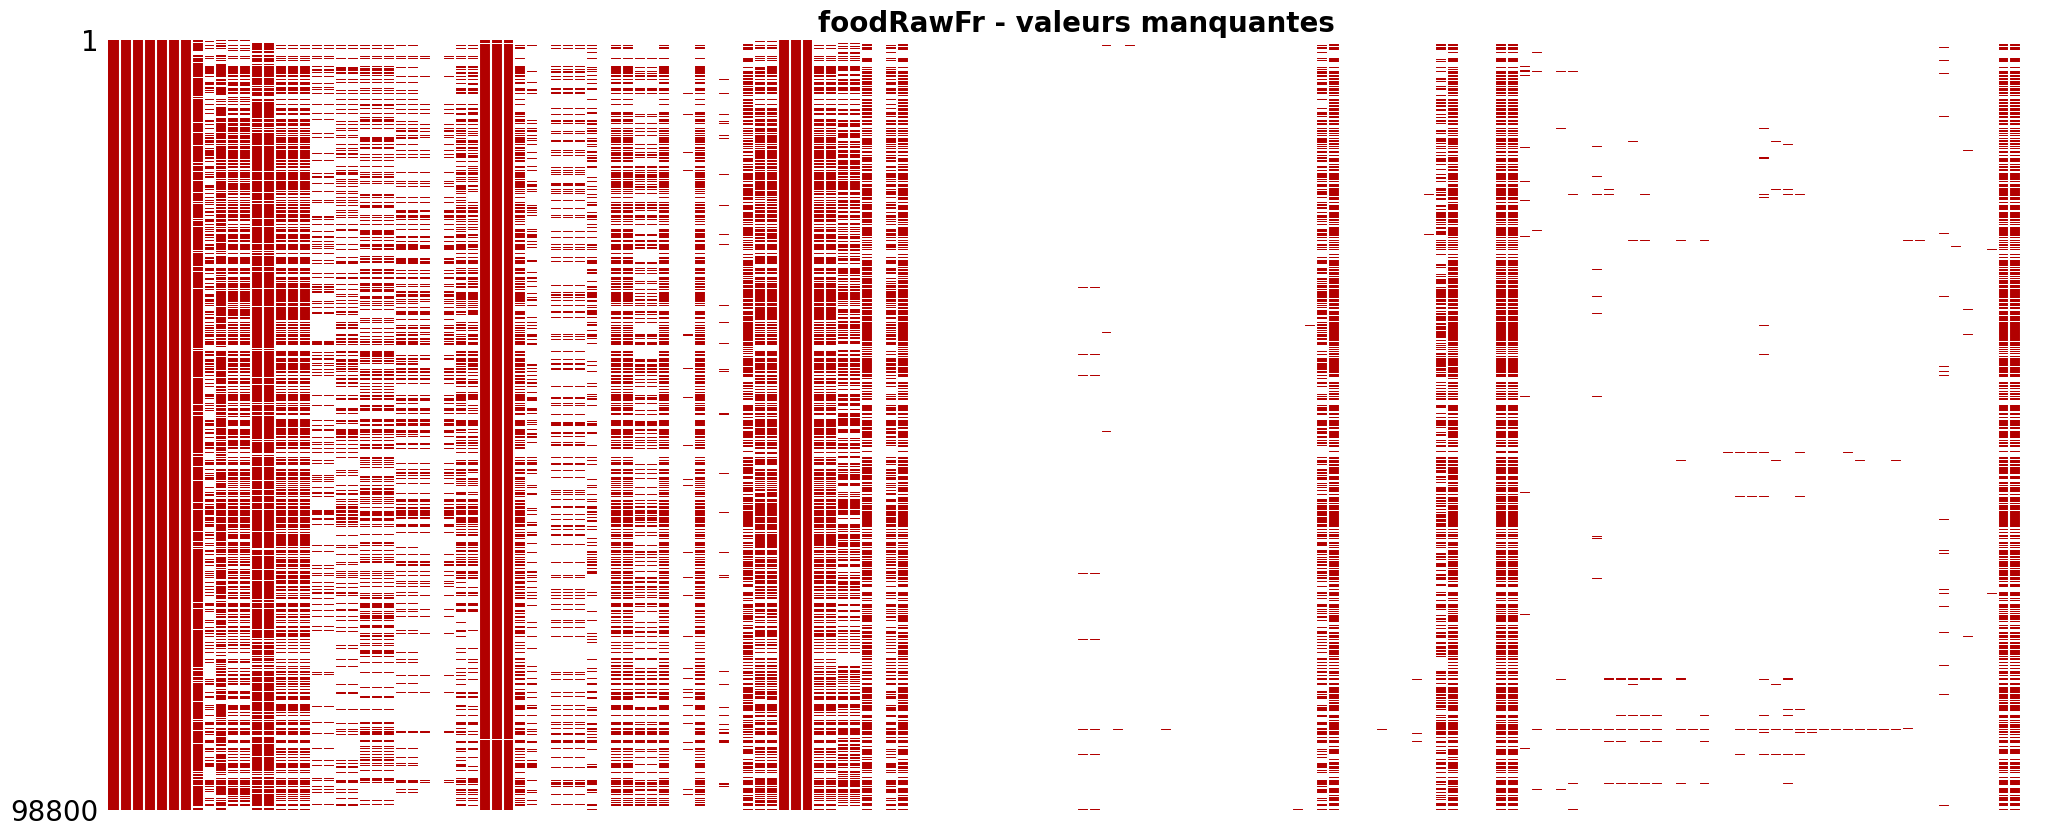

In [42]:
ms.matrix(foodRawFr,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodRawFr - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

Le dataset est globalement **très peu renseigné**.

Nous pouvons regarder ce qu'il en est des features qui nous intéressent pour calculer, théoriquement, un MyHealthScore :

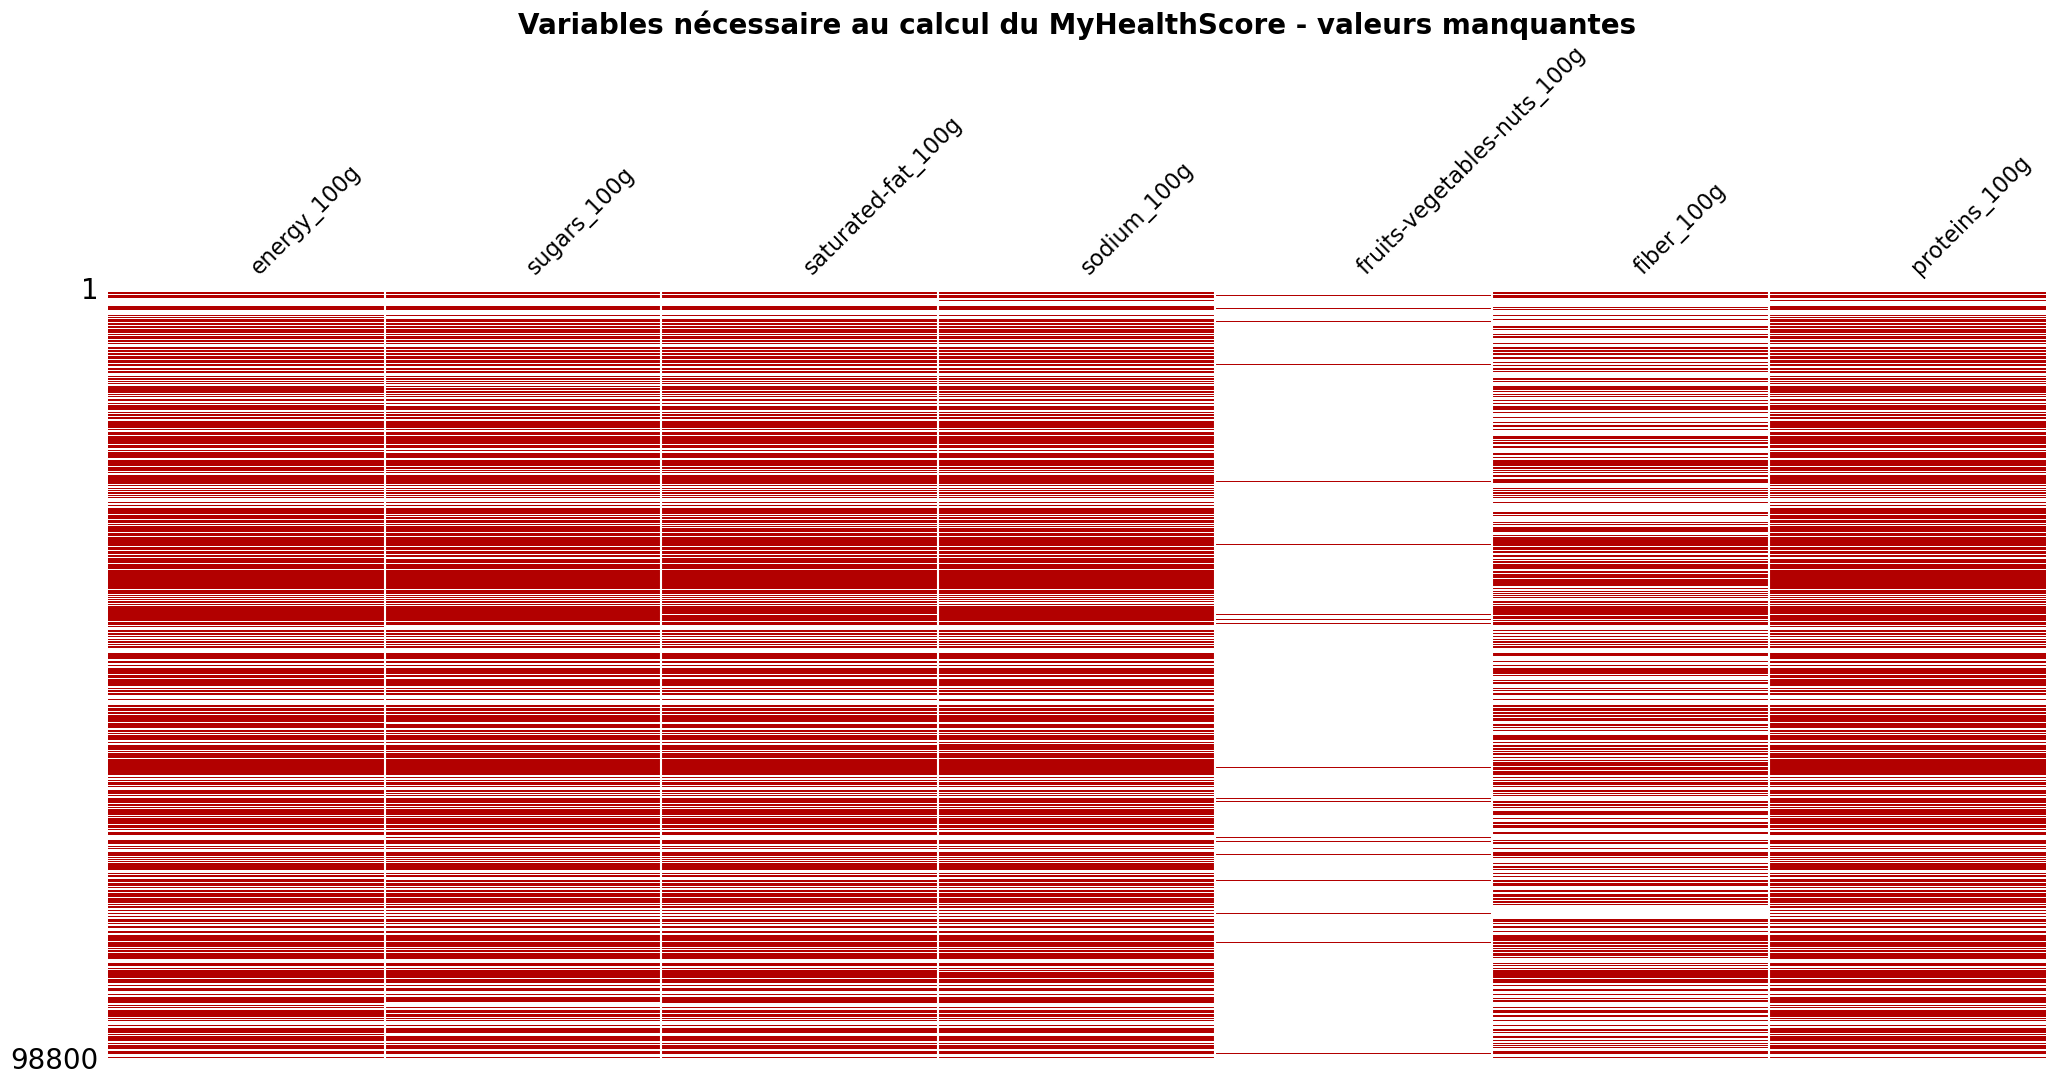

In [43]:
theoricalFeaturesNames=["energy_100g","sugars_100g","saturated-fat_100g","sodium_100g","fruits-vegetables-nuts_100g","fiber_100g","proteins_100g"]
ms.matrix(foodRawFr[theoricalFeaturesNames],color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("Variables nécessaire au calcul du MyHealthScore - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

Malheureusement la feature concernant les **fruits et légumes** est **très peu renseignée**...

Or celle-ci se révèle indispensable pour calculer un MyHealthScore reflétant correctement les recommandations médicales.

Par exemple, si l'on regarde les **préconisations hygiéno-ditétiques pour les personnes atteinte d'hypertension**, le site internet de la **CPAM indique** :
- sel : < 6g /j
- perdre du poids, soit via une IMC < 25 kg/m², soit en perdant 10% du poids initial
- activité physique, soit 30 min/j, soit 3x / semaine
- réduire consommation d'alcool
- augmenter la consommation de **fruits et légumes**
- réduire la consommation de graisses saturées
- arrêter le tabac

La construction d'un MyHealthScore devra donc passer par la prise en compte d'autres colonnes. Pour les déterminer, nous pourrons nous baser dans un premier temps sur le "taux de vide". Regardons ce que cela donne pour les colonnes `theoricalFeaturesNames` :

In [44]:
# percentage of null values in primal selected features :
(foodRawFr[theoricalFeaturesNames].isna().mean()*100).round(1).astype(str)+" %"

energy_100g                    34.5 %
sugars_100g                    36.6 %
saturated-fat_100g             36.8 %
sodium_100g                    36.6 %
fruits-vegetables-nuts_100g    97.0 %
fiber_100g                     53.7 %
proteins_100g                  34.8 %
dtype: object

Nous allons utiliser la fonction `dropEmptyCols`.
Nous avons d'ores et déjà fait une croix sur `fruits-vegetables-nuts_100g`. Basons-nous sur le taux de `fiber_100g` :

In [45]:
foodWithout_54=dropEmptyCols(foodRawFr,emptinessThreshold=0.54)

In [46]:
# check percentage of null values in foodWithout_54
(foodWithout_54.isna().mean().sort_values()*100).round(2).astype(str)+" %"

code                                         0.0 %
url                                          0.0 %
creator                                      0.0 %
created_t                                    0.0 %
last_modified_t                              0.0 %
last_modified_datetime                       0.0 %
created_datetime                             0.0 %
states                                      0.02 %
states_tags                                 0.02 %
states_fr                                   0.02 %
countries                                   0.28 %
countries_tags                              0.28 %
countries_fr                                0.28 %
product_name                                7.36 %
brands                                     12.29 %
brands_tags                                 12.3 %
quantity                                   27.66 %
pnns_groups_2                              31.95 %
pnns_groups_1                              34.14 %
energy_100g                    

N'ayant pas à notre disposition la teneur en fruits et légumes, nous pouvons nous baser sur le Nutri-Score, qui prend en compte celle-ci dans son calcul.

A partir du Nutri-Score, il sera possible dans le cadre du développement de l'application, de créer un MyHealthScore en adaptant les pondérations des autres valeurs nutritionnelles.

On peut donc sélectionner les variables suivantes pour notre analyse :
- `code`, `product_name` et `brands` pour identitifer les produits
- `nutrition-score-fr_100g` qui correspond au socre nutritionnel
- `nutrition_grade_fr` qui correspond au Nutri-Score, l'échelle graphique scindant le score nutritionnel en 5 classes A, B, C, D et E
- `energy_100g`
- `proteins_100g`
- `fiber_100g`
- `sodium_100g` et `salt_100g`, ("salt" est liée à "sodium" par un facteur 2.5. Nous nous servirons de cette variable pour un traitement en particulier, puis nous l'écarterons) 
- `sugars_100g` et `carbohydrates_100g`
- `saturated-fat_100g` et `fat_100g`
- `pnns_groups_2` et `pnns_groups_1` qui permettent de classifier les produits dans des catégories plus ou moins précises

In [47]:
# select work features
workFeatures=["code",
               "product_name",
               "brands",
               "pnns_groups_1",
               "pnns_groups_2",
               "nutrition-score-fr_100g",
               "nutrition_grade_fr",
               "salt_100g",
               "carbohydrates_100g",
               "fat_100g"]+theoricalFeaturesNames
workFeatures.remove("fruits-vegetables-nuts_100g")

In [48]:
foodRawLight = foodRawFr.copy()
foodRawLight = foodRawLight[workFeatures]
foodRawLight

code                product_name                 brands  \
0       0000000003087          Farine de blé noir        Ferme t'y R'nao   
46      0000000024600               Filet de bœuf                    NaN   
48      0000000027205                         NaN                    NaN   
106     0000000036252              Lion Peanut x2               Sunridge   
136     0000000039259                     Twix x2                    NaN   
...               ...                         ...                    ...   
320761  9906410000009   Roussette du Bugey (2011)     Roussette du Bugey   
320763       99111250          Thé vert Earl grey                Lobodis   
320764           9918  Cheese cake thé vert, yuzu                    NaN   
320765  9935010000003              Rillette d'oie  Sans marque,D.Lambert   
320770  9980282863788    Tomates aux Vermicelles                   Knorr   

         pnns_groups_1          pnns_groups_2  nutrition-score-fr_100g  \
0                  NaN                    NaN                      NaN   
46             unknown                unknown                      NaN   
48                 NaN                    NaN                      NaN   
106            unknown                unknown                     22.0   
136            unknown                unknown                      NaN   
...                ...                    ...                      ...   
320761             NaN    Alcoholic beverages                      NaN   
320763       Beverages  Non-sugared beverages                      2.0   
320764             NaN                    NaN                      NaN   
320765  Fish Meat Eggs         Processed meat                      NaN   
320770             NaN                    NaN                      NaN   

       nutrition_grade_fr  salt_100g  carbohydrates_100g  fat_100g  \
0                     NaN        NaN                 NaN       NaN   
46                    NaN        NaN                 NaN       NaN   
48                    NaN        NaN                 NaN       NaN   
106                     e    0.09652                70.0      20.0   
136                   NaN        NaN                 NaN       NaN   
...                   ...        ...                 ...       ...   
320761                NaN        NaN                 NaN       NaN   
320763                  c    0.02540                 0.5       0.2   
320764                NaN        NaN                 NaN       NaN   
320765                NaN        NaN                 NaN       NaN   
320770                NaN        NaN                 NaN       NaN   

        energy_100g  sugars_100g  saturated-fat_100g  sodium_100g  fiber_100g  \
0               NaN          NaN                 NaN          NaN         NaN   
46              NaN          NaN                 NaN          NaN         NaN   
48              NaN          NaN                 NaN          NaN         NaN   
106          1883.0         57.5                12.5        0.038         2.5   
136             NaN          NaN                 NaN          NaN         NaN   
...             ...          ...                 ...          ...         ...   
320761          NaN          NaN                 NaN          NaN         NaN   
320763         21.0          0.5                 0.2        0.010         0.2   
320764          NaN          NaN                 NaN          NaN         NaN   
320765          NaN          NaN                 NaN          NaN         NaN   
320770          NaN          NaN                 NaN          NaN         NaN   

        proteins_100g  
0                 NaN  
46                NaN  
48                NaN  
106               2.5  
136               NaN  
...               ...  
320761            NaN  
320763            0.5  
320764            NaN  
320765            NaN  
320770            NaN  

[98800 rows x 16 columns]

On peut afficher de nouveau la visualisation des valeurs manquantes :

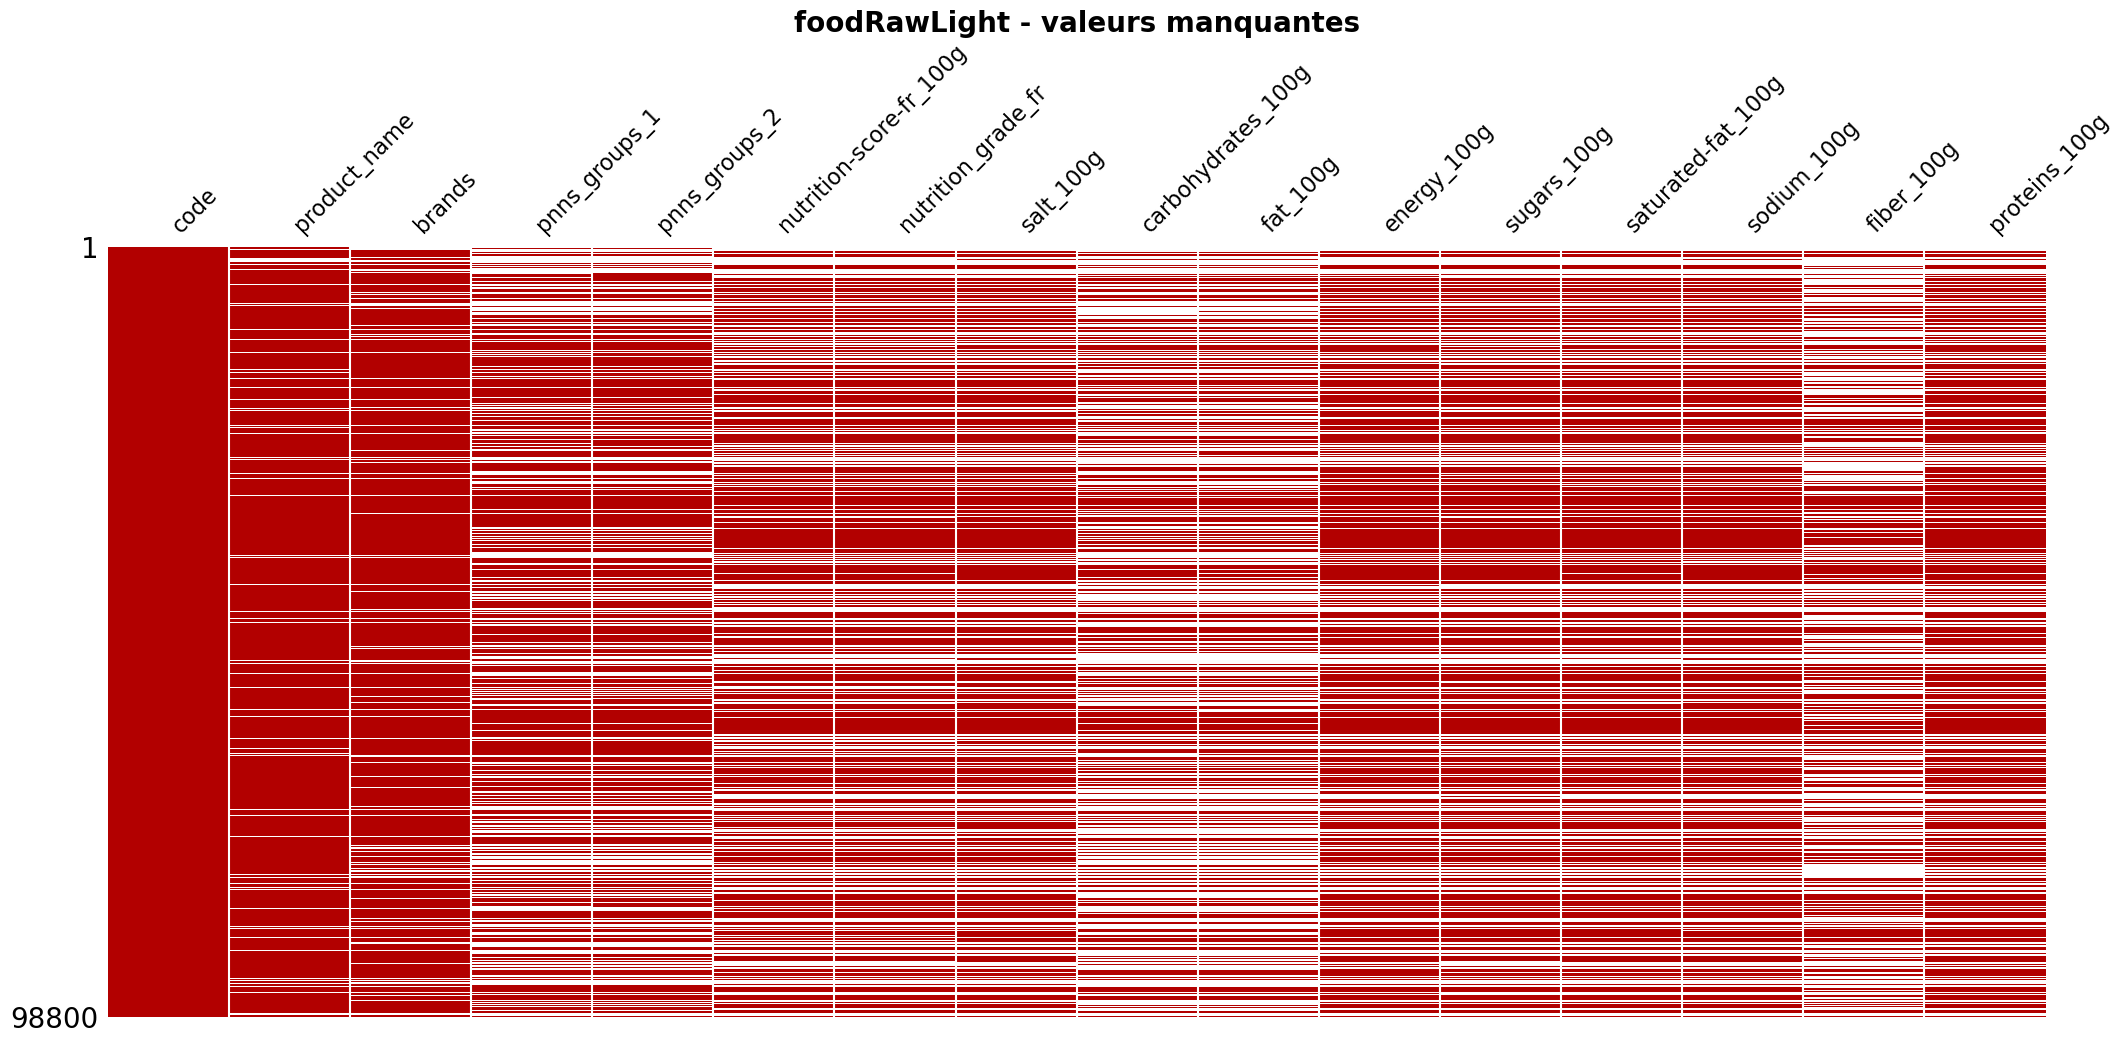

In [49]:
ms.matrix(foodRawLight,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodRawLight - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

# Partie 2 - Nettoyage<a class="anchor" id="P2"></a>

## P2.1. Nommage des colonnes<a class="anchor" id="P21"></a>

Pour faciliter le traitement, nous renommons certaines colonnes pour supprimer les "-" et les remplacer par des "_" :

In [50]:
# use only underscore for column names

foodRawLightUnder=foodRawLight.copy() # create a copy
foodRawLightUnder.rename(columns={col : col.replace("-","_") for col in foodRawLightUnder.columns}, # replace "-" by "_"
                         inplace=True
                        )
workFeatures=foodRawLightUnder.columns.tolist()

## P2.2. Éliminer les doublons<a class="anchor" id="P22"></a>

Pour repérer les produit présents deux fois, nous pouvons dans un premier temps regarder la colonne "code".

### P2.2.1. Des produits en double ? "code"<a class="anchor" id="P221"></a>

In [51]:
foodRawLightUnder.code.sample(5)

243479    3564707104609
181192         20711061
192628    3080920981983
264608    4260135129342
208549    3254474005468
Name: code, dtype: object

le format du code à l'air d'être une suite de 13 chiffres.
Cependant le type "object" de la Series interroge.

In [52]:
# looking to the lenght of "code" values for formatting issues
foodRawLightUnder.code.str.len().value_counts(dropna=False).sort_index()

1         2
2         1
3         2
4         6
5        10
6        32
7        38
8      6186
9         6
10       33
11       30
12       36
13    92329
14       51
15       23
16        3
17        1
22        1
24        4
25        1
31        1
32        2
40        1
41        1
Name: code, dtype: int64

Après quelques recherches, les deux formats les plus représentés correspondent aux systèmes EAN 8 et EAN 13 (EAN pour *European Article Numbering*). Ces deux systèmes sont les plus utilisés en Europe.

Nous faisons le choix de nous séparer des 285 produits aux codes barres non formatés EAN 8 ou 13 : l'usage principal du MyHealthScore se fera via l'application et le scan de code barre.

In [53]:
foodClean01=foodRawLightUnder.copy()
# keep only the values of "code" whose length is 8 or 13
foodClean01=foodClean01.loc[(foodClean01.code.str.len()==8)|(foodClean01.code.str.len()==13)]

Nous pouvons maintenant regarder s'il y a des produits en double :

In [54]:
#look for duplicates in column "code"
foodClean01.loc[foodClean01.code.duplicated(keep=False)]

Empty DataFrame
Columns: [code, product_name, brands, pnns_groups_1, pnns_groups_2, nutrition_score_fr_100g, nutrition_grade_fr, salt_100g, carbohydrates_100g, fat_100g, energy_100g, sugars_100g, saturated_fat_100g, sodium_100g, fiber_100g, proteins_100g]
Index: []

Il ne semble pas y avoir de produits différents utilisant le même code-barre.

Une autre manière de repérer les doublons et de regarder la colonne "product_name".

### P2.2.2. Des produits en double ? "product_name" <a class="anchor" id="P222"></a>

Nous n'avons que des produits au code-barre unique. Mais le même produit a pu être étiqueté avec 2 code-barres différents. Regardons.

In [55]:
foodClean01.product_name.value_counts()

Huile d'olive vierge extra        62
Mayonnaise                        54
Moutarde de Dijon                 49
Orange                            46
Spaghetti                         46
                                  ..
3 Œufs avec surprise               1
20 saucisses de Strasbourg         1
Gelée extra Mûre                   1
noir Eclats de fèves 72% cacao     1
Tomates aux Vermicelles            1
Name: product_name, Length: 74413, dtype: int64

Nous ne sommes pas assez précis. Nous ne pouvons pas considérer seulement "product_name" pour rechercher les doublons. Regardons également "brands".

### P2.2.3. Des produits en double ? "product_name" ET "brands"<a class="anchor" id="P223"></a>

Regardons si des noms de produits sont présents plusieurs fois sous la même marque :

In [56]:
# look in non null values for "product_name","brands" and "code" for products with the same name and brand :
foodClean01[["product_name","brands",'code']].loc[foodClean01[["product_name","brands",'code']].notna().all(axis=1)].groupby(['product_name',"brands"]).count().sort_values("code",ascending=False).head(10)

code
product_name                      brands               
Coca-Cola                         Coca-Cola          20
Pom'potes                         Materne            15
Nutella                           Ferrero,Nutella    14
Orangina                          Orangina           14
Nesquik                           Nestlé,Nesquik     11
Perrier                           Perrier            11
Auchan                            Auchan             10
Nutella                           Ferrero            10
Mousline                          Maggi               9
Mayonnaise à la moutarde de Dijon Carrefour           9

Il y a donc des doublons. Ceux-ci peuvent être expliqués par :
- un même produit rentré plusieurs fois sous des codes différents
- un même produit avec des quantités différentes (un pack de 6 bouteilles versus une bouteille seule)

Le score n'a pas vocation à prendre en compte la quantité. Ce sont les qualités intrinsèques du produit, pour 100g en l'occurrence, qui nous intéressent.

Nous allons donc supprimer ces doublons.

In [57]:
foodClean02=foodClean01.copy()
foodClean02=foodClean02.loc[
    (foodClean02[["product_name","brands"]].isna().any(axis=1)) # be carefull to keep the rows where "product_name" or "brands" is NaN
    | # or :
    ~(foodClean02[["product_name","brands"]].duplicated(subset=["product_name","brands"],keep='last')) # non duplicated values for both features
]

In [58]:
print("On a retiré ",foodClean01.shape[0]-foodClean02.shape[0]," produits considérés comme doublons")

On a retiré  3105  produits considérés comme doublons


## P2.3. Traiter "pnns_groups_1" et "pnns_groups_2"<a class="anchor" id="P23"></a>

### P2.3.1. Uniformiser le Format<a class="anchor" id="P231"></a>

Regardons les modilités de "pnns_groups_1" et "pnns_groups_2" :

In [59]:
foodClean02.pnns_groups_1.value_counts(dropna=False).index.sort_values()

Index([              'Beverages',    'Cereals and potatoes',
               'Composite foods',          'Fat and sauces',
                'Fish Meat Eggs',   'Fruits and vegetables',
       'Milk and dairy products',            'Salty snacks',
                 'Sugary snacks',    'cereals-and-potatoes',
         'fruits-and-vegetables',           'sugary-snacks',
                       'unknown',                       nan],
      dtype='object')

In [60]:
foodClean02.pnns_groups_2.value_counts(dropna=False).index.sort_values()

Index([             'Alcoholic beverages',                       'Appetizers',
       'Artificially sweetened beverages',               'Biscuits and cakes',
                                  'Bread',                'Breakfast cereals',
                                'Cereals',                           'Cheese',
                     'Chocolate products',                   'Dairy desserts',
                   'Dressings and sauces',                     'Dried fruits',
                                   'Eggs',                             'Fats',
                       'Fish and seafood',                     'Fruit juices',
                          'Fruit nectars',                           'Fruits',
                              'Ice cream',                          'Legumes',
                                   'Meat',                  'Milk and yogurt',
                  'Non-sugared beverages',                             'Nuts',
                         'One-dish meals',          

Le format n'a pas l'air unique :
- certaines modalités ont des **tirets séparant les mots**
- certaines modalités ne commencent **pas par une majuscule**
- il y a deux formats différents pour les valeurs manquantes : **"unknown"** et **np.nan**

Traitons cela :

In [61]:
pnns_cols = ["pnns_groups_1","pnns_groups_2"]

# capitalize and replace "-" with " "
foodClean02[pnns_cols] = foodClean02[pnns_cols].applymap(
    lambda x : str(x).capitalize().replace("-"," ") if pd.notna(x) else np.nan 
)


# replace "Unknown" by np.nan
foodClean02[pnns_cols] = foodClean02[pnns_cols].applymap(
    lambda x : np.nan if x == "Unknown" else x
)

### P2.3.2. Traiter simplement quelques valeurs manquantes ?<a class="anchor" id="P232"></a>

"pnns_groups_2" représentant des catégories de produits **plus "précises"** que "pnns_groups_1", on peut regarder s'il existe des produits pour lesquels :
- on ne connaît **pas** "pnns_groups_1"
- on **connaît** "pnns_groups_2"

Pour chacune de ces catégories de "pnns_groups_2", nous pourrons regarder les produits concernés pour connaître leurs valeurs de "pnns_groups_1". Si elles sont uniques nous pourrons imputer les valeurs manquantes de "pnns_groups_1" déterminées plus haut.

In [62]:
# look for "pnns_groups_2" values with "pnns_groups_1" missing
mask1na2not = foodClean02.pnns_groups_1.isna()&foodClean02.pnns_groups_2.notna()
foodClean02[pnns_cols].loc[mask1na2not].pnns_groups_2.value_counts()

Alcoholic beverages    2017
Tripe dishes             62
Name: pnns_groups_2, dtype: int64

In [63]:
# keep these categories in a list
pnns_2_cats = foodClean02[pnns_cols].loc[mask1na2not].pnns_groups_2.unique().tolist()

Vérifions maintenant s'il existe des produits dont le "pnns_groups_2" est 'Alcoholic beverages' ou 'Tripe dishes" et où on a un "pnns_groups_1" :

In [64]:
mask = (foodClean02[pnns_cols]["pnns_groups_2"].isin(pnns_2_cats))&(foodClean02[pnns_cols]["pnns_groups_1"].notna())
foodClean02[pnns_cols].loc[mask]

Empty DataFrame
Columns: [pnns_groups_1, pnns_groups_2]
Index: []

On ne peut pas imputer en se basant sur des valeurs connues...

On va donc changer de stratégie et choisir des catégories de "pnns_groups_1" qui correspondent **logiquement** à 'Alcoholic beverages' et 'Tripe dishes' :

 **'Beverages'**, <-- 'Alcoholic beverages'<br/>
 'Cereals and potatoes',<br/>
 'Composite foods',<br/>
 'Fat and sauces',<br/>
 '**Fish meat eggs'**, <-- 'Tripe dishes'<br/>
 'Fruits and vegetables',<br/>
 'Milk and dairy products',<br/>
 'Salty snacks',<br/>
 'Sugary snacks'
 
Il ne nous reste plus qu'à vérifier que les valeurs nutritionnelles sont à peu près comparables. Pour cela nous allons regarder la médiane :

In [65]:
# Compare numerical values of  'Beverages' and 'Alcoholic beverages', and 'Fish meat eggs' and  'Tripe dishes'

# create lists...
pnns_1_cats = ['Beverages','Fish meat eggs'] # ... of our selected "pnns_groups_1" values
numColsNames = foodClean02.select_dtypes('float64').columns.tolist() # ... of numericales values

# initiate dataframes to store medians
compareMediansBev = pd.DataFrame()
compareMediansTrip = pd.DataFrame()
lDf=[compareMediansBev,compareMediansTrip]

# store 

for col in pnns_cols :
    for df,cat1,cat2 in zip(lDf,pnns_1_cats,pnns_2_cats) :
        df["dataset"]=foodClean02[numColsNames].median()
        df[cat2+" (pnns2)"]=foodClean02.loc[foodClean02.pnns_groups_2==cat2,numColsNames].median()
        df[cat1+" (pnns1)"]=foodClean02.loc[foodClean02.pnns_groups_1==cat1,numColsNames].median()

display(compareMediansTrip,compareMediansBev)

dataset  Tripe dishes (pnns2)  \
nutrition_score_fr_100g     9.000000             11.500000   
salt_100g                   0.560000              1.100000   
carbohydrates_100g         14.900000              1.900000   
fat_100g                    7.000000             11.500000   
energy_100g              1037.000000            743.000000   
sugars_100g                 4.000000              1.550000   
saturated_fat_100g          2.000000              5.200000   
sodium_100g                 0.220472              0.433071   
fiber_100g                  1.400000              1.200000   
proteins_100g               6.000000             12.000000   

                         Fish meat eggs (pnns1)  
nutrition_score_fr_100g                  10.000  
salt_100g                                 1.778  
carbohydrates_100g                        0.900  
fat_100g                                 11.000  
energy_100g                             791.000  
sugars_100g                               0.600  
saturated_fat_100g                        2.700  
sodium_100g                               0.700  
fiber_100g                                0.100  
proteins_100g                            19.200

dataset  Alcoholic beverages (pnns2)  \
nutrition_score_fr_100g     9.000000                     8.000000   
salt_100g                   0.560000                     0.010000   
carbohydrates_100g         14.900000                     3.150000   
fat_100g                    7.000000                     0.000000   
energy_100g              1037.000000                   181.000000   
sugars_100g                 4.000000                     0.500000   
saturated_fat_100g          2.000000                     0.000000   
sodium_100g                 0.220472                     0.003937   
fiber_100g                  1.400000                     0.000000   
proteins_100g               6.000000                     0.400000   

                         Beverages (pnns1)  
nutrition_score_fr_100g           6.000000  
salt_100g                         0.010000  
carbohydrates_100g               10.000000  
fat_100g                          0.000000  
energy_100g                     185.000000  
sugars_100g                       9.300000  
saturated_fat_100g                0.000000  
sodium_100g                       0.003937  
fiber_100g                        0.100000  
proteins_100g                     0.300000

La logique est bien respectée :
- La catégorie `Fish meat eggs` de "pnns_groups_1" est proche de `Tripe dishes` de "pnns_groups_1".
- De la même manière la catégorie `Beverages` de "pnns_groups_1" est proche de `Alcoholic beverages` de "pnns_groups_1".

On impute donc :

In [66]:
for i in range(2) :
    foodClean02.loc[(mask1na2not)&(foodClean02.pnns_groups_2==pnns_2_cats[i]),"pnns_groups_1"]=pnns_1_cats[i]

## P2.4. Traiter les outliers<a class="anchor" id="P24"></a>

On sait que les outliers ont un impact négatif sur la moyenne et l'écart type empiriques de nos variables. Avant de nous concentrer sur l'imputation des valeurs manquantes, il faut d'abord traiter ces outliers. Regardons dans un premiers temps les valeurs min et max des variables numériques :

In [67]:
foodClean02.describe()

nutrition_score_fr_100g     salt_100g  carbohydrates_100g  \
count             59076.000000  60197.000000        45154.000000   
mean                  8.676366      1.162005           27.839665   
std                   9.038369      4.261100           27.348395   
min                 -15.000000      0.000000            0.000000   
25%                   1.000000      0.080000            4.100000   
50%                   9.000000      0.560000           14.900000   
75%                  15.000000      1.250000           53.000000   
max                  40.000000    211.000000          190.000000   

           fat_100g   energy_100g   sugars_100g  saturated_fat_100g  \
count  45585.000000  6.215600e+04  60145.000000        60007.000000   
mean      13.293629  1.174376e+03     13.396842            5.451226   
std       16.752498  1.308400e+04     19.010655            8.554641   
min        0.000000  0.000000e+00     -0.100000            0.000000   
25%        1.400000  4.310000e+02      1.000000            0.300000   
50%        7.000000  1.037000e+03      4.000000            2.000000   
75%       21.000000  1.648000e+03     17.860000            7.500000   
max      380.000000  3.251373e+06    105.000000          210.000000   

        sodium_100g    fiber_100g  proteins_100g  
count  60194.000000  44059.000000   61881.000000  
mean       0.457503      2.576606       7.787648  
std        1.677578      4.682310       7.889584  
min        0.000000      0.000000       0.000000  
25%        0.031496      0.000000       1.900000  
50%        0.220472      1.400000       6.000000  
75%        0.492126      3.200000      11.000000  
max       83.000000    178.000000     100.000000

On peut remarquer que :
- il y a des valeurs **négatives** pour les features "nutrition_score_fr_100g", ce qui est normal, et pour **"sugars_100g"**, ce qui devra être traîté
- les valeurs maximales pour les valeurs nutritionnelles " *..._100g* " classiques (hors score nutritionnel et énergie) comportent des irrégularités car **certaines sont supérieures à 100g**...
- après quelques recherches, la quantité maximale d'énergie pour 1g est de 37 kJ/g. Donc théoriquement les valeurs de la colonne **"energy_100g" ne peuvent pas dépasser 3700**, là où le maximum est de 3 251 373... L'écart-type est du coup vraiment impacté : 13084...

Pour la suite de l'étude, on passera la plupart de ces valeurs en valeur manquante.

D'autres opérations de nettoyage seront également menées, aussi basées sur le contexte métier.

### P2.4.1. Masse de sucre négative<a class="anchor" id="P241"></a>

In [68]:
# replace negative "sugars_100g" with null values 

foodClean03=foodClean02.copy()
foodClean03.loc[foodClean03.sugars_100g<0,"sugars_100g"]=np.nan

In [69]:
print("On a traité ",((foodClean03.notna())!=(foodClean02.notna())).sum().sum()," produit dont le poids en sucre était négatif")

On a traité  1  produit dont le poids en sucre était négatif


### P2.4.2. Masse de constituant pour 100g supérieure à 100g <a class="anchor" id="P242"></a>


Sélectionnons tout d'abord les features à traiter :

In [70]:
# first, look a columns types
foodClean03.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [71]:
# select numerical columns
componentFeatures=foodClean03.select_dtypes("float64").columns.tolist()
componentFeatures

['nutrition_score_fr_100g',
 'salt_100g',
 'carbohydrates_100g',
 'fat_100g',
 'energy_100g',
 'sugars_100g',
 'saturated_fat_100g',
 'sodium_100g',
 'fiber_100g',
 'proteins_100g']

In [72]:
# exclude "non component" columns
componentFeatures.remove("nutrition_score_fr_100g")
componentFeatures.remove("energy_100g")

In [73]:
# search for "..._100g" > 100
foodClean04=foodClean03.copy()
foodClean04.loc[(foodClean04[componentFeatures]>100).any(axis=1),componentFeatures]

salt_100g  carbohydrates_100g  fat_100g  sugars_100g  \
155609        NaN               164.0       0.0         72.7   
202571    0.14000               104.0       0.0        104.0   
232239  211.00000                47.8      23.0         26.7   
233372  125.00000                 0.0       0.0          0.0   
234726    1.30048               106.0      52.0         52.0   
239347        NaN               105.0       NaN        105.0   
245311    9.33000               190.0     380.0         22.7   
260599    0.10000               103.5       1.0        103.5   
298897    0.37000                59.0      29.0         58.0   
305054    0.01000                70.0     105.0          2.5   
315621    0.42672               100.8       0.0        100.8   
317635    0.00000               139.0       0.0         41.5   

        saturated_fat_100g  sodium_100g  fiber_100g  proteins_100g  
155609                0.00          NaN         NaN            0.0  
202571                0.00     0.055100       0.000            0.0  
232239                3.33    83.000000       0.741            6.3  
233372                0.00    49.212598       0.000            0.0  
234726               35.50     0.512000       3.000           10.0  
239347                 NaN          NaN         NaN            NaN  
245311              210.00     3.670000       0.000            0.0  
260599                0.10     0.039370         NaN            1.0  
298897               18.00     0.145669     178.000            6.3  
305054                0.30     0.003937         NaN           12.0  
315621                0.00     0.168000       0.000            0.0  
317635                0.00     0.000000       0.000            5.0

In [74]:
# replace "..._100g" > 100 with null value
foodClean04[componentFeatures]=foodClean04[componentFeatures].mask(foodClean04[componentFeatures]>100,np.nan)

In [75]:
print("On a passé en valeur manquante ",
      ((foodClean03.notna())!=(foodClean04.notna())).sum().sum(),
      " masses qui étaient supérieures à 100g")

On a passé en valeur manquante  18  masses qui étaient supérieures à 100g


### P2.4.3. Énergie pour 100g supérieure à 3700 kJ <a class="anchor" id="P243"></a>

In [76]:
# search products with energy_100g > 3700

foodClean05=foodClean04.copy()
foodClean05.loc[(foodClean05.energy_100g>3700),["product_name","energy_100g"]].sort_values("energy_100g").sample(15)

product_name  energy_100g
253732  Huile De Coco Vierge Bio - 250ML - Comptoirs &...       3736.0
223318  Huiles vierge biologique de Colza - première p...      15481.0
217608               Huile d'olive vierge extra bio Puget       3766.0
229618                          Boulgour Bio Traditionnel       6134.0
179179                                 Lot De 4 Baguettes       4184.0
237249  Château Virant Famille Cheylan Aix-en-Provence...       3768.0
223339                                 Huile Pour Friture       3766.0
248813                        Huile d'Olive, vierge extra       3766.0
224442                                   Croûtons à l'ail       9050.0
249101  Légume Noisettes Carottes, 500 Grammes, Marque...     182764.0
217576                               Huile d'olive Isio 4       3766.0
226179                         Huile d'Olive Vierge extra       3766.0
226198                             Huile de Sésame grillé       3766.0
254205                         Huile D'olive Vierge Extra       3766.0
223362                  HUILE D'OLIVE EXTRA FRUITEE POCHE       3766.0

Cette échantillons nous indique que les produits en question semblent être majoritairement des huiles. Après quelques recherches, on sait que ces produits ont une valeur énergétique de 900 kcal (3700 kJ). On va donc appliquer deux traitement différents :
- imputer à 3700 pour les produits dont le nom contient "huile"
- imputer à NaN pour les autres produits concernés

In [77]:
# mask for "energy_100g" > 3700 and product is an oil
above3700andOilMask = ((foodClean05.energy_100g>3700)
                &(foodClean05.product_name.notna())
                &(
                    (foodClean05.product_name.str.find("Huile")!=-1) 
                    |(foodClean05.product_name.str.find("huile")!=-1) 
                    |(foodClean05.product_name.str.find(" Oil ")!=-1) 
                    |(foodClean05.product_name.str.find(" oil ")!=-1)
                )
               )

In [78]:
# replace "energy_100g" with 3700
foodClean05.loc[above3700andOilMask,"energy_100g"]=3700

In [79]:
print("On a passé à 3700 kJ ",above3700andOilMask.sum()," valeurs énergétiques d'huiles qui étaient supérieures à 3700 kJ")

On a passé à 3700 kJ  131  valeurs énergétiques d'huiles qui étaient supérieures à 3700 kJ


In [80]:
foodClean05.loc[(foodClean05.energy_100g>3700),"energy_100g"]=np.nan

In [81]:
print("On a passé à valeur manquante ",
      ((foodClean04.notna())!=(foodClean05.notna())).sum().sum(),
      " valeurs énergétiques restantes, qui étaient supérieures à 3700 kJ")

On a passé à valeur manquante  123  valeurs énergétiques restantes, qui étaient supérieures à 3700 kJ


### P2.4.4. Sommes des masses des constituants PRINCIPAUX VS 100g<a class="anchor" id="P244"></a>

On peut aussi s'interroger sur les constituants dans leur ensemble. En effet, la somme des différents constituants "..._100g" ne devrait pas faire plus de 100g.

La question est de savoir quels constituants sommer. En effet certains sont des sous-produits d'autres constituants...

Après un peu de recherche (source https://ciqual.anses.fr/#/cms/questions-reponses/node/23), les "macro-constituants", dont la somme est censée être égale à 100, sont les suivants : **protéines, glucides totaux, lipides, alcool, cendres et eau**. Balayons ces différents éléments :

- proteins_100g : ok
- carbohydrates_100g : ok
- fat_100g : ok
- alcohol_100g : a été retiré du dataframe... Nous pouvons le réintégrer provisoirement
- cendres : correspondent au minéraux. Il ne nous reste que le sodium (sel)
- eau : ne fait pas partie de nos données

Nous allons nous concentrer sur les composants principaux à notre disposition. **Si la somme de ces masses est supérieure à 100g, et ce même sans les informations manquantes (on pense notamment à l'eau), alors nous écarterons le produit en question.**

In [82]:
# main nutrients column names 
macroNutCols=[
    'alcohol_100g',
    'proteins_100g',
    'carbohydrates_100g',
    'fat_100g',
    'salt_100g'
]

# create a dataframe with "alcohol_100g" back in
foodClean_WithAlcohol=foodClean05.copy()
foodClean_WithAlcohol['alcohol_100g']=foodRaw.loc[foodClean_WithAlcohol.index,"alcohol_100g"]

In [83]:
# compute the sum and put it in a Series

foodClean_WithAlcohol["sumOfMacro"]=foodClean_WithAlcohol[macroNutCols].sum(axis=1)
foodClean_WithAlcohol["sumOfMacro"]

0          0.00000
46         0.00000
48         0.00000
106       92.59652
136        0.00000
            ...   
320760     0.00000
320761    12.00000
320763     1.22540
320765     0.00000
320770     0.00000
Name: sumOfMacro, Length: 95410, dtype: float64

In [84]:
# create au mask for "sumOfMacro" > 100
mask_MacroAbove100=foodClean_WithAlcohol["sumOfMacro"]>100
# look at concerned products
foodClean_WithAlcohol.loc[mask_MacroAbove100,macroNutCols+["sumOfMacro"]].sort_values("sumOfMacro")

alcohol_100g  proteins_100g  carbohydrates_100g  fat_100g  salt_100g  \
204888           0.0           0.00                 0.0     100.0    0.00254   
184775           NaN           0.50                99.0       0.5    0.01000   
315944           NaN           0.50                99.0       0.5    0.01000   
210332           NaN           0.02                 0.0     100.0    0.00000   
223303           NaN           0.00                 0.0     100.0    0.02500   
...              ...            ...                 ...       ...        ...   
285429           NaN         100.00                 NaN       NaN   50.00000   
177924           NaN           5.40                69.4      87.0    0.38000   
197179           NaN          48.10                97.7      21.9        NaN   
286048           NaN          90.00                49.0      39.0    0.01000   
198798           NaN          96.00                 NaN       NaN  100.00000   

        sumOfMacro  
204888   100.00254  
184775   100.01000  
315944   100.01000  
210332   100.02000  
223303   100.02500  
...            ...  
285429   150.00000  
177924   162.18000  
197179   167.70000  
286048   178.01000  
198798   196.00000  

[130 rows x 6 columns]

Certaines sommes >100 ne le sont que très légèrement.

Nous allons donc :
- fixer un seuil sur la somme **en deça** duquel nous ne ferons que **corriger** les masses
- **remplacer** les masses **par nan** seulement si la sommes est **au dessus** du seuil

In [85]:
# create a 5% threshold for "sumOfMacro"
above100Threshold = 100*1.05

# create a mask
maskUnderThreshold = foodClean_WithAlcohol["sumOfMacro"]<above100Threshold

# keep the concerned index
indexUnderThreshold=foodClean_WithAlcohol.loc[mask_MacroAbove100&maskUnderThreshold,macroNutCols+["sumOfMacro"]].index

# adjust the "..._100g" values so the sum is under 100
foodClean06=foodClean05.copy() # create copy
macroNutCols.remove('alcohol_100g') # remove 'alcohol_100g' from the macroNutCols list
foodClean06.loc[indexUnderThreshold,macroNutCols]=(foodClean06.loc[indexUnderThreshold,macroNutCols].
                                                   multiply(100/foodClean_WithAlcohol.loc[indexUnderThreshold,"sumOfMacro"],
                                                            axis=0)
                                                  )

In [86]:
print("On a ajusté les masses des composants principaux de ",
      len(indexUnderThreshold),
      " produits afin que leur somme ne dépasse pas 100g"
     )

On a ajusté les masses des composants principaux de  86  produits afin que leur somme ne dépasse pas 100g


In [87]:
# for sums above threshold, replace ".._100g" values with np.nan

# find the index
indexAboveThreshold = foodClean_WithAlcohol.loc[mask_MacroAbove100&(~maskUnderThreshold),macroNutCols+["sumOfMacro"]].index

# replace the "..._100g" values with np.nan
foodClean06.loc[indexAboveThreshold,macroNutCols]=np.nan

In [88]:
print("On a passé à valeur manquante ",
      ((foodClean05.notna())!=(foodClean06.notna())).sum().sum(),
      " masses restantes, dont la somme dépassait le seuil fixé")

On a passé à valeur manquante  164  masses restantes, dont la somme dépassait le seuil fixé


Maintenant que nous avons utilisé "Salt_100g", **nous pouvons nous en séparer**. Vérifions tout de même di elle pourrait servir à imputer "sodium_100g" :

In [89]:
# check if there are products with null values for "salt" and non-null value for "sodium", and vice versa
foodSaltAndNotSodium=foodClean06[["salt_100g","sodium_100g"]].loc[(foodClean06.salt_100g.notna())&(foodClean06.sodium_100g.isna())]
foodSaltAndNotSodium

salt_100g  sodium_100g
192840     0.1016          NaN
254025     0.0000          NaN
282383     0.0254          NaN

Il n'y a que trois valeurs. Imputons-les tout de même rapidement :

In [90]:
# impute these 3 "sodium_100g" null values with "salt_100g"  divided by 2.5
foodClean06.loc[foodSaltAndNotSodium.index,"sodium_100g"]=foodClean06.loc[foodSaltAndNotSodium.index,"salt_100g"]/2.5

In [91]:
# remove "salt_100g"
componentFeatures.remove("salt_100g")

In [92]:
workFeatures.remove("salt_100g")

In [93]:
foodClean06=foodClean06[workFeatures]

### P2.4.5. Masse d'un sous-composant > macro-composant<a class="anchor" id="P245"></a>

Sur le même principe, un sous-produit ne devrait pas avoir une masse supérieure à celle du produit principal.

Si l'on se concentre sur nos features, voici les comparaisons à mener :
- "sugars_100g" > "carbohydrates_100g"
- "saturated_fat_100g" > "fat_100g"

In [94]:
# create masks with subcomponent > main component

thresholdRate=1.10
mask_SatfatAboveFat=(
    (foodClean06['saturated_fat_100g']>foodClean06["fat_100g"]*thresholdRate)
     &(foodClean06["fat_100g"].notna())
)
    

mask_SugarAboveCarbo=(
    (foodClean06['sugars_100g']>foodClean06['carbohydrates_100g']*thresholdRate)
    &(foodClean06['carbohydrates_100g'].notna())
)

In [95]:
foodClean06.loc[mask_SatfatAboveFat,['saturated_fat_100g',"fat_100g","product_name"]]

saturated_fat_100g  fat_100g  \
6570                   1.0       0.0   
54995                 15.0       5.0   
57332                  0.9       0.0   
59062                  0.1       0.0   
99205                  0.1       0.0   
...                    ...       ...   
302974                 0.5       0.3   
303082                 0.5       0.0   
305772                 1.6       0.0   
315953                 0.1       0.0   
317148                 2.0       0.0   

                                             product_name  
6570     Algues Wakame Pour Soupe Ou Salade WEL-PAC 56.7G  
54995                    Malt O Meal Cereal Coco Roos 23.  
57332   Mae Ploy Chilli Sauce Sweet For Chicken - 25fl...  
59062                                 Vinaigre Pour Sushi  
99205                            Panda Brand Oyster Sauce  
...                                                   ...  
302974                                   Tic Tac - Menthe  
303082                                     Tic Tac Menthe  
305772                                          Buongrano  
315953                     Lipton Alps 20X1.1 GR, 1 Boîte  
317148                        sweet sour sauce thai pride  

[75 rows x 3 columns]

In [96]:
foodClean06.loc[mask_SugarAboveCarbo,['sugars_100g',"carbohydrates_100g","product_name"]]

sugars_100g  carbohydrates_100g                        product_name
149836         15.0                6.25                         Alo exposed
177460         48.6                7.05     Favorina, Haselnuss Nougat Eier
178306          3.9                3.50           Fromage blanc 20 % nature
178588          2.2                1.72          Foie gras de canard entier
179979          3.0                2.00                        Chèvre frais
...             ...                 ...                                 ...
305772         20.5                0.00                           Buongrano
310167          0.3                0.10                          Chiffonade
312063          2.0                1.60  Filets d'anchois à l'huile d'olive
315480         26.0               23.00         Ben & Jerry's - Fairly Nuts
316996         20.0                2.22         Crème De Coco Uht AROY-D 1L

[65 rows x 3 columns]

In [97]:
# replace values with NaN
foodClean07=foodClean06.copy()
foodClean07.loc[mask_SatfatAboveFat,["fat_100g"]]=np.nan
foodClean07.loc[mask_SugarAboveCarbo,['carbohydrates_100g']]=np.nan

In [98]:
print("On a passé à valeur manquante ",
      ((foodClean07.notna())!=(foodClean06.notna())).sum().sum(),
      " masses de composants incohérentes entre elles")

On a passé à valeur manquante  140  masses de composants incohérentes entre elles


### P2.4.6. Traitement des outliers, impact sur la moyenne et l'écart-type<a class="anchor" id="P246"></a>

La moyenne est l'écart-type sont sensibles aux outliers. Nous pouvons regarder si les traitements précédents ont eu un effet positif.

Pour cela nous allons étudier l'évolution de ces statistiques au fil des étapes de nettoyage.

In [99]:
# put the different foodClean## in a list
listFoodCleanDfs = [
    foodClean02,
    foodClean03,
    foodClean04,
    foodClean05,
    foodClean06,
    foodClean07
]

# list of names of numerical features
numericalFeatureNames=foodClean07.select_dtypes("float64").columns.tolist()
numericalFeatureNames.remove("nutrition_score_fr_100g")
numericalFeatureNames.remove("energy_100g")
numericalFeatureNames.remove("sodium_100g")
numericalFeatureNames.append("sodium_100g")
numericalFeatureNames.append("energy_100g")
# put "sodium_100g" and "energy_100g" at the end of the list

# list of lists to store the empirical means of each numerical feature, for each cleaned dataframe
listOfMeans=[
    [listFoodCleanDfs[i][col].mean() for col in  numericalFeatureNames] 
    for i in range(len(listFoodCleanDfs))
]

# list of lists to store the empirical stds of each numerical feature, for each cleaned dataframe
listOfStds=[
    [listFoodCleanDfs[i][col].std(ddof=1) for col in  numericalFeatureNames] 
    for i in range(len(listFoodCleanDfs))
] 

In [100]:
# lists to store the evolution between each cleaning stage
listEvolOfStd=[
    [(listOfStds[i+1][idxcol]-listOfStds[i][idxcol])/listOfStds[i][idxcol] for idxcol in range(len(numericalFeatureNames))] 
    for i in range(len(listFoodCleanDfs)-1)
]

listEvolOfMean=[
    [(listOfMeans[i+1][idxcol]-listOfMeans[i][idxcol])/listOfMeans[i][idxcol] for idxcol in range(len(numericalFeatureNames))] 
    for i in range(len(listOfMeans)-1)
]

# cum sum
cumSumEvolOfStd=np.cumsum(listEvolOfStd,axis=0)
cumSumEvolOfMean=np.cumsum(listEvolOfMean,axis=0)

Pour une meilleure interprétation, nous allons représenter ces évolutions sur des graphiques.

Nous allons tout d'abord attribuer à chaque feature sélectionnée une couleur. Cela nous aidera à bien les identifier sur chaque représentation graphique.

In [101]:
# create a custom palette
palette=(sns.color_palette("Paired")+
         [sns.color_palette("Accent")[7],
          sns.color_palette("Accent")[5],
          sns.color_palette("Dark2")[4]]
        )

foodPaletteDict={colName : colorRGB for colName,colorRGB in zip(foodClean07,palette)}

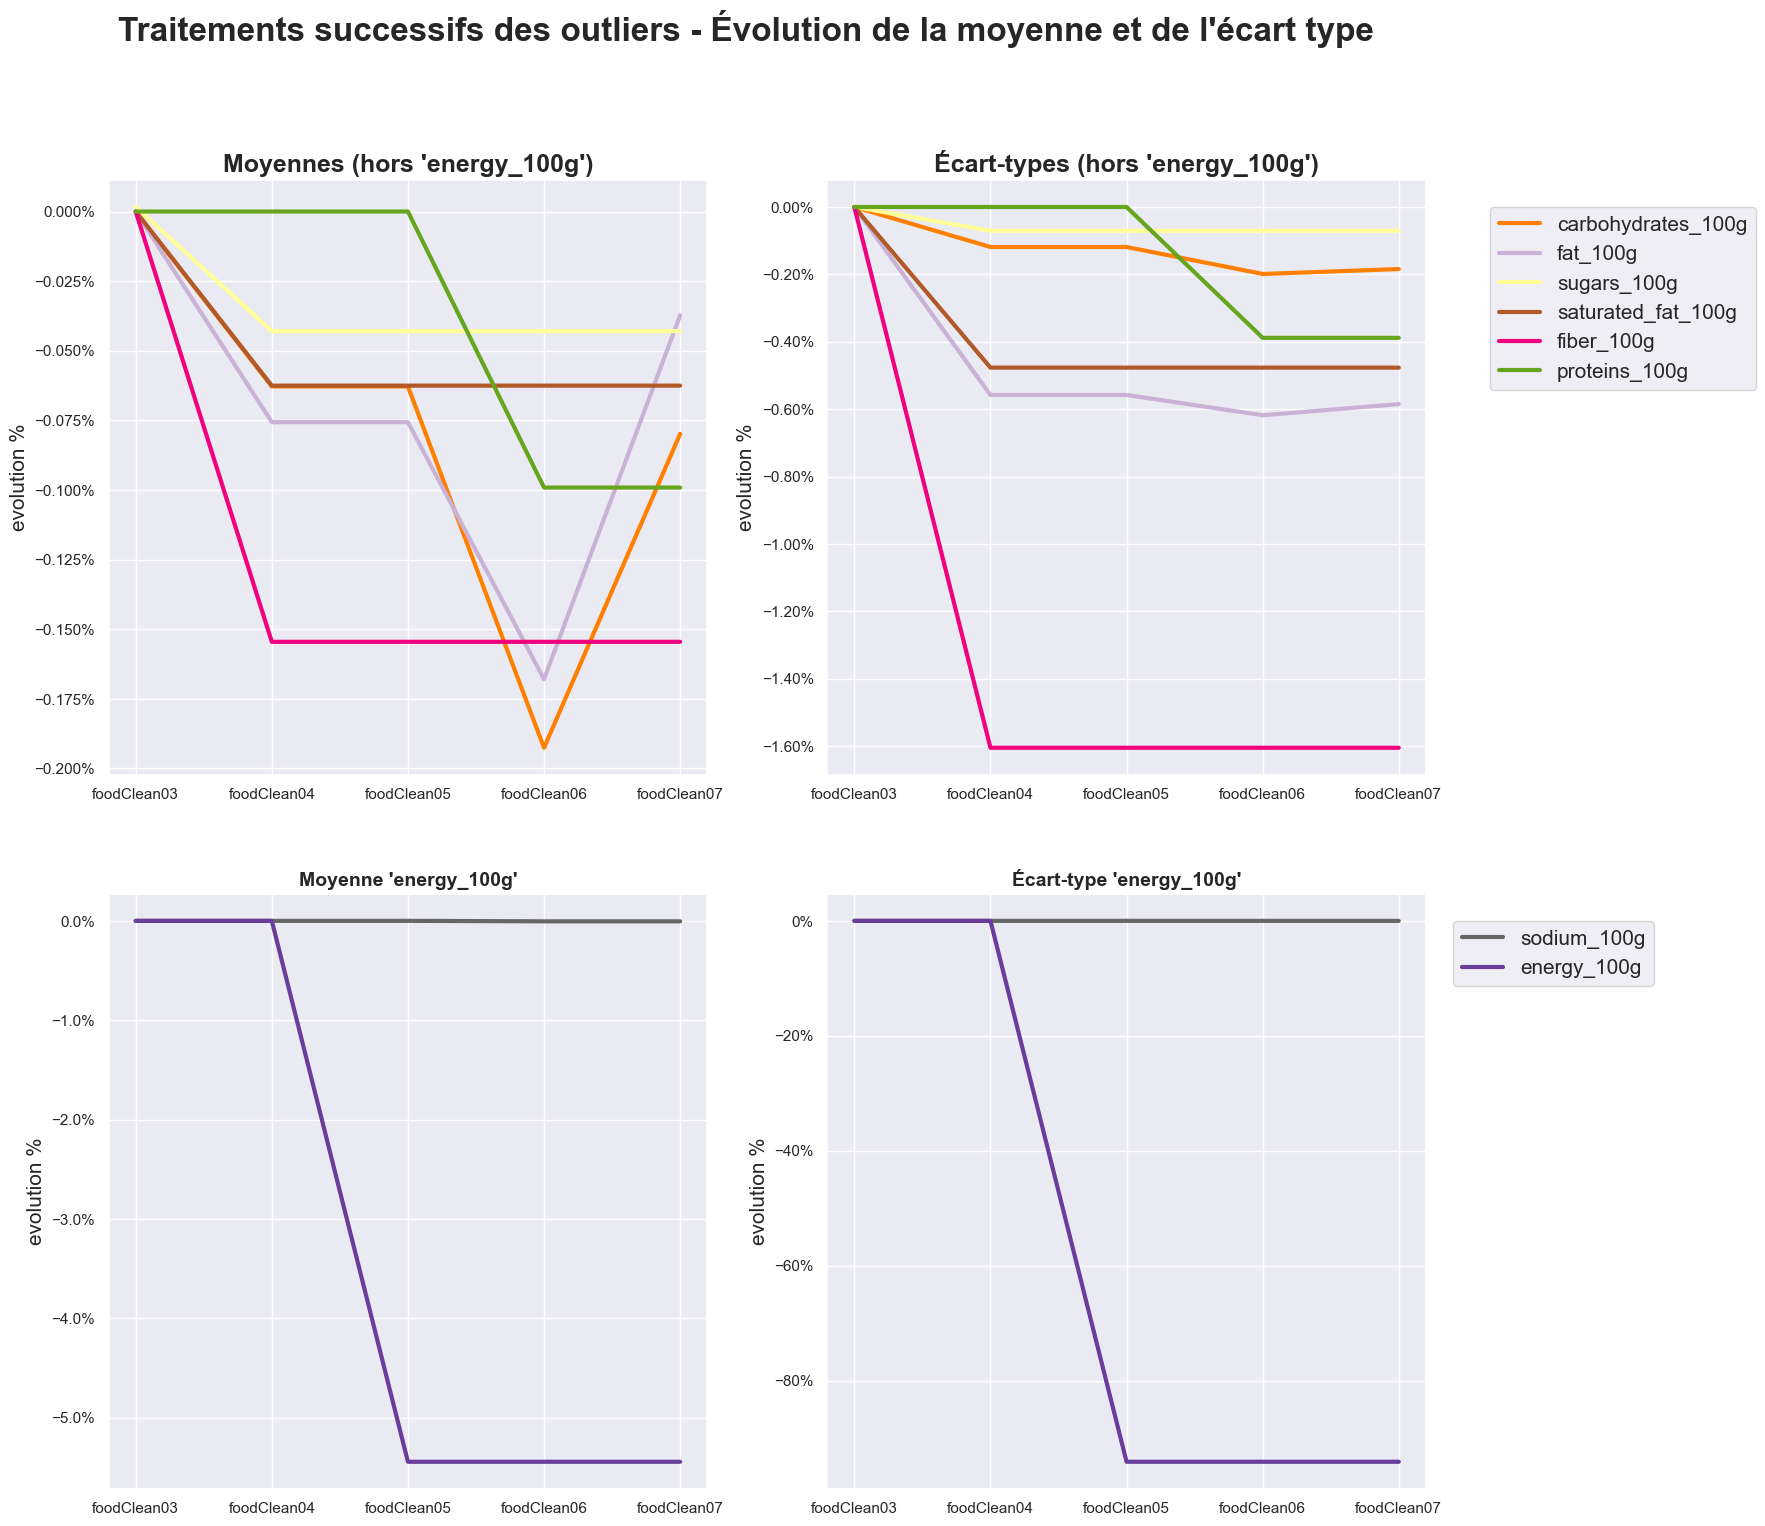

In [102]:
# visualisations of empirical mean and std evolution for each cleaning stage
sns.set_theme()
fig,axs=plt.subplots(2,2,sharex=False,figsize=(17,17)) # 4 plots 

axs=axs.reshape(axs.size) # reshape for easier iteration



for idxCol in range(len(numericalFeatureNames)) :
    
    X=[i+3 for i in range(len(listFoodCleanDfs)-1)] # set x axis
    
    if (idxCol!=numericalFeatureNames.index("energy_100g") 
        and 
        idxCol!=numericalFeatureNames.index("sodium_100g")) : # cleaning on "energy_100g" had more impact --> separate plots
        
        sns.lineplot(
            ax=axs[0],
            x=X,
            y=[cumSumEvolOfMean[i][idxCol] for i in range(len(listFoodCleanDfs)-1)],
            linewidth = 3,
            color=foodPaletteDict[numericalFeatureNames[idxCol]]
        )
        
        sns.lineplot(
            ax=axs[1],
            x=X,
            y=[cumSumEvolOfStd[i][idxCol] for i in range(len(listFoodCleanDfs)-1)],
            linewidth = 3,
            color=foodPaletteDict[numericalFeatureNames[idxCol]]
        )
        
    else :
        sns.lineplot(
            ax=axs[2],
            x=X,
            y=[cumSumEvolOfMean[i][idxCol] for i in range(len(listFoodCleanDfs)-1)],
            linewidth = 3,
            color=foodPaletteDict[numericalFeatureNames[idxCol]]
        )
        
        sns.lineplot(
            ax=axs[3],
            x=X,
            y=[cumSumEvolOfStd[i][idxCol] for i in range(len(listFoodCleanDfs)-1)],
            linewidth = 3,
            color=foodPaletteDict[numericalFeatureNames[idxCol]]
        )

# axs titles
axs[0].set_title("Moyennes (hors 'energy_100g')", fontweight="bold",fontsize=18) 
axs[1].set_title("Écart-types (hors 'energy_100g')", fontweight="bold",fontsize=18) 
axs[2].set_title("Moyenne 'energy_100g'", fontweight="bold",fontsize=14) 
axs[3].set_title("Écart-type 'energy_100g'", fontweight="bold",fontsize=14) 

# for each plot
for i in range(len(axs)) :
    axs[i].set_xticks([3,4,5,6,7]) # 1 tick for 1 cleaning stage 
    axs[i].set_xticklabels(["foodClean0"+str(i+3) for i in range(5)]) # name xticks with names of dataframes
    axs[i].set_ylabel("evolution %",fontsize=15) # set y label
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1)) # use matplotlib.ticker to format y axis as percent
    
fig.legend(numericalFeatureNames[:-2],bbox_to_anchor=(1.1,0.87),fontsize=15) # set legend - each numerical feature name...
legEnergySod=fig.legend(numericalFeatureNames[-2:],bbox_to_anchor=(1.04,0.45),fontsize=15) # ... except for "energy_100g" and "sodium_100g", on a different legend
legEnergySod.legendHandles[0].set_color(foodPaletteDict["sodium_100g"]) # choose the right color from the palette for energy legend
legEnergySod.legendHandles[1].set_color(foodPaletteDict["energy_100g"])
fig.suptitle("Traitements successifs des outliers - Évolution de la moyenne et de l'écart type", fontweight="bold",fontsize=24) # main title

plt.show()


Les différentes étapes de **nettoyage sur les outliers** ont globalement **diminué les moyennes et écarts-types empiriques** des features concernées.

La dernière étape (imputation par NaN de masses en glucides et en gras) a en revanche eu un effet opposé, ce qui est logique car nous avons retiré des valeurs basses.

L'opération sur **"energy_100g"** (fixer une borne haute à 3700 KJ) a eu un impact **très important**.

## P2.5. Traiter les valeurs manquantes<a class="anchor" id="P25"></a>

### P2.5.1. Nettoyage des valeurs manquantes : produits trop mal renseignés<a class="anchor" id="P251"></a>

Nous allons **dans un premier temps** réaliser une nouvelle opération de nettoyage, cette fois en **nous séparant totalement des produits ne contenant que très peu d'information nutritionnelle**.

En effet il y a de nombreux produits où nous ne connaissons pas la moindre masse en nutriments :

In [103]:
# number of rows with all component masses missing
print("Il y a ",
      len(foodClean07.loc[foodClean07[componentFeatures].isna().all(axis=1)]),
      " produits dont nous ne connaissons la moindre masse en nutriments"
     )

Il y a  32750  produits dont nous ne connaissons la moindre masse en nutriments


Sans ces informations il sera difficile de considérer ces produits dans le cadre de l'analyse, et surtout dans le cadre de la création de l'app.

Nous pourrions nous poser la question de l'imputation de celles-ci, mais :
- `Iterative Imputer` et `KNN Imputer` ne pourront imputer ces lignes **qu'avec la valeur moyenne de chaque feature**
- un filtrage préalable sur les modalités d'une variable catégorielle n'apportera pas beaucoup plus de précision

Nous faisons donc le choix **de nous séparer de ces produits**.

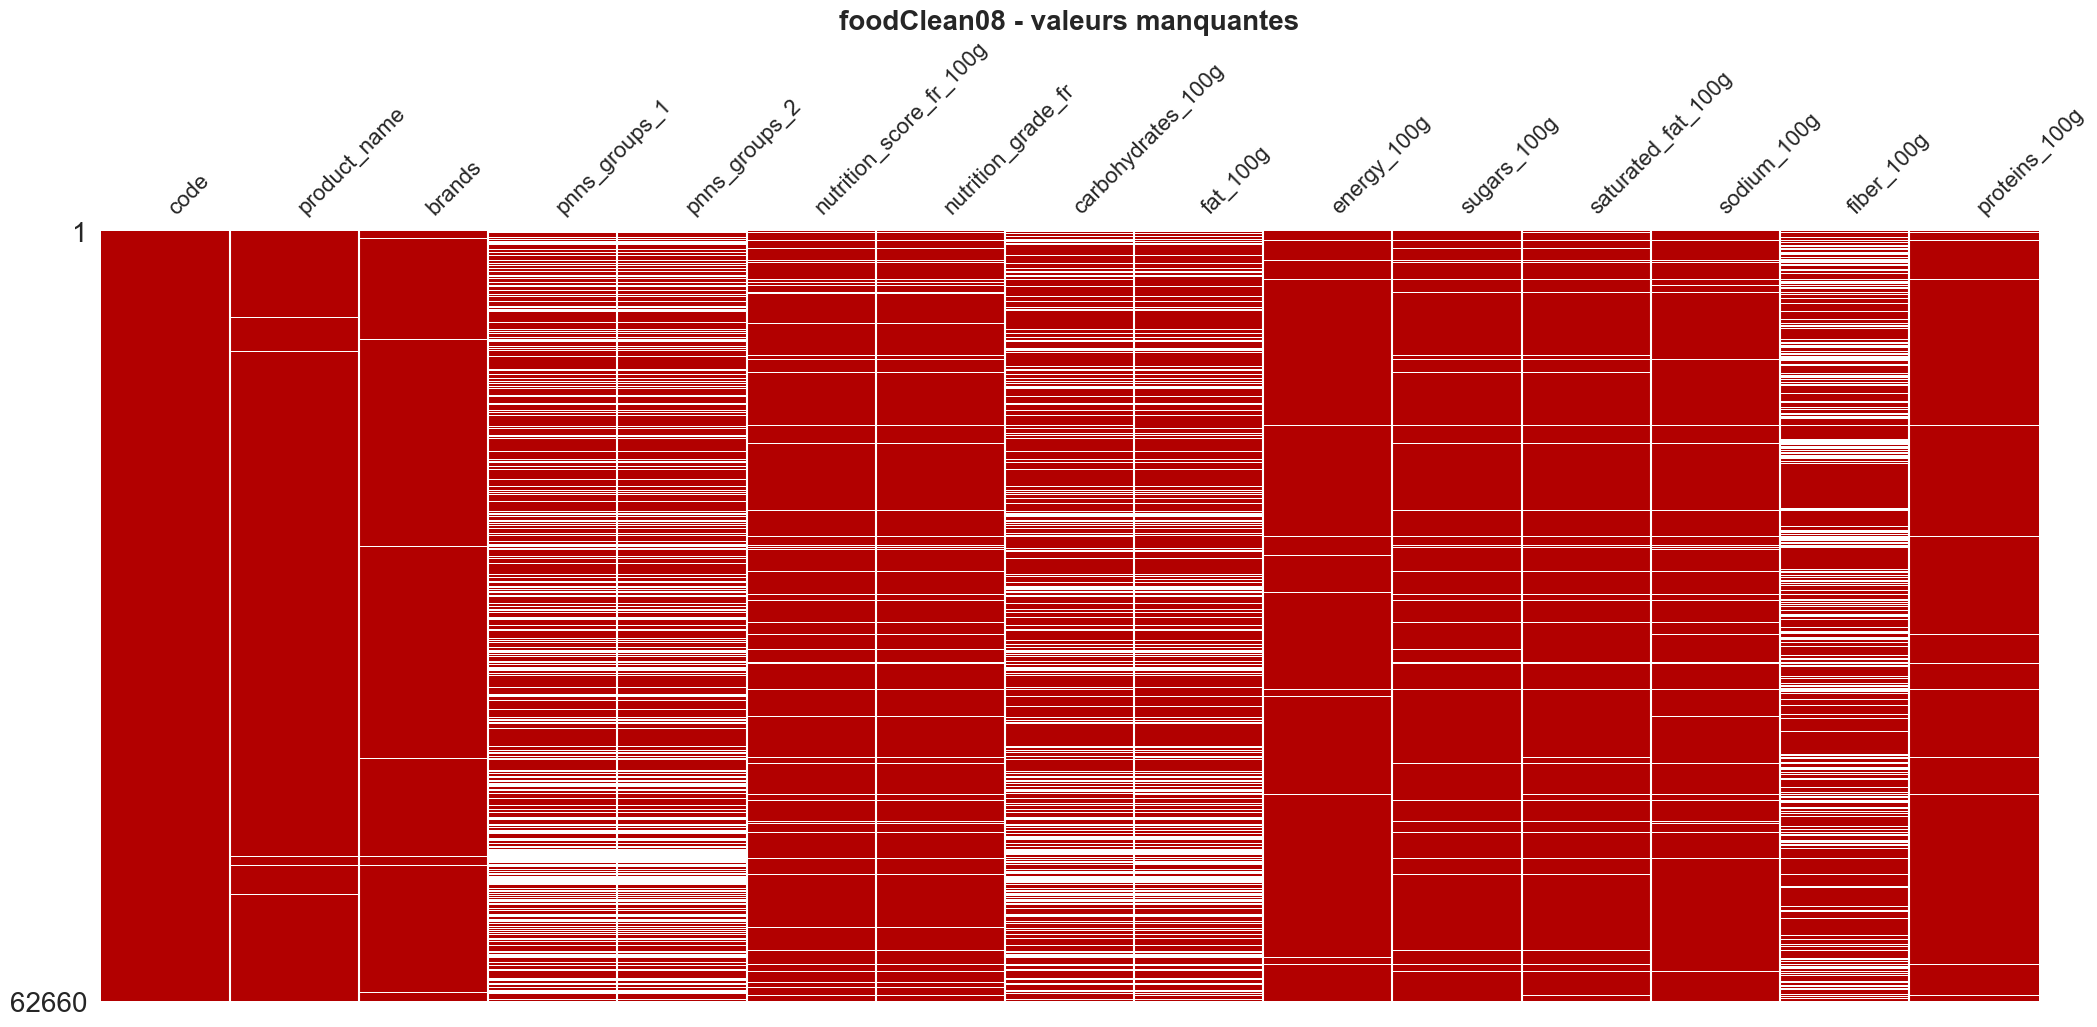

In [104]:
# exclude rows with all component masses missing

foodClean08=foodClean07.copy()
foodClean08=foodClean08.loc[foodClean08[componentFeatures].notna().any(axis=1)]

# visualisation
ms.matrix(foodClean08,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodClean08 - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

### P2.5.2. Imputations - Préambule<a class="anchor" id="P252"></a>

Dans le cadre du traitement des valeurs manquantes, nous allons tester différentes méthodes d'imputation :
- **Iterative Imputer**, pour les variables numériques
- **KNN Imputer**, pour les variables numériques
- **Utilisation d'une fonction d'imputation**, pour les variables catégorielles

Afin de tester la pertinence de tel ou tel imputeur, nous allons :
- retirer les features "code", "product_name", "brands", qui ne seront pas imputées
- conserver les features "nutrition_score_fr_100g" et "nutrition_grade_fr" :

    **"nutrition_score_fr_100g" est celle pour laquelle nous préparons le jeu de données. Dans le cadre d'une éventuelle future phase du projet l'objectif serait de faire des prédictions sur "nutrition_score_fr_100g", et ensuite l'utiliser pour construire un MyHealthScore. Elle serait donc notre variable dépendente.**
    
    **L'objectif n'est donc pas de réaliser des imputations. Cependant, nous conserverons cette feature lors des opérations d'imputation sur les autres car :**
    - **il existe des relations entre celle-ci et les autres (car le score nutritionnel est construit à partir des autres feature numériques)**
    - **imputer les autres features sans le score nutritionnel biaiserait alors ces éventuelles futures prédictions**

        A noter que pour l'analyse nous conserverons ses valeurs imputées. Elles seraient retirée du dataset dans le cadre d'un projet de prédiction (celles-ci n'apporteraient que du bruit dans le cadre d'une régression)
    
    
- scaler les features "nutrition_score_fr_100g" et "energy_100g" afin qu'elle soit sur la **même échelle que les autres variables numériques**
- **créer** un dataframe test en générant **artificiellement des valeurs manquantes**. Nous pourrons ainsi voir quel imputeur est le plus performant

### P2.5.3. Création d'un dataframe de test pour les imputations<a class="anchor" id="P253"></a>

Nous souhaitons créer un dataframe de test reproduisant à peu près la répartition des valeurs manquantes de notre dataframe.

Nous allons utiliser la fonction créée précédemment. Tout d'abord il faut préparer le dataframe :
- sélectionner les colonnes
- scaler les features choisies

In [105]:
foodCompleteFeaturesNames = foodClean08.columns.tolist()
foodCompleteFeaturesNames.remove("code")
foodCompleteFeaturesNames.remove("product_name")
foodCompleteFeaturesNames.remove("brands")


# scale "energy_100g" and "nutrition_score_fr_100g" to range (0,100), like others
zeroTo100Scaler=MinMaxScaler((0,100))
ener_nutri_Scaled=zeroTo100Scaler.fit_transform(foodClean08[["energy_100g","nutrition_score_fr_100g"]])

foodScaled = foodClean08[foodCompleteFeaturesNames].copy()
foodScaled.energy_100g=ener_nutri_Scaled[:,0] # replace "energy_100g" with its scaled version
foodScaled.nutrition_score_fr_100g=ener_nutri_Scaled[:,1] # replace "nutrition_score_fr_100g" with its scaled version

In [106]:
# Create dataframes to test imputations
%time foodComplete, foodIncomplete = generateDfsToTestImput (foodScaled)

Wall time: 45.8 s


Le temps de traitement est assez long.

In [107]:
# list of numerical features names
foodCompleteNumFeaturesNames=foodComplete.select_dtypes("float64").columns.tolist()

Nous pouvons vérifier que la proportion de valeurs manquantes est à peu près la même entre notre dataframe original et le dataframe généré :

In [108]:
tabCompareMissingness = pd.DataFrame()
tabCompareMissingness["foodScaled"]=(foodScaled.isna().mean()*100).round(2).astype(str)+" %"
tabCompareMissingness["foodIncomplete"]=(foodIncomplete.isna().mean()*100).round(2).astype(str)+" %"
tabCompareMissingness

foodScaled foodIncomplete
pnns_groups_1              34.41 %        34.42 %
pnns_groups_2              34.41 %        34.42 %
nutrition_score_fr_100g     5.84 %         5.74 %
nutrition_grade_fr          5.84 %         5.74 %
carbohydrates_100g         28.12 %         28.1 %
fat_100g                   27.44 %        27.42 %
energy_100g                 1.17 %         1.14 %
sugars_100g                 4.02 %         3.97 %
saturated_fat_100g          4.24 %         4.19 %
sodium_100g                 3.93 %         3.89 %
fiber_100g                 29.69 %        29.69 %
proteins_100g               1.31 %         1.28 %

Les deux dataframes sont bien comparables sur ce point. Regardons ce que cela donne au niveau de la répartition :

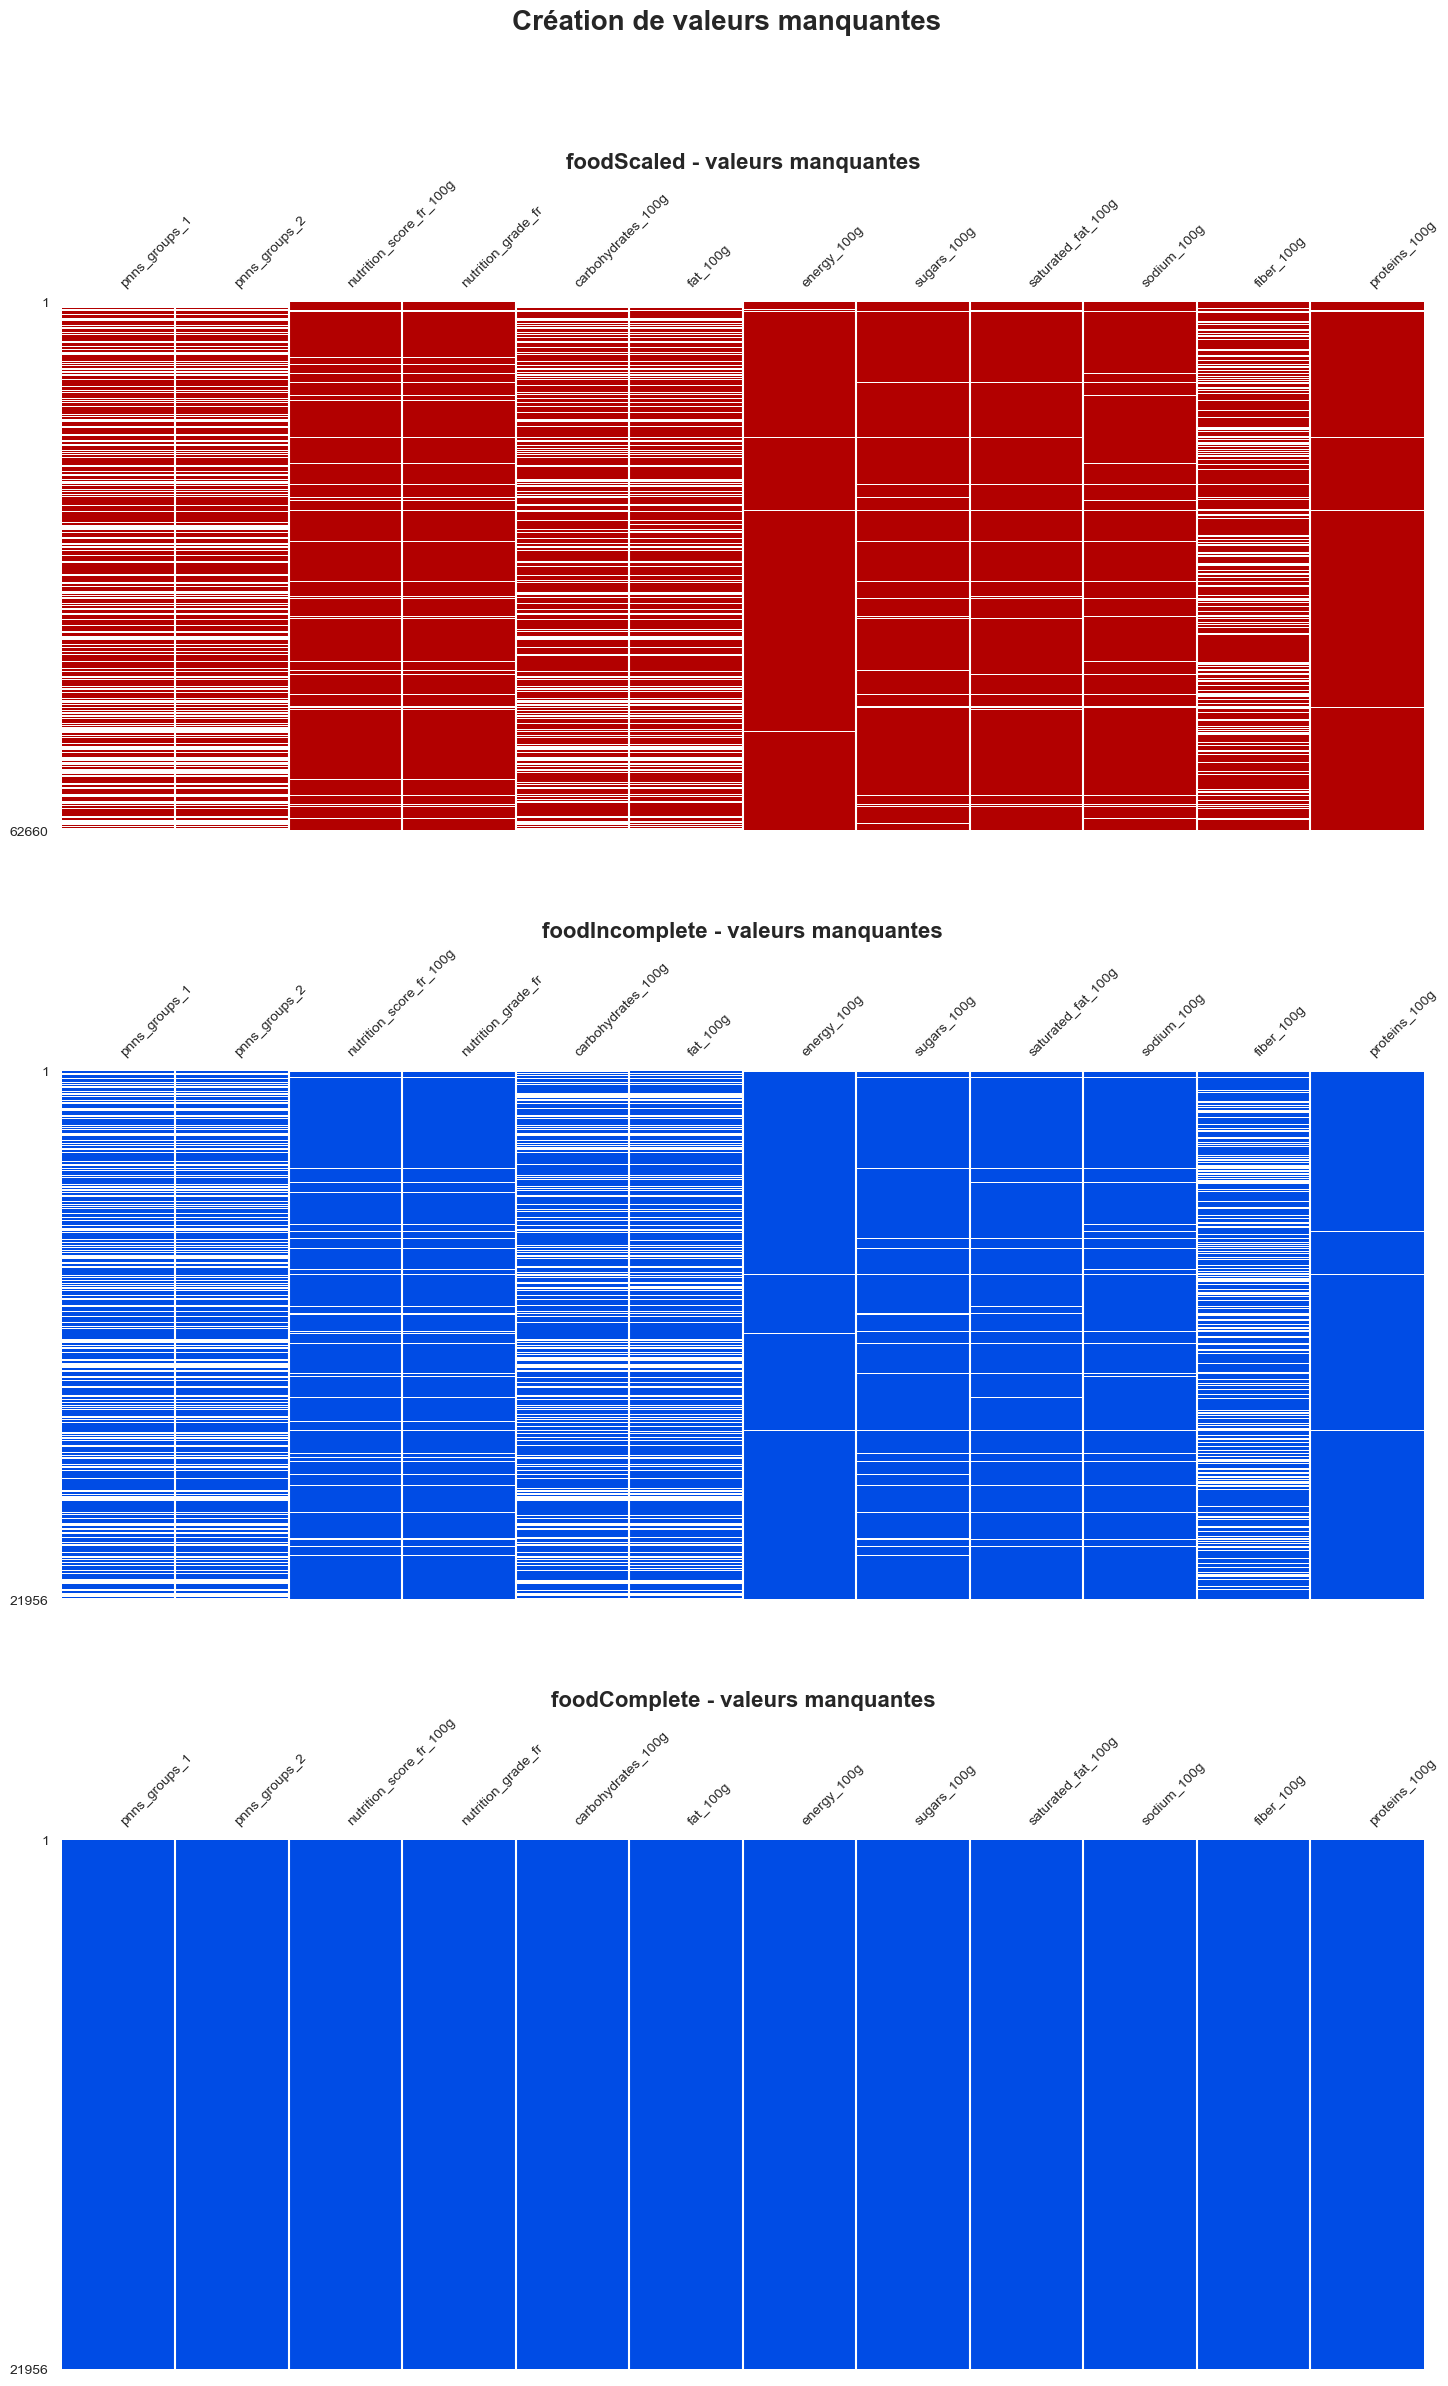

In [109]:
# visualisation of missing values

listOfDf=[foodScaled,foodIncomplete,foodComplete]
listOfDfNames=["foodScaled","foodIncomplete","foodComplete"]
listOfColors=[[0.7,0.0,0.0],[0.0,0.3,0.9],[0.0,0.3,0.9]]

fig,axs=plt.subplots(len(listOfDf),1,figsize=(16,25))
fig.suptitle("Création de valeurs manquantes", fontweight="bold",fontsize=20) # set main title

# dataviz of missing data

for i in range(len(listOfDf)) :
    
    ms.matrix(listOfDf[i],color=listOfColors[i],sparkline=False,ax=axs[i]) 
    axs[i].set_title(listOfDfNames[i]+" - valeurs manquantes", fontweight="bold",fontsize=16) 
    axs[i].set_xticklabels(axs[i].get_xticklabels(),fontsize=10)
    axs[i].set_yticklabels(axs[i].get_yticklabels(),fontsize=10)
    
fig.tight_layout(pad=5.0)

plt.show()

Nous disposons maintenant d'un dataframe `foodIncomplete` avec, pour chaque feature, environ la même proportion de valeurs manquantes que le dataframe original.

`foodIncomplete` nous permettra de réaliser des tests d'imputation.

Le dataframe `foodComplete` contient les valeurs réelles pour ces valeurs manquantes, ce qui nous permettra de vérifier.

### P2.5.4. Imputation des features catégorielles<a class="anchor" id="P254"></a>

Pour l'imputation de nos variables catégorielles, nous allons utiliser la fonction créée plus haut. Essayons par exemple d'imputer "pnns_groups_1" avec k=3 :

In [110]:
# myKNNCategoricalImputer on "pnns_groups_1" of foodIncomplete, with k=3
pnns1Imp3NN=myKNNCategoricalImputer (foodIncomplete,"pnns_groups_1",k=3)

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

On peut regarder ce que cela donne au niveau du pourcentage d'erreur d'imputation.

In [111]:
# check the percentage of error for our imputation test

mask=foodIncomplete.pnns_groups_1.isna() # create a mask with foodIncomplete missing values
compareK3=pd.DataFrame() 
compareK3["soluce"]=foodComplete.loc[mask,"pnns_groups_1"] # real values from foodComplete
compareK3["imput"]=pnns1Imp3NN.loc[mask,"pnns_groups_1"] # imputations

In [112]:
errorPercentK3=(compareK3["soluce"]!=compareK3["imput"]).mean()
print("Le pourcentage d'erreur d'imputation avec k=3 est de "+str(round(errorPercentK3*100,2))+" %")

Le pourcentage d'erreur d'imputation avec k=3 est de 12.41 %


Regardons avec un autre k. Par exemple k=8

In [113]:
pnns1Imp8NN=myKNNCategoricalImputer (foodIncomplete,"pnns_groups_1",k=8)

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [114]:
# check the percentage of error for our imputation test

mask=foodIncomplete.pnns_groups_1.isna() # create a mask with foodIncomplete missing values
compareK8=pd.DataFrame() 
compareK8["soluce"]=foodComplete.loc[mask,"pnns_groups_1"] # real values from foodComplete
compareK8["imput"]=pnns1Imp8NN.loc[mask,"pnns_groups_1"] # imputations

In [115]:
errorPercentK8=(compareK8["soluce"]!=compareK8["imput"]).mean()
print("Le pourcentage d'erreur d'imputation avec k=8 est de "+str(round(errorPercentK8*100,2))+" %")

Le pourcentage d'erreur d'imputation avec k=8 est de 58.95 %


La précision est moins bonne pour k=8.

Utilisons maintenant la fonction d'optimisation de k pour créée plus haut. Et **déterminons le meilleur k pour chacune** de nos trois variables catégorielles :

In [116]:
# BestKforMyKNNCatImputer on "pnns_groups_1", with test dataframes foodComplete and foodIncomplete
%time errorsForPnns1=BestKforMyKNNCatImputer(foodComplete, foodIncomplete, catCol="pnns_groups_1", rangeOfK=(1,10))

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 9.8 s


In [117]:
# BestKforMyKNNCatImputer on "pnns_groups_2", with test dataframes foodComplete and foodIncomplete
%time errorsForPnns2=BestKforMyKNNCatImputer(foodComplete, foodIncomplete, catCol="pnns_groups_2", rangeOfK=(1,10))

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 10.2 s


In [118]:
# BestKforMyKNNCatImputer on "nutrition_grade_fr", with test dataframes foodComplete and foodIncomplete
%time errorsForNutriGrade=BestKforMyKNNCatImputer(foodComplete, foodIncomplete, catCol="nutrition_grade_fr", rangeOfK=(1,10))

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 9.84 s


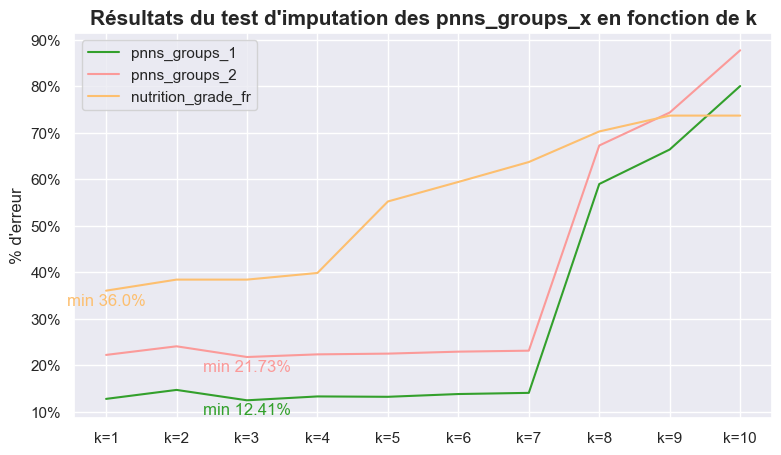

In [119]:
# plot imputation error percentages for different k, for "pnns_groups_1" and "pnns_groups_2" 


errors=pd.concat([errorsForPnns1,errorsForPnns2,errorsForNutriGrade],axis=1) # put results on an unique tab

fig,axs=plt.subplots(1,figsize=(9,5))


# draw a lineplot for each pnns
for i,catCol in enumerate(errors.columns.tolist()) :
    sns.lineplot(
        data=errors,
        y=errors[catCol],
        x=errors.index.tolist(),
        ax=axs,
        color=foodPaletteDict[catCol.split("_",1)[1]],
        label=catCol.split("_",1)[1]
    )

    # put the best error percentage on each line
    axs.text(
        x=errors[catCol].idxmin(axis=0),
        y=errors[catCol].min()-0.005,
        s="min "+str(round(errors[catCol].min()*100,2))+"%",
        color=foodPaletteDict[catCol.split("_",1)[1]],
        ha="center",
        va="top"
    )
    

axs.set_ylabel("% d'erreur") # set y label
axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1)) # use matplotlib.ticker to format y axis as percent
plt.title("Résultats du test d'imputation des pnns_groups_x en fonction de k", fontweight="bold",fontsize=15) # set title


plt.show()


Les résultats ne sont **pas concluants pour "nutrition_grade_fr"**...

Pour essayer d'améliorer nos imputations sur variable :
- nous allons filtrer sur les catégories de "pnns-groups_1" $ ^{(1)} $
- utiliser notre fonction de détermination du meilleur k pour "nutrition_grade_fr" **au sein de cette catégorie**
- imputer avec le meilleur k
- **agréger** les résultats

*$ ^{(1)} $ L'utilisation de "pnns_groups_1" plutôt que "pnns_groups_2" est un choix :*
- *l'imputeur catégoriel a eu de meilleurs résultats*
- *le nombre de catégories de "pnns_groups_2" est très (trop ?) grand :*
    - *temps de calcul bien plus long*
    - *suffisemment de produits pour l'imputeur ?*


In [120]:
%%time 
# Filter on "pnns_groups_1" categories, then use BestKforMyKNNCatImputer function on "nutrition_grade_fr", 
# with test dataframes foodComplete and foodIncomplete

bestKsDict={} # initiate a dictionnary to store values of k
NutriGradeImput=foodIncomplete.copy() # create a copy

# iterate on "pnns_groups_1" categories
for cat1 in pnns1Imp3NN["pnns_groups_1"].unique().tolist() :
    idxCat1=pnns1Imp3NN["pnns_groups_1"].loc[pnns1Imp3NN["pnns_groups_1"]==cat1].index # store index for filtering
    
    # run BestKforMyKNNCatImputer for "nutrition_grade_fr" in filtered foodIncomplete
    errorsForNutriGrade_WithCat1=BestKforMyKNNCatImputer(
        foodComplete.loc[idxCat1], 
        foodIncomplete.loc[idxCat1], 
        catCol="nutrition_grade_fr", 
        rangeOfK=(1,10))
    
    bestKCat1 = int(errorsForNutriGrade_WithCat1.idxmin()[0][-1]) # search for the best k
    bestKsDict[cat1]=bestKCat1 # put it in the dictionnary
    
    # run myKNNCategoricalImputer with our best k
    NutriGradeImput_cat1 = myKNNCategoricalImputer (foodIncomplete.loc[idxCat1],"nutrition_grade_fr",k=bestKCat1)
    
    # put results for this cat1 in NutriGradeImput
    NutriGradeImput.loc[idxCat1,"nutrition_grade_fr"]=NutriGradeImput_cat1
    

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 28 s


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [121]:
# check the percentage of error for our imputation test

mask=foodIncomplete.nutrition_grade_fr.isna() # create a mask with foodIncomplete missing values
compareNutriGrade=pd.DataFrame() 
compareNutriGrade["soluce"]=foodComplete.loc[mask,"nutrition_grade_fr"] # real values from foodComplete
compareNutriGrade["imput"]=NutriGradeImput.loc[mask,"nutrition_grade_fr"] # imputations

In [122]:
errorPercentNutriGrade=(compareNutriGrade["soluce"]!=compareNutriGrade["imput"]).mean()
print("Le pourcentage d'erreur d'imputation sur NutriGrade est de "+str(round(errorPercentNutriGrade*100,2))+" %")

Le pourcentage d'erreur d'imputation sur NutriGrade est de 28.55 %


Les résultats sont légèrement **meilleurs** en **filtrant** par catégorie de "pnns_groups_1" : 28.55% d'erreur versus 36.00% pour notre meilleur essai précédents.

Nous allons pouvoir appliquer ces paramètres pour imputer notre dataframe :
- tout d'abord nous allons imputer "pnns_groups_1", "pnns_groups_2" avec les k déterminés plus haut
- ensuite nous allons utiliser la même méthode que précédemment pour "nutrition_grade_fr". Cette fois nous **ne pourrons pas utiliser** notre fonction `BestKforMyKNNCatImputer` : Nous allons donc utiliser le **dictionnaire créé lors du test** pour choisir k à chaque itération sur les catégories de "pnns_groups_1" :

In [123]:
bestKsDict

{'Beverages': 1,
 'Sugary snacks': 1,
 'Composite foods': 1,
 'Milk and dairy products': 1,
 'Fat and sauces': 1,
 'Fish meat eggs': 1,
 'Salty snacks': 3,
 'Cereals and potatoes': 3,
 'Fruits and vegetables': 3}

In [124]:
%%time
# imput "pnns_groups_1", "pnns_groups_2" with their best k
foodCatImputed = foodScaled.copy() # create a copy()
for col in ["pnns_groups_1", "pnns_groups_2"] :
    bestK=int(errors["%Error_"+col].idxmin()[-1]) # find row with the minimum and keep the value of k
    foodCatImputed = myKNNCategoricalImputer ( # use the categorical imputation function
        foodCatImputed, 
        col,
        k=bestK # use the best k
    )

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 10.4 s


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [125]:
%%time
for cat1 in foodCatImputed["pnns_groups_1"].unique().tolist() :
    idxCat1=foodCatImputed["pnns_groups_1"].loc[foodCatImputed["pnns_groups_1"]==cat1].index

    foodCatImputed.loc[idxCat1,"nutrition_grade_fr"]=myKNNCategoricalImputer (
        foodCatImputed.loc[idxCat1],"nutrition_grade_fr",k=bestKsDict[cat1])
    
    # set "nutrition_grade_fr" type to category
    foodCatImputed.loc[:,"nutrition_grade_fr"]=foodCatImputed["nutrition_grade_fr"].astype("category")

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 4.65 s


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


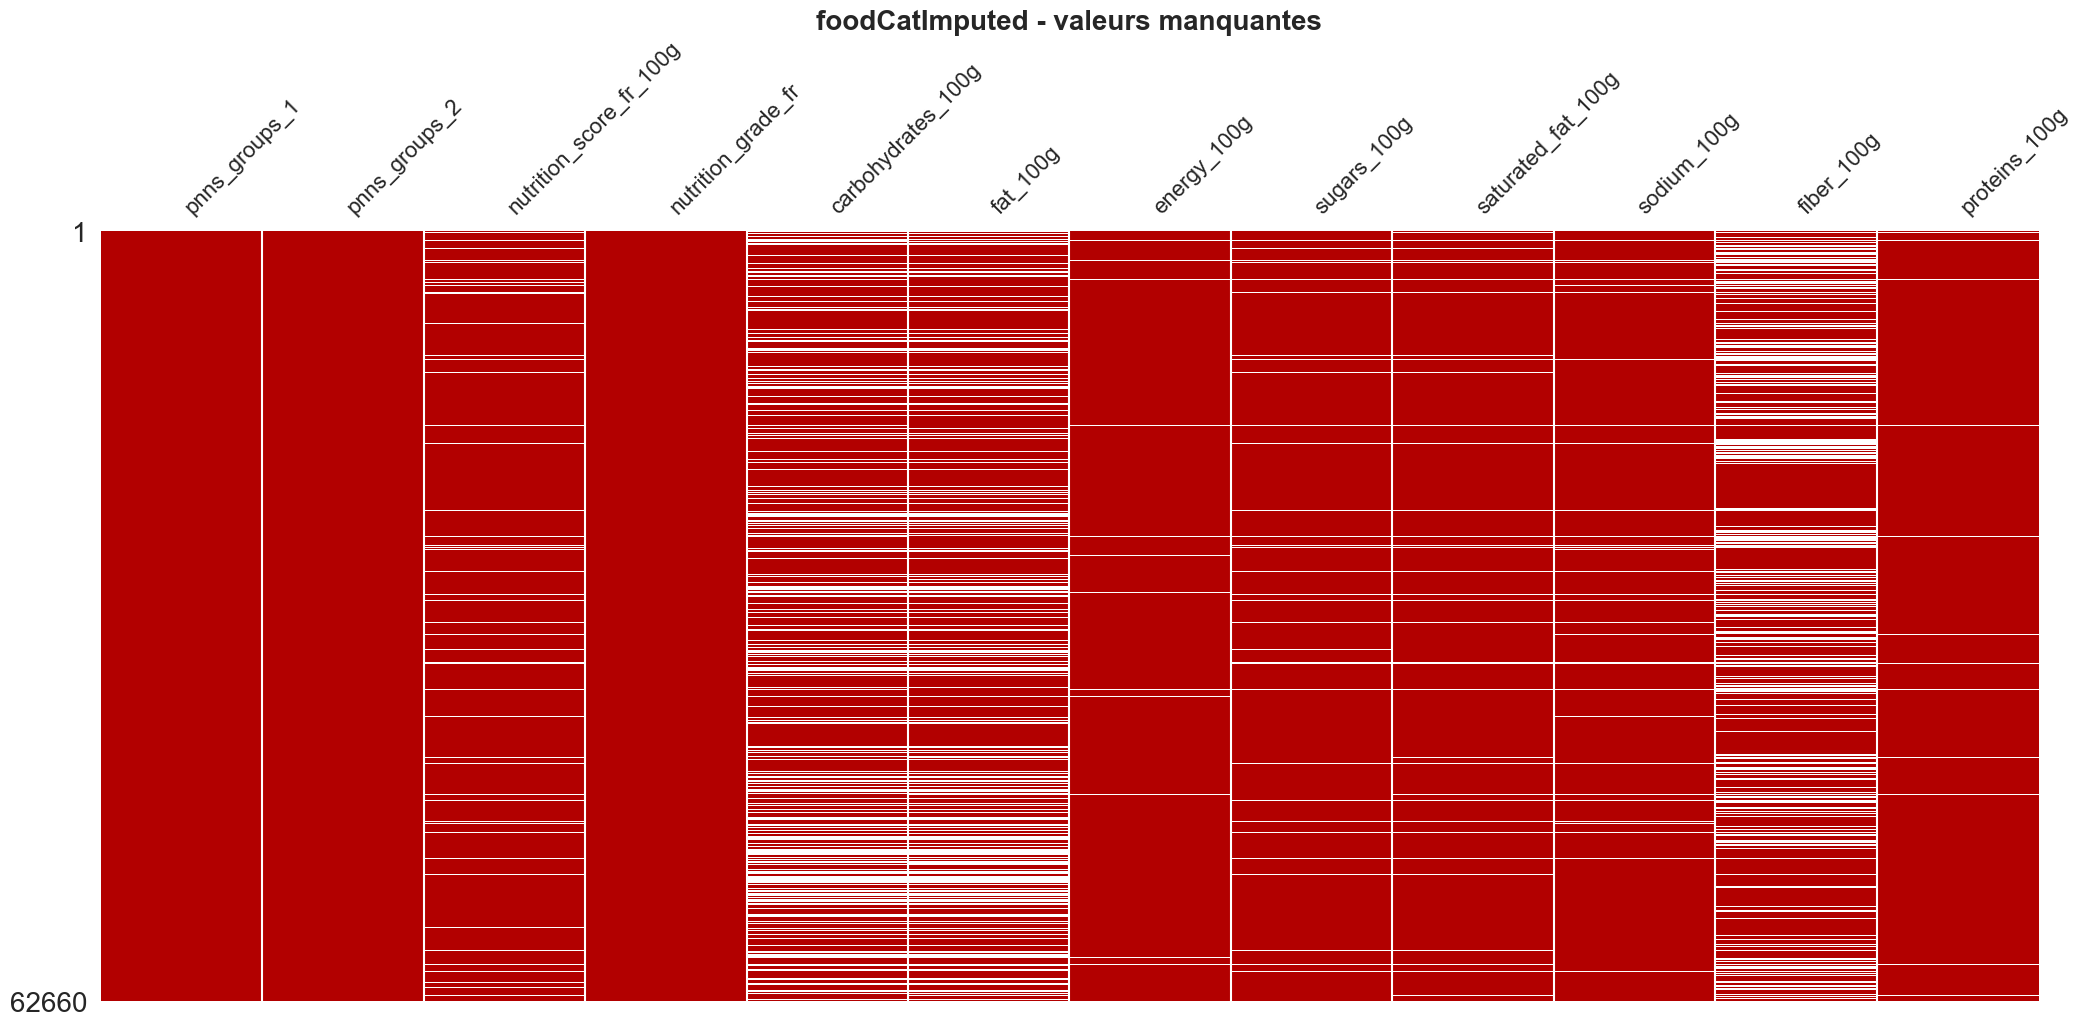

In [126]:
# visualisation of missing values
ms.matrix(foodCatImputed,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodCatImputed - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

Mettons également à jour nos dataframes de test :

In [127]:
# Update dataframes to test imputations
%time foodComplete, foodIncomplete = generateDfsToTestImput (foodCatImputed)

Wall time: 20.9 s


### P2.5.5. Imputer les variables numériques. Tests sur la totalité du dataframe<a class="anchor" id="P255"></a>

#### P2.5.5.1. Global 5NN<a class="anchor" id="P2551"></a>

Nous allons tout d'abord tester le KNN Imputeur sur la totalité de nos features numériques.

Essayons **au hasard avec k=5**.
Nous en profiterons pour regarder le **temps d'exécution**.

In [128]:
# KNN pour les autres variables
KNN_imputer = KNNImputer(n_neighbors=5,missing_values=np.nan)
%time foodTestImp01=pd.DataFrame(KNN_imputer.fit_transform(foodIncomplete[foodCompleteNumFeaturesNames]),columns=foodCompleteNumFeaturesNames,index=foodIncomplete.index)

Wall time: 21 s


Le temps de calcul est long.

Regardons à quoi ressemble une des features, au hasard "sugars_100g", au niveau des lignes imputées :

In [129]:
sampleSugars_Global5NN=getSoluceColAndGuessCol (
    col="sugars_100g", 
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp01, 
).sample(15,random_state=1)
sampleSugars_Global5NN

sugars_100g_SOLUCE  sugars_100g_IMPUT
242530                 0.5              0.800
232941                 0.0             15.620
241913                10.8             10.956
247948                17.0             17.220
188869                 2.0              7.080
211732                 1.4              1.320
200748                 1.0              2.120
269664                54.1             29.060
312151                 8.0              5.460
218897                 0.4             13.180
230153                25.2             24.100
249408                 1.2              4.840
190475                 0.3              0.300
242439                 5.2             17.520
221400                 1.5              0.360

Cela n'a pas l'air très concluant, regardons ce que cela donne pour les RMSEs et R2s de chaque feature numérique :

In [130]:
global5NN_measures=resultsNumImput(
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp01
)

In [131]:
ShowResultsNumImputsCHOICES (global5NN_measures,"Global_5NN",dictPalette=foodPaletteDict,singleFigsize=(6,5))

Output()

#### P2.5.5.2. Global BestNN<a class="anchor" id="P2552"></a>

Essayons d'optimiser k. Pour cela nous allons utiliser la fonction créée plus haut qui va :
- itérer sur une fourchette de k donnée
- nous donner en sortie :
    - un tableau avec pour chaque feature numérique, et chaque valeur de k, le RMSE. Ainsi que le meilleur k (celui qui donne le plus petit RMSE).
    - un tableau avec pour chaque feature numérique, et chaque valeur de k, le R2. Ainsi que le meilleur k (celui qui donne le plus grand coefficient de détermination R2).
    - un tableau avec la moyenne des RMSEs et R2s, pour chaque valeur de k. Ainsi que le meilleur k en considérant ces moyennes.

Regardons l'impact de k sur la précision de l'imputation, pour **k de 2 à 15** :

In [132]:
%time tabRMSE,tabR2,tabMean = BestKNNImputer(dfComplete=foodComplete, dfIncomplete=foodIncomplete, rangeOfK=(2,15))

Wall time: 37min 23s


In [133]:
display(tabRMSE,tabR2,tabMean)

RMSE_k=2   RMSE_k=3   RMSE_k=4   RMSE_k=5  \
nutrition_score_fr_100g  11.332516  10.483644  10.191078   9.794089   
carbohydrates_100g       16.632510  14.629151  13.486865  12.675666   
fat_100g                 12.875058  10.249410   8.957715   8.062903   
energy_100g              18.539961  18.249991  17.222634  16.905978   
sugars_100g              13.673422  12.340013  11.558624  11.408118   
saturated_fat_100g        4.920914   4.530111   4.553682   4.426554   
sodium_100g               1.495375   1.476090   1.147204   1.196521   
fiber_100g                3.045770   2.899198   2.837958   2.842024   
proteins_100g             6.130113   5.482728   5.844780   5.795708   

                          RMSE_k=6   RMSE_k=7   RMSE_k=8   RMSE_k=9  \
nutrition_score_fr_100g   9.513841   9.381570   9.233074   9.139215   
carbohydrates_100g       12.184129  11.802607  11.584641  11.327532   
fat_100g                  7.444236   7.030910   6.714644   6.435688   
energy_100g              16.537941  16.242531  16.213460  16.327136   
sugars_100g              11.215362  10.989948  10.793252  10.825317   
saturated_fat_100g        4.452322   4.440684   4.435509   4.372591   
sodium_100g               1.231739   1.100507   1.031903   1.070043   
fiber_100g                2.799569   2.782861   2.777150   2.776234   
proteins_100g             5.593102   5.436964   5.346010   5.341893   

                         RMSE_k=10  RMSE_k=11  RMSE_k=12  RMSE_k=13  \
nutrition_score_fr_100g   9.067347   9.030157   9.012067   8.983699   
carbohydrates_100g       11.166139  11.028115  10.895051  10.792493   
fat_100g                  6.196593   6.018146   5.880291   5.736889   
energy_100g              16.290817  16.354822  16.219894  16.041896   
sugars_100g              10.795667  10.775150  10.645658  10.590513   
saturated_fat_100g        4.310425   4.291202   4.273509   4.284807   
sodium_100g               1.027921   1.044984   1.062185   1.041258   
fiber_100g                2.788992   2.787706   2.798491   2.806321   
proteins_100g             5.261435   5.265471   5.223580   5.175458   

                         RMSE_k=14  RMSE_k=15 best_k_per_feature  
nutrition_score_fr_100g   8.923195   8.894168                 15  
carbohydrates_100g       10.686045  10.609221                 15  
fat_100g                  5.634286   5.540849                 15  
energy_100g              15.844216  15.846469                 14  
sugars_100g              10.603194  10.608645                 13  
saturated_fat_100g        4.244258   4.236224                 15  
sodium_100g               1.068400   1.037899                 10  
fiber_100g                2.813740   2.813204                  9  
proteins_100g             5.160476   5.157811                 15

R2_k=2    R2_k=3    R2_k=4    R2_k=5    R2_k=6  \
nutrition_score_fr_100g  0.515956  0.585755  0.608553  0.638457  0.658851   
carbohydrates_100g       0.620939  0.706755  0.750762  0.779842  0.796585   
fat_100g                 0.251875  0.525896  0.637865  0.706601  0.749899   
energy_100g              0.191777  0.216861  0.302550  0.327961  0.356903   
sugars_100g              0.196786  0.345804  0.426030  0.440880  0.459615   
saturated_fat_100g       0.500663  0.576825  0.572410  0.595951  0.591234   
sodium_100g             -0.074295 -0.046765  0.367727  0.312196  0.271111   
fiber_100g               0.392727  0.449768  0.472768  0.471256  0.486935   
proteins_100g           -0.082163  0.134337  0.016234  0.032683  0.099132   

                           R2_k=7    R2_k=8    R2_k=9   R2_k=10   R2_k=11  \
nutrition_score_fr_100g  0.668271  0.678689  0.685189  0.690120  0.692657   
carbohydrates_100g       0.809125  0.816110  0.824182  0.829156  0.833354   
fat_100g                 0.776900  0.796520  0.813076  0.826707  0.836544   
energy_100g              0.379672  0.381891  0.373193  0.375979  0.371066   
sugars_100g              0.481118  0.499526  0.496548  0.499302  0.501203   
saturated_fat_100g       0.593368  0.594315  0.605743  0.616874  0.620283   
sodium_100g              0.418152  0.488435  0.449920  0.492375  0.475383   
fiber_100g               0.493041  0.495120  0.495453  0.490805  0.491274   
proteins_100g            0.148728  0.176971  0.178238  0.202806  0.201583   

                          R2_k=12   R2_k=13   R2_k=14   R2_k=15  \
nutrition_score_fr_100g  0.693887  0.695811  0.699895  0.701844   
carbohydrates_100g       0.837351  0.840399  0.843531  0.845773   
fat_100g                 0.843946  0.851465  0.856731  0.861443   
energy_100g              0.381400  0.394903  0.409724  0.409556   
sugars_100g              0.513120  0.518151  0.516996  0.516500   
saturated_fat_100g       0.623408  0.621414  0.628546  0.629950   
sodium_100g              0.457969  0.479117  0.451608  0.482472   
fiber_100g               0.487330  0.484457  0.481728  0.481925   
proteins_100g            0.214236  0.228647  0.233107  0.233898   

                        best_k_per_feature  
nutrition_score_fr_100g                 15  
carbohydrates_100g                      15  
fat_100g                                15  
energy_100g                             14  
sugars_100g                             13  
saturated_fat_100g                      15  
sodium_100g                             10  
fiber_100g                               9  
proteins_100g                           15

k=2       k=3       k=4       k=5       k=6       k=7  \
Mean_of_RMSEs  9.849516  8.926704  8.422282  8.123062  7.885805  7.689843   
Mean_of_R2s    0.279363  0.388359  0.461655  0.478425  0.496696  0.529819   

                    k=8       k=9      k=10      k=11      k=12      k=13  \
Mean_of_RMSEs  7.569960  7.512850  7.433926  7.399528  7.334525  7.272593   
Mean_of_R2s    0.547509  0.546838  0.558236  0.558150  0.561405  0.568263   

                   k=14      k=15 best_k_on_average  
Mean_of_RMSEs  7.219757  7.193832                15  
Mean_of_R2s    0.569096  0.573707                15

On voit que modifier k n'a pas beaucoup d'impact sur la précision de l'imputation. De plus le temps de calcul est **très (très) long**.

#### P2.5.5.3. Global Iterative Imputer<a class="anchor" id="P2553"></a>

Essayons l'Iterative Imputer :

In [134]:
# iterative imputeur on all numerical features
from sklearn.linear_model import LinearRegression
iterative_imputer = IterativeImputer(estimator=LinearRegression())
%time foodTestImp02=pd.DataFrame(iterative_imputer.fit_transform(foodIncomplete[foodCompleteNumFeaturesNames]),columns=foodCompleteNumFeaturesNames,index=foodIncomplete.index)

Wall time: 633 ms


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


L'Iterative Imputer est bien plus rapide. Regardons ce que cela donne avec "sugars_100g" :

In [135]:
sampleSugars_GlobalIterImp=getSoluceColAndGuessCol (
    col="sugars_100g", 
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp02, 
).sample(15,random_state=1)
sampleSugars_GlobalIterImp

sugars_100g_SOLUCE  sugars_100g_IMPUT
242530                 0.5          24.351755
232941                 0.0          13.494724
241913                10.8           8.105967
247948                17.0           9.752308
188869                 2.0          13.689834
211732                 1.4           4.154812
200748                 1.0          -0.507234
269664                54.1          29.392502
312151                 8.0           7.745384
218897                 0.4          11.738732
230153                25.2          31.015870
249408                 1.2           4.300307
190475                 0.3          29.698287
242439                 5.2          25.472602
221400                 1.5          13.758123

Cela n'a pas l'air beaucoup mieux. Regardons ce que cela donne pour le RMSE et R2 :

In [136]:
globalIterImp_measures=resultsNumImput(
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp02
)

In [137]:
foodMeasuresTabs=[
    global5NN_measures,
    globalIterImp_measures
]
foodTestNames=[
    "Global_5NN",
    "Global_IterativeImputer"
]

In [138]:
ShowResultsNumImputsCHOICES (foodMeasuresTabs,foodTestNames,dictPalette=foodPaletteDict,singleFigsize=(6,5))

Output()

Le temps de calcul est donc bien meilleur, mais nous obtenons des résultats moins bons...

Cela peut s'expliquer : l'IterativeImputer impute en réalisant une regression (ici, linéaire) de **chaque feature en fonction de TOUTES les autres, à tour de rôle**. Or toutes nos features **ne sont pas correlés entre elles**...

**Une solution pour améliorer** nos imputations serait :
- d'**étudier les corrélations entre features** 
    
    Ainsi nous pourrons utiliser l'IterativeImputer, bien plus rapide, à **bon escient**.
    
    
- de filtrer par **modalité de pnns_1** pour étudier des produits de la même grande famille.

    L'utilisation de "pnns_groups_1" plutôt que "pnns_groups_2" est un choix :
   - l'imputeur catégoriel a eu de meilleurs résultats
   - le nombre de catégories de "pnns_groups_2" est très (trop ?) grand pour pouvoir bénéficier de suffisemment de produits pour l'IterativeImputer.

### P2.5.6. Améliorer nos imputations<a class="anchor" id="P256"></a>

#### P2.5.6.1. Matrice des corrélations<a class="anchor" id="P2561"></a>

Calculons tout d'abord notre matrice des correlations :

In [139]:
# Compute the correlation matrix
foodCorr=foodCatImputed.loc[~foodCatImputed.isna().all(axis=1)].corr()
foodCorr

nutrition_score_fr_100g  carbohydrates_100g  \
nutrition_score_fr_100g                 1.000000            0.243538   
carbohydrates_100g                      0.243538            1.000000   
fat_100g                                0.579531           -0.071361   
energy_100g                             0.625728            0.527415   
sugars_100g                             0.451424            0.636864   
saturated_fat_100g                      0.603513           -0.024774   
sodium_100g                             0.121645           -0.080776   
fiber_100g                             -0.127557            0.250487   
proteins_100g                           0.097078           -0.131873   

                         fat_100g  energy_100g  sugars_100g  \
nutrition_score_fr_100g  0.579531     0.625728     0.451424   
carbohydrates_100g      -0.071361     0.527415     0.636864   
fat_100g                 1.000000     0.782006     0.005597   
energy_100g              0.782006     1.000000     0.327639   
sugars_100g              0.005597     0.327639     1.000000   
saturated_fat_100g       0.744111     0.572878     0.080296   
sodium_100g              0.009715    -0.023889    -0.086722   
fiber_100g               0.081547     0.210181     0.034818   
proteins_100g            0.145883     0.209382    -0.249965   

                         saturated_fat_100g  sodium_100g  fiber_100g  \
nutrition_score_fr_100g            0.603513     0.121645   -0.127557   
carbohydrates_100g                -0.024774    -0.080776    0.250487   
fat_100g                           0.744111     0.009715    0.081547   
energy_100g                        0.572878    -0.023889    0.210181   
sugars_100g                        0.080296    -0.086722    0.034818   
saturated_fat_100g                 1.000000     0.008070    0.019908   
sodium_100g                        0.008070     1.000000    0.004599   
fiber_100g                         0.019908     0.004599    1.000000   
proteins_100g                      0.143507     0.089197    0.197247   

                         proteins_100g  
nutrition_score_fr_100g       0.097078  
carbohydrates_100g           -0.131873  
fat_100g                      0.145883  
energy_100g                   0.209382  
sugars_100g                  -0.249965  
saturated_fat_100g            0.143507  
sodium_100g                   0.089197  
fiber_100g                    0.197247  
proteins_100g                 1.000000

Afin d'améliorer la lisibilité, nous allons afficher cette même matrice sur une heatmap en utilisant la librairie Seaborn.
La matrice étant symétrique, nous allons afficher seulement le "triangle" inférieure.

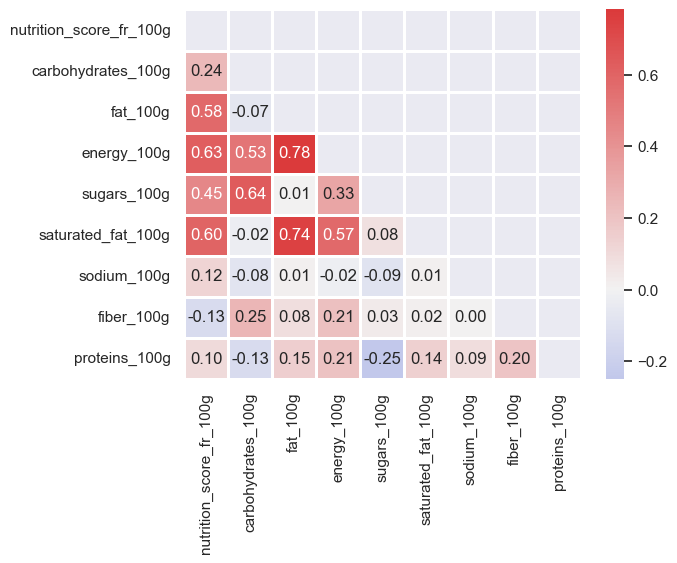

In [140]:
# Display the correlation matrix on a heatmap

# Generate a mask to display only the lower triangle
maskTri = np.triu(np.ones_like(foodCorr, dtype=bool),k=0)

# Draw the heatmap with the mask

sns.heatmap(
    data=foodCorr, # use the correlation matrix computed above
    mask=maskTri, # mask to display only the low triangle
    linewidth=1, # line between squares of the heatmap
    cmap=sns.diverging_palette(262,12, as_cmap=True,center="light",n=9), # blue for anticorrelated, red for correlated
    center=0, # no color for no correlation
    annot=True, # displays Pearson coefficients
    fmt="0.2f" # with 2 decimals
);

Les paires suivantes sont correlées avec un niveau supérieur à 0.60 :
- "fat_100g", "energy_100g"
- "fat_100g", "saturated_fat_100g"
- "sugars_100g", "carbohydrates_100g"
- "energy_100g", "nutrition_score_fr_100g"
- "saturated_fat_100g", "nutrition_score_fr_100g"

On peut donc faire des groupes de features pour nos opérations d'imputation avec l'IterativeImputer.

#### P2.5.6.2. Groupes d'imputation - impact de "pnns_1" ?<a class="anchor" id="P2562"></a>

Nous allons tester la fonction créée plus haut. Tout d'abord sur la totalité du dataframe :

In [141]:
IterImpGroups = makeCorrGroups(foodCatImputed, threshold=0.6)
IterImpGroups

{'G1': ['nutrition_score_fr_100g', 'energy_100g', 'saturated_fat_100g'],
 'G2': ['carbohydrates_100g', 'sugars_100g'],
 'G3': ['fat_100g', 'energy_100g', 'saturated_fat_100g'],
 'others': ['sodium_100g', 'fiber_100g', 'proteins_100g']}

In [142]:
foodCatImputed.pnns_groups_1.unique().tolist()

['Sugary snacks',
 'Cereals and potatoes',
 'Beverages',
 'Composite foods',
 'Fruits and vegetables',
 'Fish meat eggs',
 'Milk and dairy products',
 'Salty snacks',
 'Fat and sauces']

Testons maintenant sur deux catégorie différentes de "pnns_groups_1". Au hasard `Beverages` et `Salty snacks`. 

In [143]:
makeCorrGroups(foodCatImputed.loc[foodCatImputed.pnns_groups_1=='Sugary snacks'], threshold=0.6)

{'G1': ['nutrition_score_fr_100g',
  'fat_100g',
  'energy_100g',
  'saturated_fat_100g'],
 'others': ['carbohydrates_100g',
  'sugars_100g',
  'sodium_100g',
  'fiber_100g',
  'proteins_100g']}

In [144]:
makeCorrGroups(foodCatImputed.loc[foodCatImputed.pnns_groups_1=='Cereals and potatoes'], threshold=0.6)

{'G1': ['nutrition_score_fr_100g', 'saturated_fat_100g'],
 'G2': ['carbohydrates_100g', 'energy_100g'],
 'G3': ['fat_100g', 'saturated_fat_100g'],
 'others': ['sugars_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g']}

In [145]:
makeCorrGroups(foodCatImputed.loc[foodCatImputed.pnns_groups_1=="Salty snacks"], threshold=0.6)

{'G1': ['fat_100g', 'energy_100g'],
 'others': ['nutrition_score_fr_100g',
  'carbohydrates_100g',
  'sugars_100g',
  'saturated_fat_100g',
  'sodium_100g',
  'fiber_100g',
  'proteins_100g']}

Les groupes sont donc bien différents. Nous utiliserons donc "pnns_groups_1" comme filtre préalable à la création des groupes.

#### P2.5.6.3. Imputation des valeurs manquantes par groupe de features correlées<a class="anchor" id="P2563"></a>

Nous allons réaliser nos imputations par catégoire de "pnns_groups_1". Pour chaque catégorie :
- nous **rechercherons les groupes** basés sur la corrélation entre features
- par groupe, nous réalisons nos imputations des valeurs manquantes :
    - pour les groupes avec de la correlation : nous imputons les valeurs manquantes avec un **`IterativeImputer` sur le groupe en question**
    - pour le groupe **`others`** : nous imputons les valeurs manquantes avec un **`4NNImputer`** * entraîné sur **la totalité des features**, en ne gardant **que les features "others" à la fin**
-  dans le cas où **une feature** serait **présente dans plusieurs groupes** :
    - on compare le **RMSE**
    - on **conserve la meilleure** version
    - on **note** la catégorie de "pnns_groups_1" et le groupe concernés

(*) Le choix de 4NN  :
- le groupe `others` semble souvent comporter 'sodium_100g', 'fiber_100g', 'proteins_100g'.
- lors du test, non concluant, d'optimisation de k pour le KNN Global, k=4 était un bon paramètre pour ces features.


In [146]:

foodTestImp03 = foodIncomplete.copy()

# create a list of "pnns_groups_1" categories
pnns_groups_1_Uniques=foodIncomplete.pnns_groups_1.unique().tolist()

# create a dictionnary to store the name of selected group when a same column is in two groups
dictOfColumns = {col : [] for col in foodIncomplete.select_dtypes("float64").columns}
dictBestGroupForEachCat1 = {cat1 : dictOfColumns.copy() 
                            for cat1 in pnns_groups_1_Uniques 
                            }

# iterate on categories of "pnns_groups_1"

for icat1,cat1 in enumerate(pnns_groups_1_Uniques) :
    
    cat1Df = foodIncomplete.loc[foodIncomplete.pnns_groups_1==cat1].copy()
    cat1DfSoluce = foodComplete.loc[foodComplete.pnns_groups_1==cat1].copy()
    
    # create imputation groups for this category
    IterImpGroupsCat1=makeCorrGroups(cat1Df,threshold=0.6)
    imputGroupList=[] # initiate a list to store imputation results for each group of imputation
    
    # impute each feature of a group
    for key,group in IterImpGroupsCat1.items() : # iterate on each group
        
        if key != "others" : # for correlated features groups, we use IterativeImputer
            # imput each group features
            imp=IterativeImputer(estimator=LinearRegression()) # initiate an IterativeImputer
            groupImpCat1 = pd.DataFrame(
                imp.fit_transform(cat1Df[group]), # create a dataframe with imputed features for this group
                columns=group,
                index=cat1Df.index)
            
        else : # for "others", with no correlations, we use a 4NN imputer, on all features, and we keep the "others" columns
            imp=KNNImputer(n_neighbors=4,missing_values=np.nan) # initiate a 4NN Imputer 
            groupImpCat1 = pd.DataFrame(
                imp.fit_transform(cat1Df.select_dtypes("float64")),
                columns=cat1Df.select_dtypes("float64").columns,
                index=cat1Df.index
            )[group]
        
        imputGroupList.append(groupImpCat1) # add this "cat1Df imputed" to the list
            
    # for features in several groups, take the best (best RMSE) and store the information
        
    for i,dfi in enumerate(imputGroupList) :
        for j,dfj in enumerate(imputGroupList) :
            if j<=i :
                continue
            for coli in dfi.columns.tolist() :
                for colj in dfj.columns.tolist() :
                    if coli == colj :
                        RMSEi=np.sqrt(mean_squared_error(cat1DfSoluce[coli],dfi[coli]))
                        RMSEj=np.sqrt(mean_squared_error(cat1DfSoluce[colj],dfj[colj]))
                        if RMSEi < RMSEj :
                            dfj.pop(colj)
                            dictBestGroupForEachCat1[cat1][coli]=dictBestGroupForEachCat1[cat1][coli]+["i"+list(IterImpGroupsCat1.keys())[i]]

                        else :
                            dfi.pop(coli)
                            dictBestGroupForEachCat1[cat1][colj]=dictBestGroupForEachCat1[cat1][colj]+["j"+list(IterImpGroupsCat1.keys())[j]]

                        
    # put result foodTestImp03
    for df in imputGroupList :
        foodTestImp03.loc[cat1Df.index,df.columns.tolist()]=df
    


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not 

In [147]:
sampleSugars_FocusIterImp=getSoluceColAndGuessCol (
    col="sugars_100g", 
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp03, 
).sample(15,random_state=1)
sampleSugars_FocusIterImp

sugars_100g_SOLUCE  sugars_100g_IMPUT
242530                 0.5           0.875000
232941                 0.0           2.325000
241913                10.8           9.509080
247948                17.0          13.164242
188869                 2.0           5.841876
211732                 1.4           3.042500
200748                 1.0           0.850000
269664                54.1          51.325000
312151                 8.0           8.807029
218897                 0.4           1.800000
230153                25.2           6.554807
249408                 1.2           2.300000
190475                 0.3           5.499414
242439                 5.2           2.875000
221400                 1.5           9.604703

Cela n'a pas l'air beaucoup mieux. Regardons ce que cela donne pour le RMSE et R2 :

In [148]:
focusIterImp_measures=resultsNumImput(
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp03
)

In [149]:
foodMeasuresTabs=[
    global5NN_measures,
    globalIterImp_measures,
    focusIterImp_measures
]
foodTestNames=[
    "Global_5NN",
    "Global_IterativeImputer",
    "Focus_IterativeImputer"
]

In [150]:
ShowResultsNumImputsCHOICES (foodMeasuresTabs,foodTestNames,dictPalette=foodPaletteDict,singleFigsize=(6,5))

Output()

Ce dernier test est le meilleur des trois tests menés.

Nous décidons donc d'appliquer cette méthode d'imputation sur notre dataframe.

### P2.5.7. Imputation finale des variables numériques<a class="anchor" id="P257"></a>

Nous allons utiliser la même méthode pour imputer notre dataframe de travail.

Nous avons conservé en mémoire quels étaient les meilleures versions de colonnes imputées lorsqu'une même colonne était dans plusieurs groupes d'imputation.

Exemple avec la catégorie `'Composite foods'` de "pnns_groups_1" :

In [151]:
dictBestGroupForEachCat1['Composite foods']

{'nutrition_score_fr_100g': [],
 'carbohydrates_100g': [],
 'fat_100g': ['jG3'],
 'energy_100g': ['jG3'],
 'sugars_100g': [],
 'saturated_fat_100g': ['iG1'],
 'sodium_100g': [],
 'fiber_100g': [],
 'proteins_100g': []}

Lors de l'imputation du dataframe de travail, nous ne pourrons pas comparer avec un `foodComplete`... Par conséquent, dans le cas où une feature serait présente dans 2 groupes d'imputation, nous utiliserons les informations ci-dessus pour conserver la même version imputée que lors du test.

In [152]:
# imputation of out dataframe foodScaled

foodScaledImputed=foodCatImputed.copy() # create a copy()

for cat1 in pnns_groups_1_Uniques : # filter on each "pnns_groups_1" categories
    
    cat1Df = foodCatImputed.loc[foodCatImputed.pnns_groups_1==cat1].copy()
    
    # create imputation groups for this cat1 category
    IterImpGroupsCat1=makeCorrGroups(cat1Df,threshold=0.6)
    
    # initiate a list to store imputation results for each group of imputation
    imputGroupList=[] 
    
    # impute each feature of an imputation group
    
    for key,group in IterImpGroupsCat1.items() : # iterate on each imputation group
        
        if key != "others" : # for correlated features groups, we use IterativeImputer
            # imput each group features
            imp=IterativeImputer(estimator=LinearRegression()) # initiate an IterativeImputer
            groupImpCat1 = pd.DataFrame(
                imp.fit_transform(cat1Df[group]), # create a dataframe with imputed features for this group
                columns=group,
                index=cat1Df.index)
            
        else : # for "others", with no correlations, we use a 4NN imputer, on ALL features, and we keep only the "others" columns
            imp=KNNImputer(n_neighbors=4,missing_values=np.nan) # initiate a 4NN Imputer 
            groupImpCat1 = pd.DataFrame(
                imp.fit_transform(cat1Df.select_dtypes("float64")),
                columns=cat1Df.select_dtypes("float64").columns,
                index=cat1Df.index
            )[group] # keep only "others" features
        
        imputGroupList.append(groupImpCat1) # add this "cat1Df imputed" to the list
            
    # for features in several groups, check previous dictBestGroupForEachCat1 and keep the same
        
    for i,dfi in enumerate(imputGroupList) :
        for j,dfj in enumerate(imputGroupList) :
            if j<=i :
                continue
            for coli in dfi.columns.tolist() :
                for colj in dfj.columns.tolist() :
                    if coli == colj :
                        if "iG"+str(i+1) in dictBestGroupForEachCat1[cat1][coli] :
                            dfj.pop(colj)

                        elif "jG"+str(j+1) in dictBestGroupForEachCat1[cat1][coli] :
                            dfi.pop(coli)


    # put result foodTestImp03
    for df in imputGroupList :
        foodScaledImputed.loc[cat1Df.index,df.columns.tolist()]=df
    


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not 

Maintenant que notre dataframe ne comporte plus de valeurs manquantes, nous pouvons **inverser la mise à l'échelle de "nutrition_score_fr_100g" et "energy_100g"**.

In [153]:
# inverse scaling for "energy_100g" et "nutrition_score_fr_100g"
ener_nutri_Descaled=zeroTo100Scaler.inverse_transform(foodScaledImputed[["energy_100g","nutrition_score_fr_100g"]])

foodImputed=foodScaledImputed.copy()
foodImputed[["energy_100g","nutrition_score_fr_100g"]]=ener_nutri_Descaled

Nous pouvons également remettre les colonnes que nous ne souhaitions pas imputer :

In [154]:
# columns to put back in the dataframe
colsToPutBack=[col for col in foodClean08.columns if col not in foodImputed.columns]
colsToPutBack

['code', 'product_name', 'brands']

Remettre les colonnes dans le bon ordre :

In [155]:
# sort columns
foodImputed[colsToPutBack]=foodClean08[colsToPutBack]
foodImputed=foodImputed[foodClean08.columns]

Enfin nous pouvons afficher les valeurs manquantes :

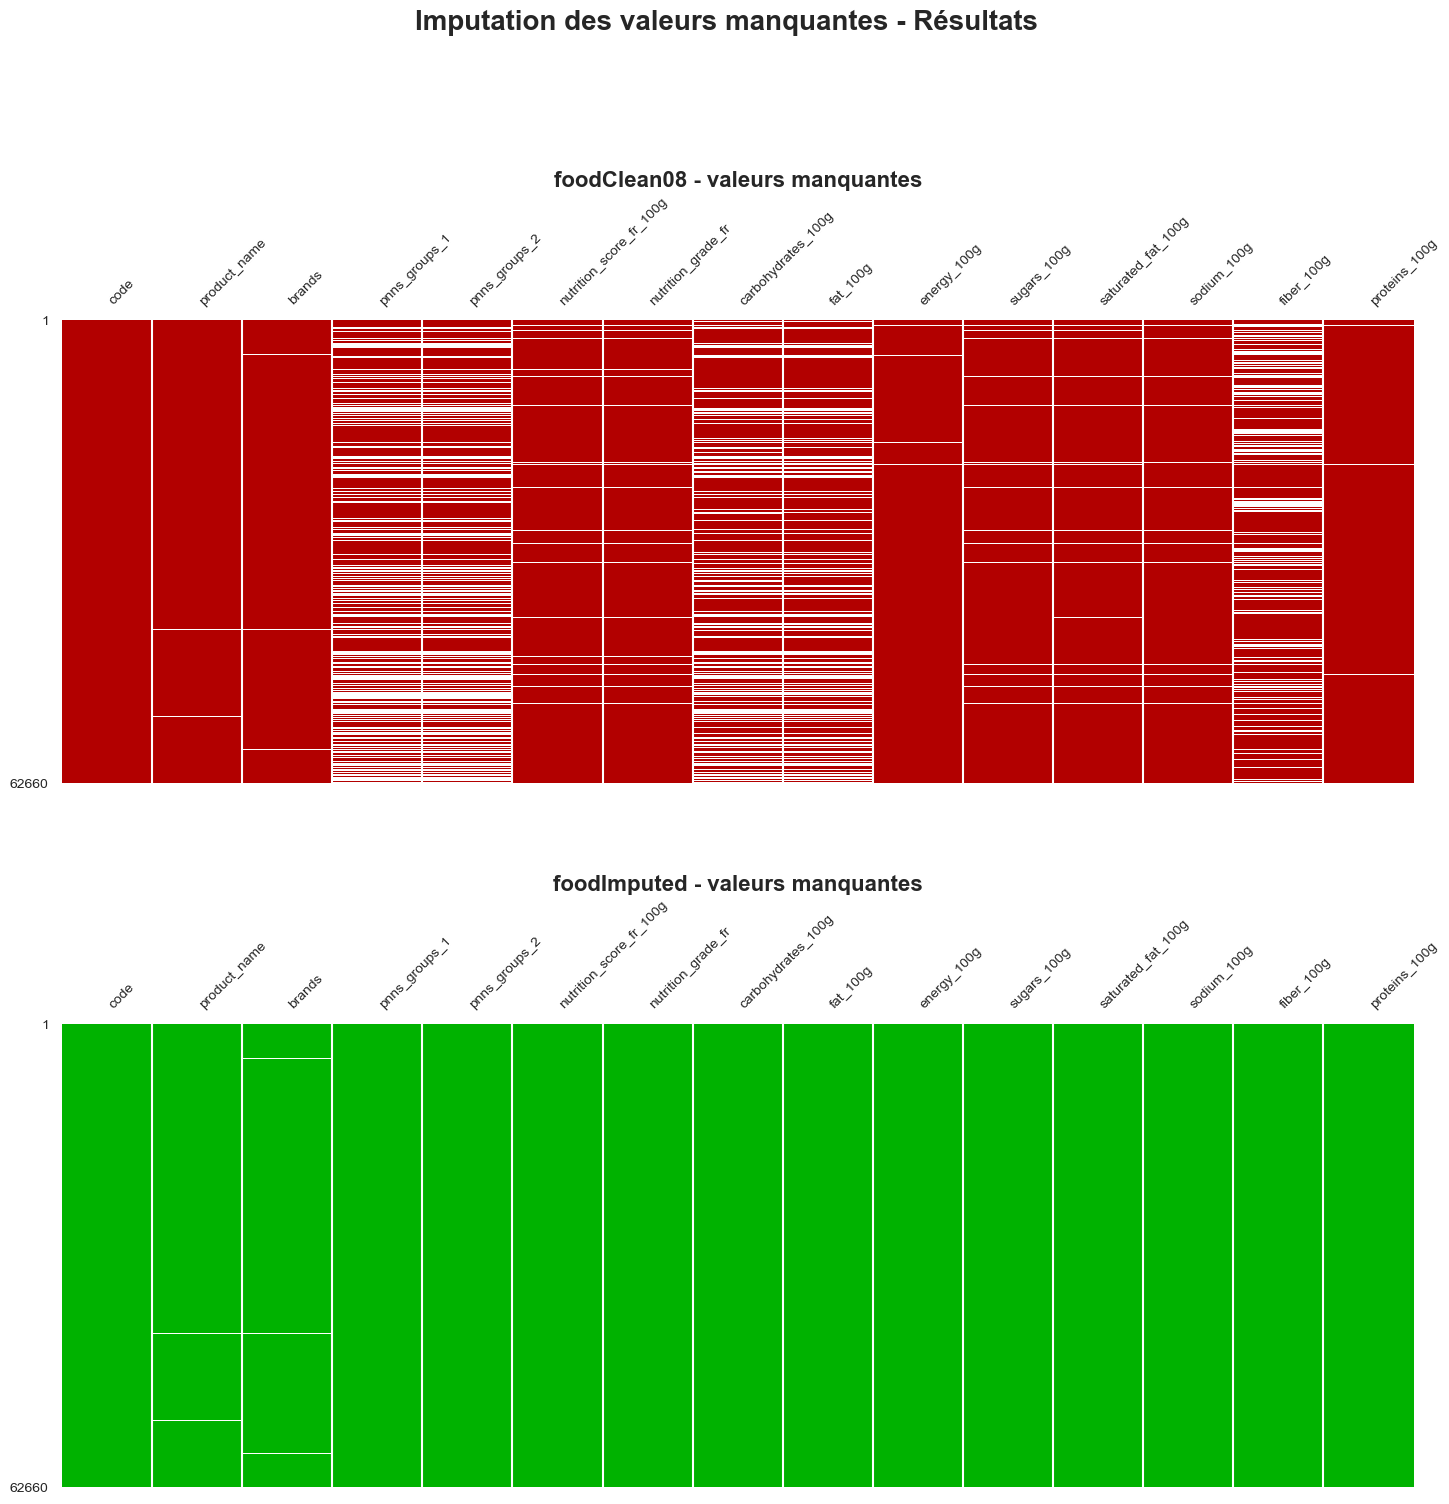

In [156]:
# visualisation of missing values

listOfDf=[foodClean08,foodImputed]
listOfDfNames=["foodClean08","foodImputed"]
listOfColors=[[0.7,0.0,0.0],[0.0,0.7,0.0]]

fig,axs=plt.subplots(len(listOfDf),1,figsize=(16,16))
fig.suptitle("Imputation des valeurs manquantes - Résultats", fontweight="bold",fontsize=20) # set main title

# dataviz of missing data

for i in range(len(listOfDf)) :
    
    ms.matrix(listOfDf[i],color=listOfColors[i],sparkline=False,ax=axs[i]) 
    axs[i].set_title(listOfDfNames[i]+" - valeurs manquantes", fontweight="bold",fontsize=16) 
    axs[i].set_xticklabels(axs[i].get_xticklabels(),fontsize=10)
    axs[i].set_yticklabels(axs[i].get_yticklabels(),fontsize=10)
    
fig.tight_layout(pad=5.0)

plt.show()

### P2.5.8. Dernière étape de nettoyage - valeurs imputées aberrantes<a class="anchor" id="P258"></a>

Les features numériques concernées par les opérations d'imputation sont normalement bornées :
- 0 à 100 pour les masses de composants
- 0 à 3700 pour l'énergie
- -15 à 40 pour le score nutritionnel 

Nous pouvons regarder ce qu'il en est :

In [157]:
foodImputed.describe()

nutrition_score_fr_100g  carbohydrates_100g      fat_100g  \
count             62660.000000        62660.000000  62660.000000   
mean                  8.665711           28.516421     13.412249   
std                   8.952702           27.477941     16.804277   
min                 -15.000000           -0.090002    -13.115528   
25%                   1.000000            4.433061      1.557311   
50%                   8.018600           15.600000      7.000000   
75%                  15.000000           55.000000     21.000000   
max                  43.562673          127.153251    141.650124   

        energy_100g   sugars_100g  saturated_fat_100g   sodium_100g  \
count  62660.000000  62660.000000        62660.000000  62660.000000   
mean    1113.408376     13.284818            5.455039      0.457771   
std      767.208990     18.897399            8.482340      1.653740   
min        0.000000    -11.607198           -9.938438     -0.423706   
25%      433.000000      1.000000            0.300000      0.031496   
50%     1040.000000      4.100000            2.000000      0.223811   
75%     1645.000000     17.000000            7.500000      0.492126   
max     4266.582931    100.000000          100.000000     83.000000   

         fiber_100g  proteins_100g  
count  62660.000000   62660.000000  
mean       2.094445       7.769617  
std        4.118005       7.834489  
min        0.000000       0.000000  
25%        0.000000       1.900000  
50%        0.775000       6.000000  
75%        2.600000      10.900000  
max      100.000000     100.000000

Nous avons donc créé des valeurs aberrantes dans le cadre de nos imputations. Nous faisons le choix de conserver ces produits et de corriger ces valeurs avec la borne associée. 

In [158]:
foodImputed.loc[(foodImputed[foodImputed.select_dtypes("float64").columns]<0).any(axis=1)].sample(5)

code                       product_name  \
213402  3258561110431        Torsades Qualité supérieure   
235946  3502490013852  Pruneaux d'Agen - Maître Prunille   
210716  3256223370155                   Son d'Avoine Bio   
248067  3608580774938         Châtaigne Recette veloutée   
252361  3760061020979                  Fonds d'artichaut   

                                   brands          pnns_groups_1  \
213402  Belle France,Francap Distribution   Cereals and potatoes   
235946                    Maître Prunille  Fruits and vegetables   
210716                                  U   Cereals and potatoes   
248067                             Andros  Fruits and vegetables   
252361                          La Casita  Fruits and vegetables   

       pnns_groups_2  nutrition_score_fr_100g nutrition_grade_fr  \
213402       Cereals                     -1.0                  a   
235946  Dried fruits                     -1.0                  a   
210716       Cereals                     -5.0                  a   
248067        Fruits                     -1.0                  a   
252361    Vegetables                     -6.0                  a   

        carbohydrates_100g  fat_100g  energy_100g  sugars_100g  \
213402                73.0       1.5       1516.0          3.0   
235946                54.9       0.3        980.0         38.2   
210716                56.7       7.7       1573.0          0.9   
248067                33.0       0.5        609.0         27.0   
252361                 2.5       0.5        142.0          1.5   

        saturated_fat_100g  sodium_100g  fiber_100g  proteins_100g  
213402                 0.3     0.007874    0.000000           11.5  
235946                 0.2     0.000400    6.500000            1.9  
210716                 1.4     0.000000   13.500000           12.7  
248067                 0.0     0.015748    2.000000            0.8  
252361                 0.1     0.236220    5.180763            5.8

In [159]:
numFeaturesNames = foodImputed.select_dtypes('float64').columns.tolist()

limitsDict = {}
for col in numFeaturesNames :
    if col=="nutrition_score_fr_100g" :
        limitsDict[col]=(-15,40)
    elif col == "energy_100g" :
        limitsDict[col]=(0,3700)
    else :
        limitsDict[col]=(0,100)

In [160]:
foodImputedLastClean=foodImputed.copy()

In [161]:
for col in numFeaturesNames :
    foodImputedLastClean[col].clip(lower=limitsDict[col][0],upper=limitsDict[col][1],inplace=True)

In [162]:
foodImputedLastClean.describe()

nutrition_score_fr_100g  carbohydrates_100g      fat_100g  \
count             62660.000000        62660.000000  62660.000000   
mean                  8.665654           28.513639     13.439283   
std                   8.952492           27.470042     16.768741   
min                 -15.000000            0.000000      0.000000   
25%                   1.000000            4.433061      1.557311   
50%                   8.018600           15.600000      7.000000   
75%                  15.000000           55.000000     21.000000   
max                  40.000000          100.000000    100.000000   

        energy_100g   sugars_100g  saturated_fat_100g   sodium_100g  \
count  62660.000000  62660.000000        62660.000000  62660.000000   
mean    1113.398929     13.288539            5.461783      0.457783   
std      767.173799     18.894254            8.476914      1.653735   
min        0.000000      0.000000            0.000000      0.000000   
25%      433.000000      1.000000            0.300000      0.031496   
50%     1040.000000      4.100000            2.000000      0.223811   
75%     1645.000000     17.000000            7.500000      0.492126   
max     3700.000000    100.000000          100.000000     83.000000   

         fiber_100g  proteins_100g  
count  62660.000000   62660.000000  
mean       2.094445       7.769617  
std        4.118005       7.834489  
min        0.000000       0.000000  
25%        0.000000       1.900000  
50%        0.775000       6.000000  
75%        2.600000      10.900000  
max      100.000000     100.000000

Nous avons donc bien corrigé ces incohérences :

In [163]:
pd.DataFrame((foodImputedLastClean!=foodImputed)[numFeaturesNames].sum(),columns=["Nb valeurs corrigées"])

Nb valeurs corrigées
nutrition_score_fr_100g                     1
carbohydrates_100g                         29
fat_100g                                  870
energy_100g                                 6
sugars_100g                               126
saturated_fat_100g                        502
sodium_100g                                11
fiber_100g                                  0
proteins_100g                               0

# Partie 3 - Exploration<a class="anchor" id="P3"></a>

Nous allons maintenant pouvoir explorer notre dataset :

In [164]:
food=foodImputedLastClean.copy()

## P3.1. - Analyses univariées<a class="anchor" id="P31"></a>

Regardons tout d'abord une rapide description de nos données.

In [165]:
food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62660 entries, 106 to 320763
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   code                     62660 non-null  object  
 1   product_name             62278 non-null  object  
 2   brands                   62253 non-null  object  
 3   pnns_groups_1            62660 non-null  category
 4   pnns_groups_2            62660 non-null  category
 5   nutrition_score_fr_100g  62660 non-null  float64 
 6   nutrition_grade_fr       62660 non-null  category
 7   carbohydrates_100g       62660 non-null  float64 
 8   fat_100g                 62660 non-null  float64 
 9   energy_100g              62660 non-null  float64 
 10  sugars_100g              62660 non-null  float64 
 11  saturated_fat_100g       62660 non-null  float64 
 12  sodium_100g              62660 non-null  float64 
 13  fiber_100g               62660 non-null  float64 
 14  pro

In [166]:
myDescribe(food)

RadioButtons(description='Which features :', options=('quantitative', 'qualitative', 'all'), style=Description…

Output()

Suite aux opérations de nettoyage, pour nos features numériques, les valeurs minimales, maximales, écarts-types et médianes semblent cohérentes.

On peut regarder l'impact de nos imputations sur les distributions empiriques de nos features.

In [167]:
foodColList = food.columns.tolist()
foodColList.remove("code")
foodColList.remove("product_name")
foodColList.remove("brands")

In [168]:
compareDfDistribs(newDf=food,oldDf=foodClean08,colList=foodColList,dictPalette=foodPaletteDict)

Dropdown(description='Feature :', options=('pnns_groups_1', 'pnns_groups_2', 'nutrition_score_fr_100g', 'nutri…

Output()

Nous pouvons remarquer que nos imputations ont globalement **peu perturbé** la distribution de nos features.

Pour la suite nous allons étudier les relations entre le score nutritionnel et le type de produit. Nous allons donc regarder plus en détail cette feature :

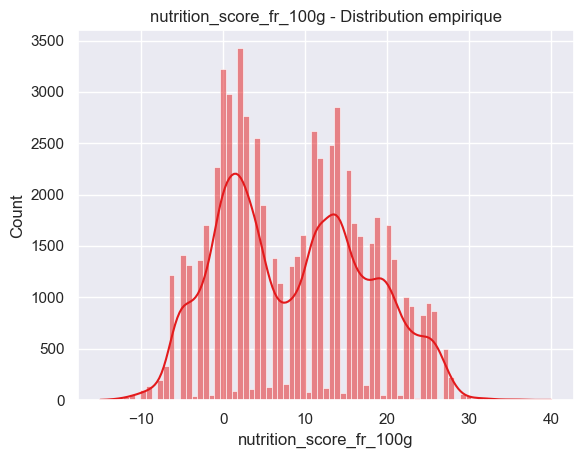

In [169]:
# draw empirical distribution of "nutrition_score_fr_100g"

sns.histplot(data=food,x="nutrition_score_fr_100g",color=foodPaletteDict["nutrition_score_fr_100g"],kde=True) # draw
plt.title("nutrition_score_fr_100g - Distribution empirique"); # set title

## P3.2. - Analyse bivariée - ANOVA sur `'nutrition_score_fr_100g ~ pnns_groups_1'`  <a class="anchor" id="P32"></a>

### P3.2.1. - Question & Hypothèses<a class="anchor" id="P321"></a>

Dans le cadre du futur développement de l'app, il serait intéressant de savoir s'il serait pertinent d'utiliser la catégorie d'un produit pour mieux prédire son score nutritionnel ?

Entre d'autres termes, y-a-t-il une différence significative entre les nutriscores des différentes catégories de 'pnns_groups_1' ?

Pour répondre à cette question nous allons réaliser une ANOVA (Analysis of Variance).

Les présupposés associés à ce test paramétrique sont les suivantes :
- les distributions des résiduels associées à chaque modalité de "pnns_groups_1" sont normales
- ces distributions ont la même variance
- les données de chaque distributions sont indépendantes

Les hypothèses associées à l'ANOVA sont :
- H0 : les distributions sont similaires (leurs moyennes empiriques sont identiques)
- H1 : au moins une distribution est différente

### P3.2.2. - ANOVA - premier essai<a class="anchor" id="P322"></a>

Afin de réaliser notre One-way ANOVA, nous allons utiliser la fonction créée plus haut :

In [170]:
foodAnova,foodAnovaTable = myOneWayAnova (df=food,categFeatureName="pnns_groups_1",numFeatureName="nutrition_score_fr_100g",alpha=0.05)


Avant de tirer des conclusions, nous devons regarder les présuposés de notre ANOVA :
1. Normalité des residuels
2. Groupes de même variance
3. Données de chaque distributions sont indépendantes.

Le 3. est confirmé : Nous n'avons pas de doublons et chaque produit ne peut appartenir qu'à une catégorie.
Regardons ce qu'il en est de l'hypothèse de normalité :

In [171]:
# create a dataframe with residuals of our ANOVA
foodResiduals=food[["pnns_groups_1"]].copy()
foodResiduals["nutriResiduals"]=foodAnova.resid

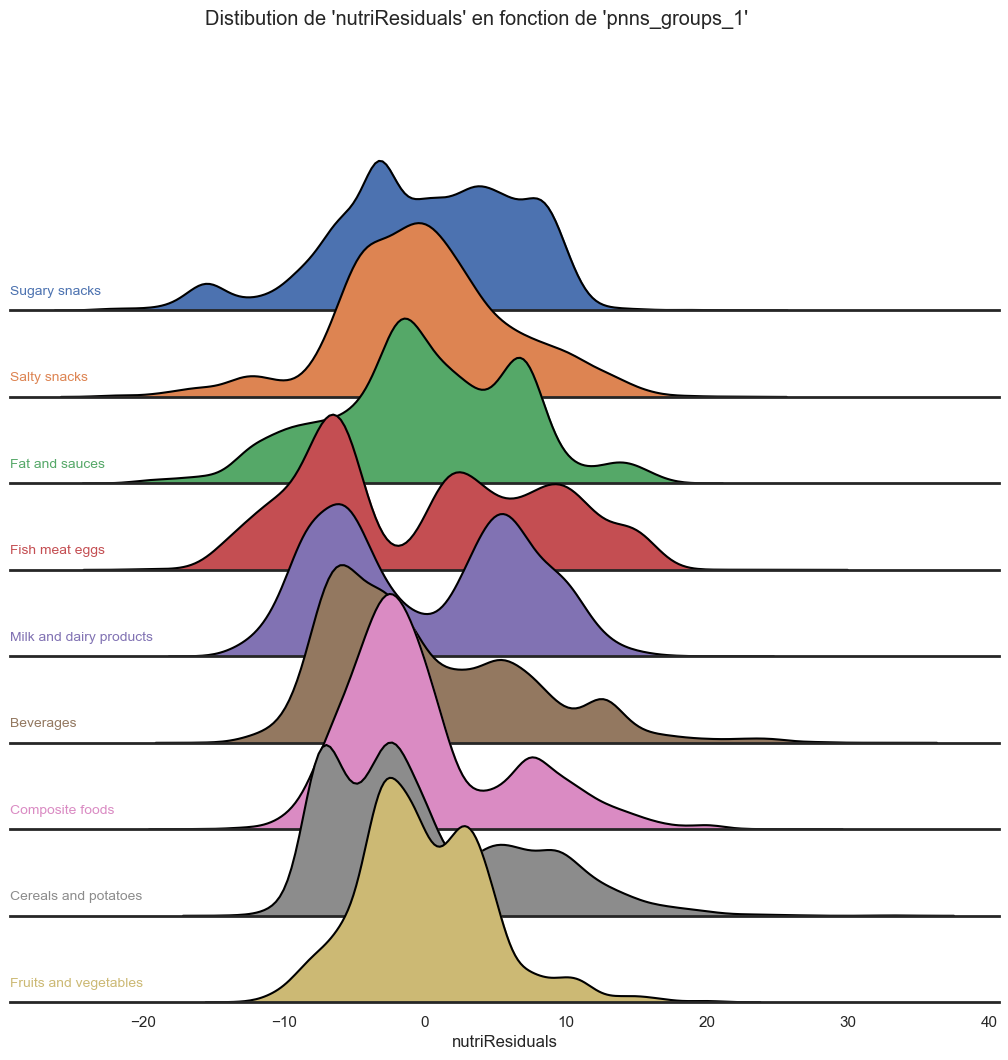

In [172]:
myOrder = food.groupby("pnns_groups_1")["nutrition_score_fr_100g"].median().sort_values(ascending=False).index.tolist()
distribRidgePlot(df=foodResiduals, categFeatureName="pnns_groups_1", numFeatureName="nutriResiduals",order=myOrder,overlap=0.65)

Nos distributions ne suivent pas la loi normale. Cependant notre jeu de données est conséquent (62660 produits), nous pouvons donc considérer que la violation du critère de normalité ne remet pas en cause la validité de notre test.

Regardons ce que cela donne pour le critère d'homogénéité de la variance :

In [173]:
varByPnns1=foodResiduals.groupby("pnns_groups_1").var()
varByPnns1.rename(columns={"nutriResiduals":"Nutri_variance"},inplace=True)
varByPnns1

Nutri_variance
pnns_groups_1                          
Beverages                     48.928836
Cereals and potatoes          46.000006
Composite foods               34.564053
Fat and sauces                44.124703
Fish meat eggs                70.696709
Fruits and vegetables         21.898147
Milk and dairy products       48.738368
Salty snacks                  37.122010
Sugary snacks                 43.164053

Les variances ne sont pas homogènes. On peut confirmer visuellement cela avec des boxplots :

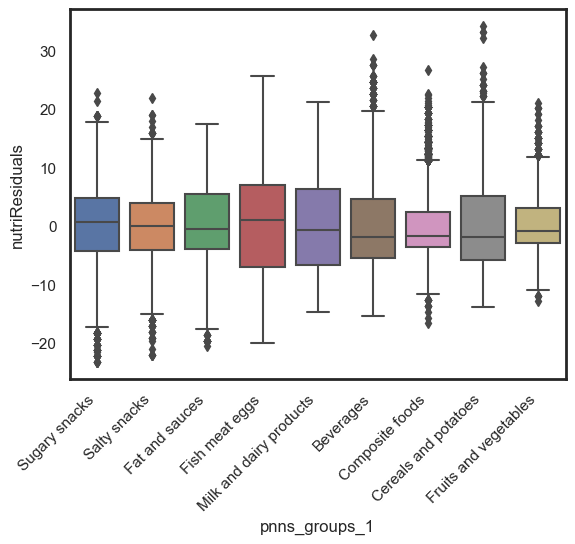

In [174]:
fig,ax = plt.subplots(1)

sns.boxplot(data=foodResiduals,
            x="pnns_groups_1",
            y="nutriResiduals",
            ax=ax,
            order=myOrder)
ax.set_xticklabels(myOrder,
                   rotation=45,
                  ha="right",
                  va='top')
plt.show()

Afin de se faire une idée plus précise, nous allons mener un test d'homogénéité de la variance :

In [175]:
stats.levene(food.loc[food["pnns_groups_1"]=='Sugary snacks','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Cereals and potatoes','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Beverages','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Composite foods','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Fruits and vegetables','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Fish meat eggs','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Milk and dairy products','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Salty snacks','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Fat and sauces','nutrition_score_fr_100g'],
            )

LeveneResult(statistic=461.0574487329923, pvalue=0.0)

Le test Levene est positif, ce qui indique que les groupes ont bien des variances significativement différentes.

Une méthode pour remédier à cette violation du postulat d'homogénéité de la variance et de considérer des groupes de même taille. Regardons la taille de nos groupes :

In [176]:
food.groupby("pnns_groups_1")["nutrition_score_fr_100g"].count()

pnns_groups_1
Beverages                   5944
Cereals and potatoes        8548
Composite foods             8181
Fat and sauces              4634
Fish meat eggs              7108
Fruits and vegetables       4095
Milk and dairy products     8318
Salty snacks                2867
Sugary snacks              12965
Name: nutrition_score_fr_100g, dtype: int64

Le nombre d'occurrences de chaque modalité n'est pas homogène. 

Nous faisons le choix de générer un dataframe spécifique pour notre ANOVA, avec des tailles de groups identiques :

In [177]:
# create a specific dataframe for ANOVA test on "pnns_groups_1"~"nutrition_score_fr_100g"

# store the minimum size of "pnns_groups_1"
groupSize=food.groupby("pnns_groups_1")["nutrition_score_fr_100g"].count().min()

# choose random samples of our dataframe based on "pnns_groups_1" labels, each with same size
foodForAnova=pd.DataFrame()
for cat1 in food["pnns_groups_1"].unique() :
    foodForAnova=pd.concat([
        foodForAnova,
        food.loc[food["pnns_groups_1"]==cat1,["pnns_groups_1","nutrition_score_fr_100g"]].sample(n=groupSize)
    ])

foodForAnova=foodForAnova.sort_index()

### P3.2.3. - ANOVA - second essai<a class="anchor" id="P323"></a>

Nous pouvons maintenant conduire notre test one-way ANOVA :

In [178]:
foodAnovaBIS,foodAnovaTableBIS = myOneWayAnova (
    df=foodForAnova,
    categFeatureName="pnns_groups_1",
    numFeatureName="nutrition_score_fr_100g",
    alpha=0.05)

Regardons si l'échantillonnage n'a pas modifié nos distributions :

In [179]:
# create a dataframe with residuals of our ANOVA
foodResidualsBIS=foodForAnova[["pnns_groups_1"]].copy()
foodResidualsBIS["nutriResiduals"]=foodAnovaBIS.resid

In [180]:
# create a dataframe with values of both residuals to compare distributions shapes
compareShape=foodResiduals.copy()
compareShape["nutriResiduals"]=compareShape["nutriResiduals"]+50 # create an offset on values of our first residuals
compareShape=pd.concat([compareShape,foodResidualsBIS],axis=0).reset_index() # concatenate both dataframes

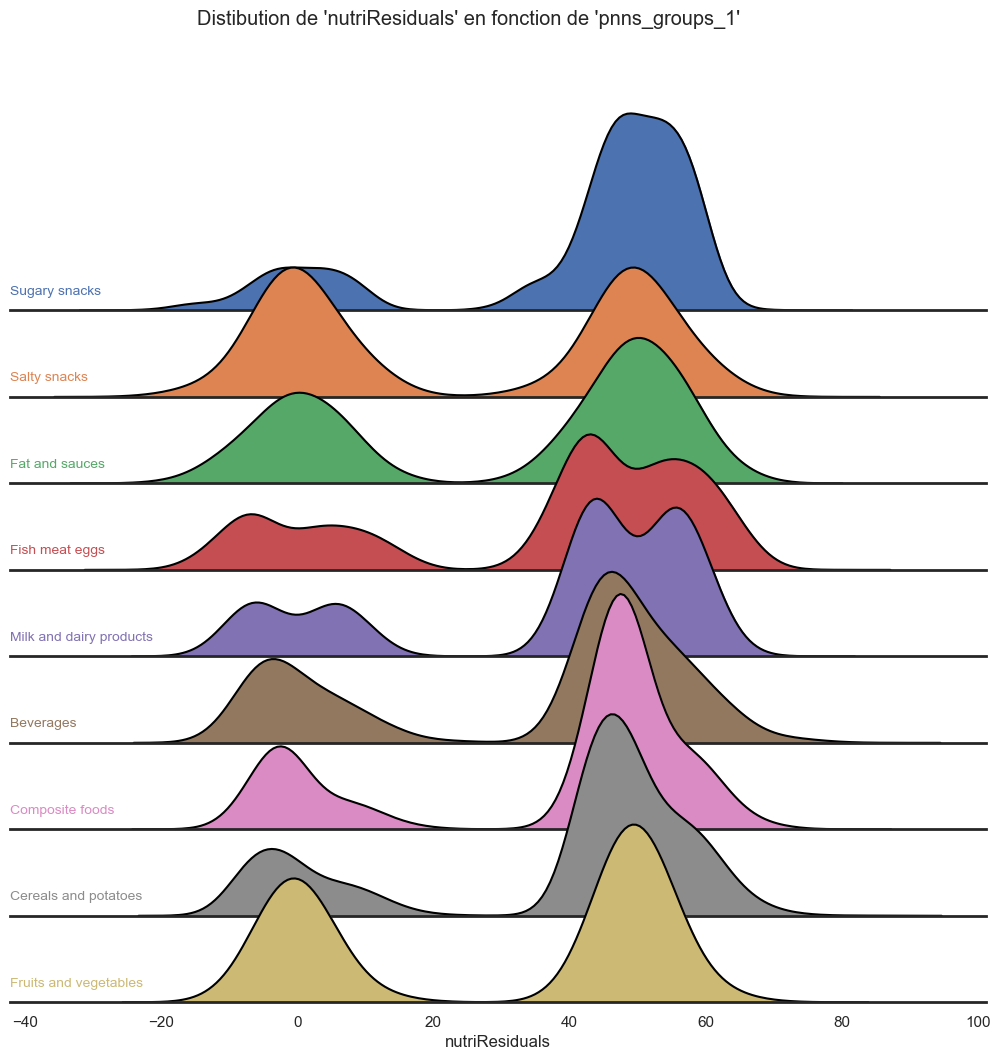

In [181]:
# display distributions
distribRidgePlot(
    df=compareShape, 
    categFeatureName="pnns_groups_1", 
    numFeatureName="nutriResiduals",
    order=myOrder,
    overlap=0.65)

Cela n'a pas d'impact important. Maintenant que nous avons :
- vérifié nos postulats, 
- puis trouvé des solutions correctives le cas échéant, 
- effectué une seconde ANOVA sur ces bases

nous pouvons analyser notre nouvelle table d'ANOVA :

### P3.2.4. - ANOVA - interprétation<a class="anchor" id="P324"></a>

In [182]:
# display one-way ANOVA table for "nutrition_score_fr_100g ~ pnns_groups_1"
foodAnovaTableBIS

Sum_of_Squares  Degrees_Freedom    Mean_Square  F_statistic  \
Model             8.451822e+05              8.0  105647.776022  2429.258578   
Residual_Error    1.121774e+06          25794.0      43.489720          NaN   
Total             1.966956e+06          25802.0            NaN          NaN   

                Critical_F  F_test_p_value  Eta_Square  
Model             1.938771             0.0     0.42969  
Residual_Error         NaN             NaN         NaN  
Total                  NaN             NaN         NaN

La **p-value** est bien inférieure à notre seuil de 0.05.
Notre **statistique F** est elle bien supérieure à sa valeur critique.

On peut donc **rejeter l'hypothèse nulle** selon laquelle les moyennes des différents groupes sont toutes égales.

***Nota :*** *On remarque instantanément l'impact de la taille de notre dataset sur le test ANOVA :*
- *Le* ***nombre de degrès de libertés*** *affectant la variance intraclasse* ***MSE*** *la conduit à prendre une valeur* ***très faible***
- *La* ***statistique F*** *avait donc de* ***grandes chances d'être supérieure à sa valeur critiques***
- *La* ***p-value*** *, la probabilité sous l'hypothèse nulle d'avoir obtenu cette statistique F avait par conséquent* ***elle aussi de grande chance d'être faible***

*Mais cela ne veut pas dire pour autant que notre test n'a pas détecté de différence : celle-ci (ou celles-ci) peut être juste très petite.*

Nous alors regarder **eta squared** pour mieux nous rendre compte de la **taille de cet effet**.

Eta squared est égale à **0.43**, ce qui veut dire que **notre modèle explique 43% de la variance du score nutritionnel**, ou encore qu'**on obtient 43% de réduction de variance sur le score nutritionnel lorsque l'on prend en compte la catégorie de "pnns_groups_1"**.

### P3.2.5. - ANOVA - test avec des échantillons plus petits<a class="anchor" id="P325"></a>

In [183]:
# create another specific dataframe for ANOVA test on "pnns_groups_1"~"nutrition_score_fr_100g"

# store the minimum size of "pnns_groups_1"
groupSize=5

# choose random samples of our dataframe based on "pnns_groups_1" labels, each with same size
foodForAnovaTER=pd.DataFrame()
for cat1 in food["pnns_groups_1"].unique() :
    foodForAnovaTER=pd.concat([
        foodForAnovaTER,
        food.loc[food["pnns_groups_1"]==cat1,["pnns_groups_1","nutrition_score_fr_100g"]].sample(n=groupSize)
    ])

foodForAnovaTER=foodForAnovaTER.sort_index()

In [184]:
foodAnovaTER,foodAnovaTableTER = myOneWayAnova (
    df=foodForAnovaTER,
    categFeatureName="pnns_groups_1",
    numFeatureName="nutrition_score_fr_100g",
    alpha=0.05)

In [185]:
foodAnovaTableTER

Sum_of_Squares  Degrees_Freedom  Mean_Square  F_statistic  \
Model              1974.311867              8.0   246.788983     5.052243   
Residual_Error     1758.506876             36.0    48.847413          NaN   
Total              3732.818743             44.0          NaN          NaN   

                Critical_F  F_test_p_value  Eta_Square  
Model             2.208518        0.000296    0.528906  
Residual_Error         NaN             NaN         NaN  
Total                  NaN             NaN         NaN

Le test est aussi concluant avec un échantillon plus petit.

## P3.3. - ACP  <a class="anchor" id="P33"></a>

Nous pouvons xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx dire qu'on ne met pas nutrition score

In [228]:
pcaColNames=foodImputed.select_dtypes("float64").columns.tolist()
pcaColNames.remove("nutrition_score_fr_100g")
pcaColNames

['carbohydrates_100g',
 'fat_100g',
 'energy_100g',
 'sugars_100g',
 'saturated_fat_100g',
 'sodium_100g',
 'fiber_100g',
 'proteins_100g']

In [724]:
%time X_scaled, Xidx, Xfeat, foodPCA = myPCA (df=food,q=6,ACPfeatures=pcaColNames)

Wall time: 97.9 ms


### P3.3.1. - ACP - Éboulis des valeurs propres <a class="anchor" id="P331"></a>

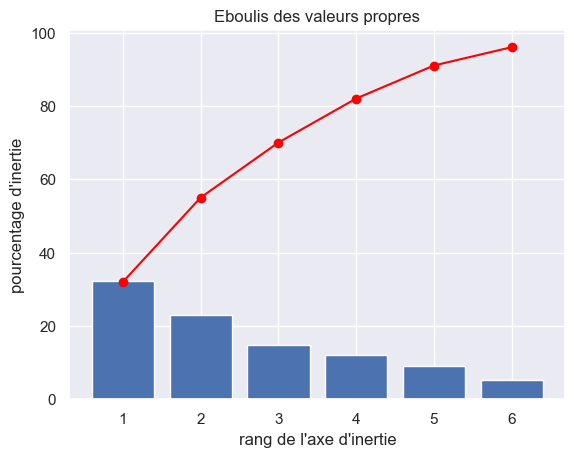

In [246]:
PCA_scree_plot(foodPCA)

### P3.3.2. - ACP - Matrice des correlations variables / loadings <a class="anchor" id="P332"></a>

Nous pouvons regarder la **correlation** entre nos **features et les composantes principales** (projections de nos produits sur les axes principaux).
Pour cela nous utiliserons la fonction écrite plus haut et en profiterons pour **afficher également la correlation entre la variable "nutrition_score_fr_100g" et ces même composantes** :

In [543]:
heatPcaCorrelationMatrixWid (df=food,
                                 X_scaled=X_scaled,
                                 pca=foodPCA,  
                                 PcafeaturesNames=Xfeat,
                                 figsize=(12,5)
                                )

Dropdown(description='Additionnal variable :', options={'nutrition_score_fr_100g': (array([[ 1.51025221,  0.39…

Output()

- F1 : produits gras
- F2 : produits peu sucrés, peu riches en glucide
- F3 : produits riches en fibres et protéines
- F4 : produits salés
- F5 : produits peu riches en protéines
- F6 : ?

In [193]:
(featuresOnFactorialAxes**2).iloc[:,0:3].sum(axis=1)/(featuresOnFactorialAxes**2).sum(axis=1)

nutrition_score_fr_100g    0.868519
carbohydrates_100g         0.901782
fat_100g                   0.905978
energy_100g                0.897107
sugars_100g                0.873807
saturated_fat_100g         0.904954
sodium_100g                0.048427
fiber_100g                 0.752081
proteins_100g              0.557745
dtype: float64

In [723]:
%time X_scaledB, XidxB, XfeatB, foodPCAB = myPCA (df=food,q=8,ACPfeatures=pcaColNames)

Wall time: 27 ms


In [726]:
foodPCAB.explained_variance_ratio_.sum()

1.0

In [727]:
foodPCA.explained_variance_ratio_.sum()

0.9646928440594147

In [729]:
cos2=pcaCorrelationMatrix (foodPCAB,
                          XfeatB,
                          additionnalVariable=None
                          )**2
cos2.sum(axis=1)

carbohydrates_100g    1.000016
fat_100g              1.000016
energy_100g           1.000016
sugars_100g           1.000016
saturated_fat_100g    1.000016
sodium_100g           1.000016
fiber_100g            1.000016
proteins_100g         1.000016
dtype: float64

### P3.3.3. - ACP - Cercle des correlations <a class="anchor" id="P333"></a>

In [410]:
correlation_graph_enhanced_WID(df=food,
                               X_scaled=X_scaled,
                               pca=foodPCA,  
                               PcafeaturesNames=Xfeat,
                               dictPalette=foodPaletteDict,
                               figsize=(7,7),
                               )

Output()

In [417]:
foodOnPrincipalComp.corr()

nutrition_score_fr_100g            F1            F2  \
nutrition_score_fr_100g                 1.000000  7.012442e-01 -5.930305e-03   
F1                                      0.701244  1.000000e+00 -4.985209e-17   
F2                                     -0.005930 -4.985209e-17  1.000000e+00   
F3                                     -0.224418 -6.982072e-17 -1.152222e-16   
F4                                      0.215880 -1.338289e-16 -5.087107e-17   
F5                                     -0.164801 -1.696532e-16 -1.174260e-16   
F6                                      0.185885 -3.893398e-16  7.678020e-16   

                                   F3            F4            F5  \
nutrition_score_fr_100g -2.244181e-01  2.158797e-01 -1.648010e-01   
F1                      -6.982072e-17 -1.338289e-16 -1.696532e-16   
F2                      -1.152222e-16 -5.087107e-17 -1.174260e-16   
F3                       1.000000e+00 -8.689861e-16 -1.820144e-16   
F4                      -8.689861e-16  1.000000e+00  4.815156e-16   
F5                      -1.820144e-16  4.815156e-16  1.000000e+00   
F6                       1.389113e-16 -9.528566e-17 -4.627341e-16   

                                   F6  
nutrition_score_fr_100g  1.858850e-01  
F1                      -3.893398e-16  
F2                       7.678020e-16  
F3                       1.389113e-16  
F4                      -9.528566e-17  
F5                      -4.627341e-16  
F6                       1.000000e+00

<AxesSubplot:xlabel='F1', ylabel='nutrition_score_fr_100g'>

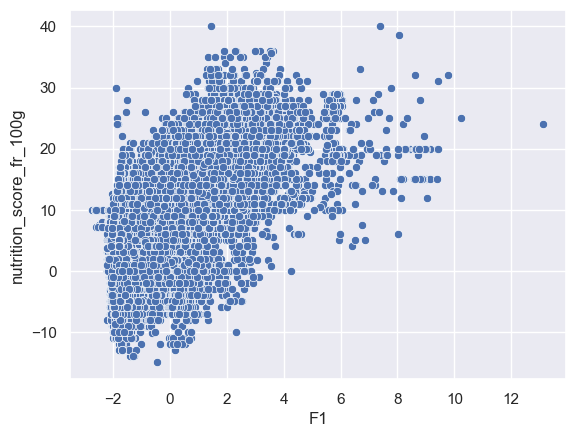

In [416]:
sns.scatterplot(data=foodOnPrincipalComp,x="F1",y="nutrition_score_fr_100g")

In [411]:
foodOnPrincipalComp=pd.concat(
    [
        food[[col for col in foodImputed.columns if col not in Xfeat]],
        pd.DataFrame(
            foodPCA.transform(X_scaled),
            index=Xidx,
            columns=["F"+str(i+1) for i in range(foodPCA.n_components_)])
    ],
    axis=1
)
foodOnPrincipalComp.sort_values("F1",ascending=False)

code                         product_name  \
283105  6091035082004                                  Eau   
246934  3596710411962                   Gateau Au Chocolat   
256886  4001686304792           Haribo Goldbären Dose 450G   
279935  5419980014634                     Pates A Tartiner   
219970  3270190118800  Huile De Tournesol Végétale 2 Litre   
...               ...                                  ...   
214761  3263850052316            Sel fin iodé - sel de mer   
233364  3445850024023                      Sel de Guérande   
243550  3564709000374                  Sel fin de Guérande   
243666  3564709035956               Sel Fin de l'Île de Ré   
233372  3445850070259          Sel de Guérande Label Rouge   

                                   brands   pnns_groups_1  \
283105                              Vital   Sugary snacks   
246934                             Auchan       Beverages   
256886                             Haribo       Beverages   
279935                                NAo   Sugary snacks   
219970                          Carrefour  Fat and sauces   
...                                   ...             ...   
214761                       Leader Price  Fat and sauces   
233364                      Le guerandais  Fat and sauces   
243550          Nos regions ont du talent  Fat and sauces   
243666  Nos Régions ont du Talent,Leclerc  Fat and sauces   
233372                      Le guerandais  Fat and sauces   

               pnns_groups_2  nutrition_score_fr_100g nutrition_grade_fr  \
283105    Chocolate products                     24.0                  e   
246934   Sweetened beverages                     25.0                  e   
256886            Appetizers                     32.0                  e   
279935    Chocolate products                     31.0                  e   
219970                  Fats                     20.0                  e   
...                      ...                      ...                ...   
214761  Dressings and sauces                     10.0                  c   
233364  Dressings and sauces                     10.0                  c   
243550  Dressings and sauces                     10.0                  c   
243666  Dressings and sauces                     10.0                  c   
233372  Dressings and sauces                     10.0                  c   

               F1        F2         F3         F4         F5         F6  
283105  13.126175  1.556541  19.560737  -5.684988   7.826256  13.948693  
246934  10.243647  1.542361  10.987584  -2.587324   6.664619  10.125470  
256886   9.780452  1.006803  12.553043  -1.473224  14.978124   8.130957  
279935   9.413606  0.814376   0.514687  -0.229603   2.961788   3.581663  
219970   9.412114  5.165483  -4.155201  -0.073340   2.762814   2.819941  
...           ...       ...        ...        ...        ...        ...  
214761  -2.611519  3.965402   5.265977  22.410489   2.661296  -0.147783  
233364  -2.611519  3.965402   5.265977  22.410489   2.661296  -0.147783  
243550  -2.611519  3.965402   5.265977  22.410489   2.661296  -0.147783  
243666  -2.611519  3.965402   5.265977  22.410489   2.661296  -0.147783  
233372  -2.715723  4.868276   6.796769  28.065399   3.182806  -0.194093  

[62660 rows x 13 columns]

### P3.3.4. - ACP - Projection sur plans principaux <a class="anchor" id="P333"></a>

In [194]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """
    
    sns.set_theme()
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.axis('scaled') 
    plt.show()



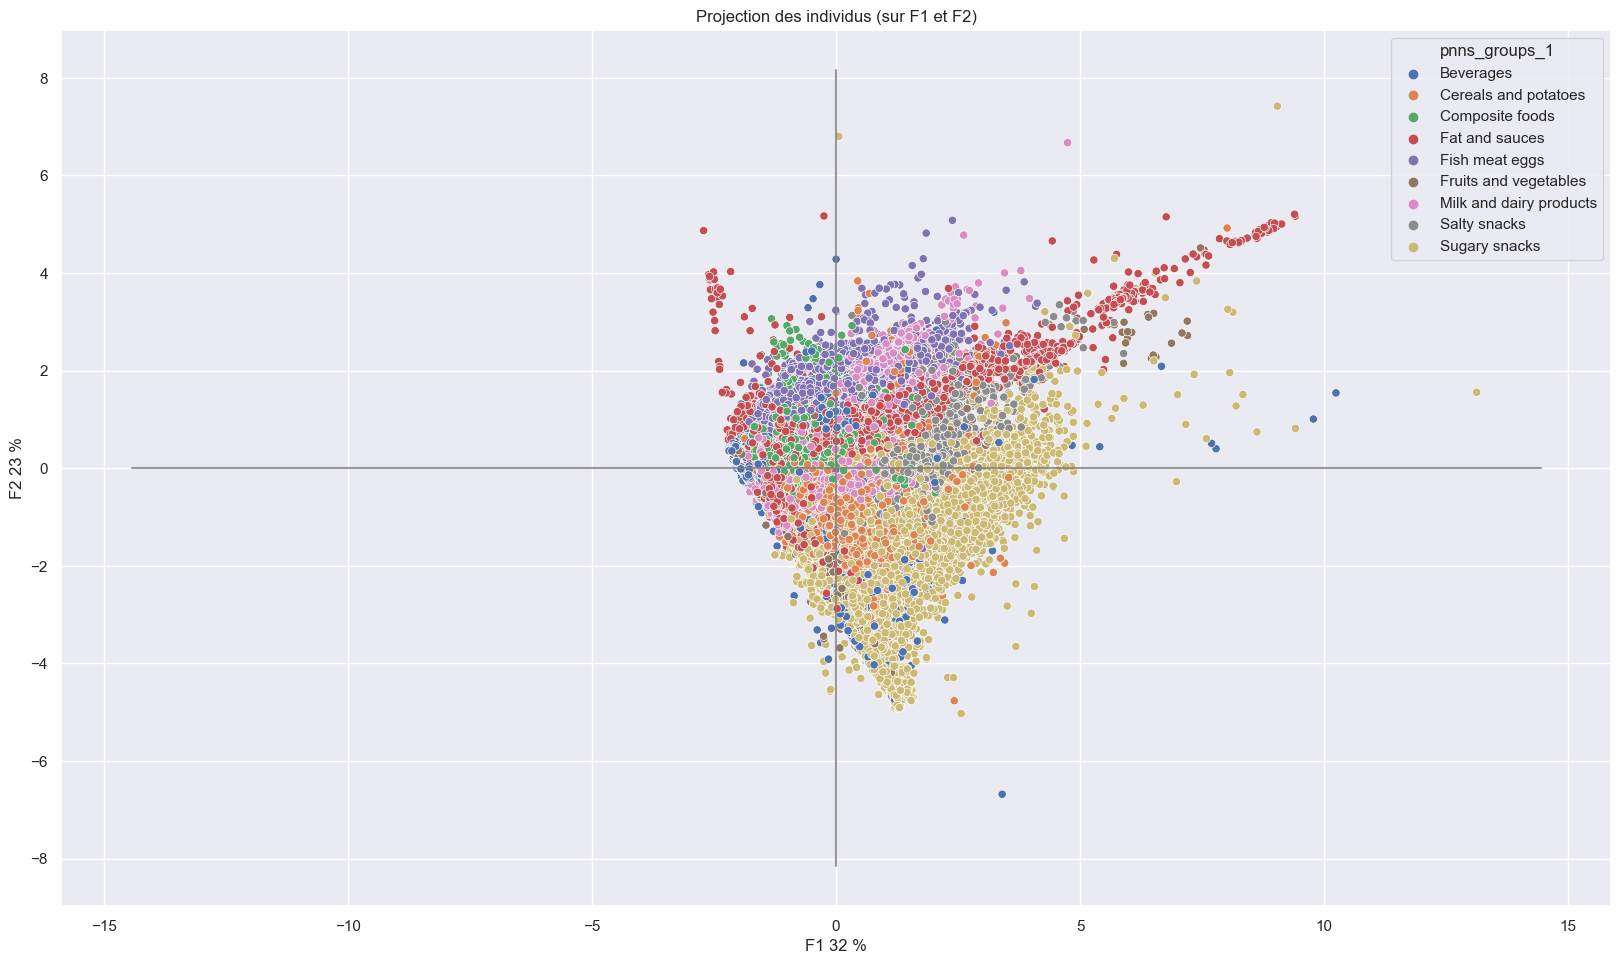

In [418]:
x_y = [0,1]
display_factorial_planes(foodPCA.transform(X_scaled), x_y, foodPCA, labels=None, figsize=(20,16), clusters=food["pnns_groups_1"], marker="o")

# Tests -  F1 & cat

In [196]:
foodOnPrincipalComp["F1"].describe()

count    6.266000e+04
mean    -1.521782e-16
std      1.782307e+00
min     -2.800590e+00
25%     -1.482322e+00
50%     -4.534824e-01
75%      1.249232e+00
max      1.102171e+01
Name: F1, dtype: float64

<AxesSubplot:xlabel='count', ylabel='pnns_groups_1'>

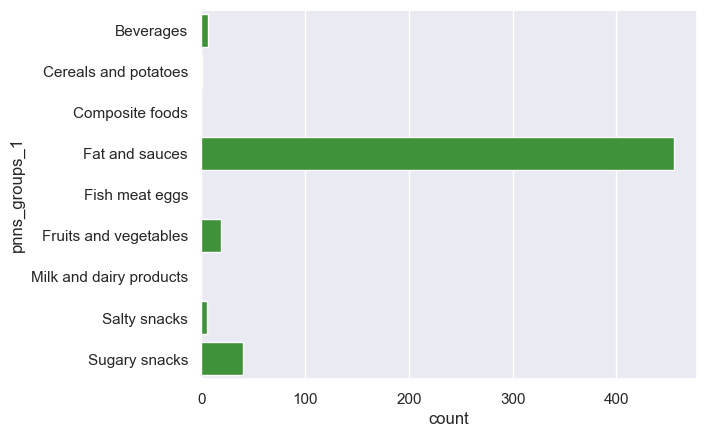

In [197]:
featureName="pnns_groups_1"
inter=(5,100)
F="F1"

test=foodOnPrincipalComp.loc[(foodOnPrincipalComp[F]>inter[0])&(foodOnPrincipalComp[F]<inter[1])]

sns.countplot(data=test,y=featureName,color=foodPaletteDict[featureName])

<AxesSubplot:xlabel='count', ylabel='pnns_groups_1'>

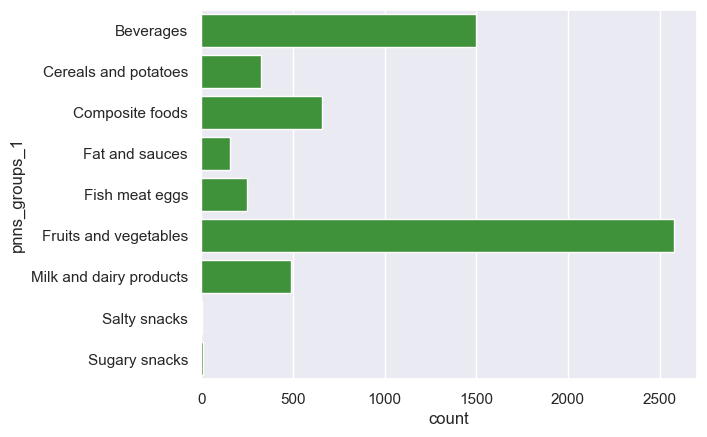

In [198]:
featureName="pnns_groups_1"
inter=(-100,-2)
F="F1"

test=foodOnPrincipalComp.loc[(foodOnPrincipalComp[F]>inter[0])&(foodOnPrincipalComp[F]<inter[1])]

sns.countplot(data=test,y=featureName,color=foodPaletteDict[featureName])

In [199]:
test.groupby(["pnns_groups_1"])["code"].count().reset_index()


pnns_groups_1  code
0                Beverages  1499
1     Cereals and potatoes   324
2          Composite foods   657
3           Fat and sauces   157
4           Fish meat eggs   251
5    Fruits and vegetables  2576
6  Milk and dairy products   487
7             Salty snacks     4
8            Sugary snacks    11

In [200]:
testBIS=test.groupby(["pnns_groups_1","nutrition_grade_fr"])["code"].count().reset_index()
testBIS

pnns_groups_1 nutrition_grade_fr  code
0                 Beverages                  a   239
1                 Beverages                  b   868
2                 Beverages                  c   391
3                 Beverages                  d     1
4                 Beverages                  e     0
5      Cereals and potatoes                  a   282
6      Cereals and potatoes                  b    42
7      Cereals and potatoes                  c     0
8      Cereals and potatoes                  d     0
9      Cereals and potatoes                  e     0
10          Composite foods                  a   428
11          Composite foods                  b   159
12          Composite foods                  c    70
13          Composite foods                  d     0
14          Composite foods                  e     0
15           Fat and sauces                  a    66
16           Fat and sauces                  b    84
17           Fat and sauces                  c     7
18           Fat and sauces                  d     0
19           Fat and sauces                  e     0
20           Fish meat eggs                  a   243
21           Fish meat eggs                  b     8
22           Fish meat eggs                  c     0
23           Fish meat eggs                  d     0
24           Fish meat eggs                  e     0
25    Fruits and vegetables                  a  2077
26    Fruits and vegetables                  b   441
27    Fruits and vegetables                  c    58
28    Fruits and vegetables                  d     0
29    Fruits and vegetables                  e     0
30  Milk and dairy products                  a   344
31  Milk and dairy products                  b   143
32  Milk and dairy products                  c     0
33  Milk and dairy products                  d     0
34  Milk and dairy products                  e     0
35             Salty snacks                  a     3
36             Salty snacks                  b     0
37             Salty snacks                  c     1
38             Salty snacks                  d     0
39             Salty snacks                  e     0
40            Sugary snacks                  a     9
41            Sugary snacks                  b     2
42            Sugary snacks                  c     0
43            Sugary snacks                  d     0
44            Sugary snacks                  e     0

In [202]:
foodOnPrincipalComp["F1"].quantile([0.4,0.6])

0.4   -0.861342
0.6    0.244353
Name: F1, dtype: float64

In [206]:
l=foodOnPrincipalComp.select_dtypes("category").columns.tolist()
l.append(None)
l

['pnns_groups_1', 'pnns_groups_2', 'nutrition_grade_fr', None]

In [212]:
# create a palette for "nutrition_grade_fr"
nutriPalette= {"a": "#02663B",
           "b": "#8DC83E",
           "c" : "#F4E300",
           "d" : "#F7941D",
           "e" : "#C31D2A",
           }

In [225]:


   
# def widRangeSelection(df, numFeatureName) :
#     rangeValue=[df[numFeatureName].median()-0.5*df[numFeatureName].std(),
#                 df[numFeatureName].median()+0.5*df[numFeatureName].std()]
    
#     ui = widgets.FloatRangeSlider(value=rangeValue,
#                                     min=df[numFeatureName].min(),
#                                     max=df[numFeatureName].max(),
#                                     step=0.01,
#                                     description="Range for "+numFeatureName+" :",
#                                     disabled=False,
#                                     style={'description_width': 'initial'}
#                                     )
#     display (ui)
#     return ui




def displayByInterval (df, numFeatureName, thetaCatFeatureName, filterRange,colorCatFeatureName=None,palette=None,r_autoscale=True) :
    mask=(df[numFeatureName]>=filterRange[0])&(df[numFeatureName]<=filterRange[1])
    filteredDf=df.loc[mask]
    countCol=filteredDf.notna().sum().idxmax()
    if colorCatFeatureName :
        groupByCol=[thetaCatFeatureName,colorCatFeatureName]
    else :
        groupByCol=thetaCatFeatureName
    countDf=filteredDf.groupby(groupByCol)[countCol].count().reset_index()
    import plotly.express as px

    # handle palette
    if palette :
        if colorCatFeatureName  :
            if len(palette)!=df[colorCatFeatureName].nunique() :
                palette=None
        else :
            palette=None

    
    fig=px.bar_polar(countDf, 
                     r=countCol, 
                     theta=thetaCatFeatureName, 
                     color=colorCatFeatureName, 
                     template="seaborn",
                     color_discrete_map= palette,
                     color_discrete_sequence=None if palette else px.colors.sequential.Turbo,
                     range_r= None if r_autoscale else [0,df[thetaCatFeatureName].value_counts().max()]
                   
                  )
    
    
    fig.show("notebook")


def displayByIntervalWID (df,colList,palette=None) :
    import ipywidgets as widgets # import library
    widNumCol=widgets.Dropdown(options=colList, 
                                    value=colList[0],
                                    description="Principal component :",
                                    disabled=False,
                                    style={'description_width': 'initial'}
                                    )
        
    
    widRange=widgets.FloatRangeSlider(value=[df[widNumCol.value].median()-0.5*df[widNumCol.value].std(),
                                       df[widNumCol.value].median()+0.5*df[widNumCol.value].std()],
                                    min=df[widNumCol.value].min(),
                                    max=df[widNumCol.value].max(),
                                    step=0.01,
                                    description="Range for "+widNumCol.value+" :",
                                    disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    def handle_Num_dropdown_change(change):
        widRange.value=[df[change.new].median()-0.5*df[change.new].std(),
                                       df[change.new].median()+0.5*df[change.new].std()]
        widRange.min=df[change.new].min()
        widRange.max=df[change.new].max()
        widRange.description="Range for "+change.new+" :"
        
    widNumCol.observe(handle_Num_dropdown_change,'value')
    
    
    ThetaCatColOptions = df.select_dtypes("category").columns.tolist()
    widThetaCat = widgets.Dropdown(options=ThetaCatColOptions, 
                                    value=ThetaCatColOptions[0],
                                    description="Feature for Theta :",
                                    disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    ColorCatColOptions = df.select_dtypes("category").columns.tolist()
    ColorCatColOptions.append(None)
    ColorCatColOptions.remove(widThetaCat.value)
    widColorCat = widgets.Dropdown(options=ColorCatColOptions, 
                                    value=ColorCatColOptions[-1],
                                    description="Feature for Color :",
                                    disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    def handle_Cat_dropdown_change_1(change):
        widColorCat.options=[op for op in widColorCat.options if op!=change.new]+[change.old]
    widThetaCat.observe(handle_Cat_dropdown_change_1,'value')
    
    
    wid_r_autoscale=widgets.RadioButtons(options={"yes" : True , "no" : False},
                                        value=True,
                                        description="Radius autoscale :",
                                        disabled=False,
                                        style={'description_width': 'initial'}
                                        )
    
    
    out = widgets.interactive_output(displayByInterval, {"df" : widgets.fixed(df),
                                                         "numFeatureName" : widNumCol ,
                                                         "thetaCatFeatureName" : widThetaCat,
                                                         "filterRange" : widRange,
                                                         "colorCatFeatureName" : widColorCat,
                                                         "palette" : widgets.fixed(palette),
                                                         "r_autoscale" : wid_r_autoscale

                                                    }
                                    )

    
    highBox=widgets.HBox([widNumCol,widRange],layout=widgets.Layout(width='100%'))
    middleBox=widgets.HBox([widThetaCat,widColorCat])
    
    ui = widgets.VBox([highBox,middleBox,wid_r_autoscale])
    
    display(ui,out)
    




In [226]:
displayByIntervalWID (foodOnPrincipalComp,["F"+str(i+1) for i in range(foodPCA.n_components_)],palette=nutriPalette)

Output()

# Tests -  F1 et nutrigrade

In [ ]:
# create a palette for "nutrition_grade_fr"
nutriPalette= {"a": "#02663B",
           "b": "#8DC83E",
           "c" : "#F4E300",
           "d" : "#F7941D",
           "e" : "#C31D2A",
           }

In [ ]:
testF1Nut=foodOnPrincipalComp[["nutrition_grade_fr","F1"]].copy()

In [ ]:
testF1Nut=testF1Nut.loc[testF1Nut.notna().any(axis=1)]
testF1Nut=testF1Nut.sort_values("nutrition_grade_fr")

In [ ]:
sns.boxplot(data=testF1Nut,x="nutrition_grade_fr",y="F1",palette=nutriPalette)

In [ ]:
distribRidgePlot(
    df=foodOnPrincipalComp, 
    categFeatureName="nutrition_grade_fr", 
    numFeatureName="F1",
    palette=nutriPalette,
    zoomInterval=[-3,8],
    order=["a","b","c","d","e"]
)

# Tests -  nutriscore et pnns 2

In [ ]:
testNutriPnns2=foodImputed[["nutrition_score_fr_100g","pnns_groups_2"]].copy()

In [ ]:
testNutriPnns2=testNutriPnns2.loc[testNutriPnns2.notna().any(axis=1)]

testNutriPnns2=testNutriPnns2.sort_values("pnns_groups_2")

In [ ]:
fig,ax = plt.subplots(1,figsize=(9,15))
sns.set_theme()
myOrder = testNutriPnns2.groupby("pnns_groups_2")["nutrition_score_fr_100g"].median().sort_values().index

sns.boxplot(data=testNutriPnns2,
            y="pnns_groups_2",
            x="nutrition_score_fr_100g",
            ax=ax,
            order=myOrder)
plt.show()

# Tests -  score nutritionnel et nutrigrade

On peu regarder 

In [ ]:
# draw empirical distribution of "nutrition_score_fr_100g", with hue on "nutrition_grade_fr"


# draw
sns.set_theme()
sns.histplot(data=food.sort_values("nutrition_grade_fr"),
             x="nutrition_score_fr_100g",
             palette=nutriPalette, # use custom palette
             hue="nutrition_grade_fr")
plt.title("nutrition_score_fr_100g - Distribution empirique"); # set title

In [ ]:
testNutri=foodImputed[["nutrition_grade_fr","nutrition_score_fr_100g"]].copy()
testNutri=testNutri.loc[testNutri.notna().any(axis=1)]
testNutri=testNutri.sort_values("nutrition_grade_fr")

In [ ]:
sns.set(style="darkgrid")
myNutriGradePalette= {"a": "#02663B",
           "b": "#8DC83E",
           "c" : "#F4E300",
           "d" : "#F7941D",
           "e" : "#C31D2A",
           }
sns.boxplot(data=testNutri,x="nutrition_grade_fr",y="nutrition_score_fr_100g",palette=myNutriGradePalette);

In [ ]:
distribRidgePlot(df=food,
                 categFeatureName="nutrition_grade_fr", 
                 numFeatureName="nutrition_score_fr_100g",
                 palette=myNutriGradePalette,
                 order=myNutriGradePalette.keys(),
                 overlap=0.90,
                 clip=[-10,40]
                )

# Tests -  énergie et nutrigrade

In [ ]:
testEnerNut=foodImputed[["nutrition_grade_fr","energy_100g"]].copy()

In [ ]:
testEnerNut=testEnerNut.loc[testEnerNut.notna().any(axis=1)]
testEnerNut=testEnerNut.loc[testEnerNut["energy_100g"]<3700]
testEnerNut=testEnerNut.sort_values("nutrition_grade_fr")

In [ ]:
sns.boxplot(data=testEnerNut,x="nutrition_grade_fr",y="energy_100g",palette=myNutriGradePalette)

In [ ]:
distribRidgePlot(df=food,
                 categFeatureName="nutrition_grade_fr", 
                 numFeatureName="energy_100g",
                 palette=myNutriGradePalette,
                 order=myNutriGradePalette.keys(),
                 clip=[0,None]
                )

# Tests -  nutriscore et pnns 1

In [ ]:
testNutriPnns1=foodImputed[["nutrition_score_fr_100g","pnns_groups_1"]].copy()

In [ ]:
testNutriPnns1=testNutriPnns1.loc[testNutriPnns1.notna().any(axis=1)]

testNutriPnns1=testNutriPnns1.sort_values("pnns_groups_1")

In [ ]:
fig,ax = plt.subplots(1)

myOrder = testNutriPnns1.groupby("pnns_groups_1")["nutrition_score_fr_100g"].median().sort_values().index.tolist()


sns.boxplot(data=testNutriPnns1,
            x="pnns_groups_1",
            y="nutrition_score_fr_100g",
            ax=ax,
            order=myOrder)
ax.set_xticklabels(myOrder,
                   rotation=45,
                  ha="right",
                  va='top')
plt.show()

In [ ]:
sns.set_theme()
fig,ax = plt.subplots(1)

myOrder = testNutriPnns1.groupby("pnns_groups_1")["nutrition_score_fr_100g"].median().sort_values().index.tolist()


sns.violinplot(data=food,
            y="nutrition_score_fr_100g",
            x="pnns_groups_1",
            ax=ax,
            order=myOrder,
            kind="violin",
            inner=None);

ax.set_xticklabels(myOrder,
                   rotation=45,
                  ha="right",
                  va='top')
plt.show()

In [ ]:
distribRidgePlot(
    df=food, 
    categFeatureName="pnns_groups_1", 
    numFeatureName="nutrition_score_fr_100g",
    clip=[-12,45],
    zoomInterval=[-25,None]
)